In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# What we want to achive?

The goal of this notebook is to predict fraudulent credit card transactions and learn about imbalanced datasets and how to handle them.

This work will be divided into the following parts:

1. Tools used
2. Understanding the data, performing some EDA (Exploratory Data Analysis)
3. Training models on raw data
     - 3.1 Choosing shallow learning model
     - 3.2 RandomizedSearchCV and hyperparamter tuning
     - 3.3 GridSearchCV and hyperparamter tuning
     - 3.4 Final model
     - 3.5 Deep Learning model
     - 3.6 Summary
4. Training models using Oversampling method
    - 4.1 Choosing shallow learning model
    - 4.2 RandomizedSearchCV and hyperparamter tuning
    - 4.3 GridSearchCV and hyperparamter tuning
    - 4.4 Final model
    - 4.5 Deep Learning model
    - 4.6 Summary
5. Training models using Undersample method
    - 5.1 Choosing shallow learning model
    - 5.2 RandomizedSearchCV and hyperparamter tuning
    - 5.3 GridSearchCV and hyperparamter tuning
    - 5.4 Final model
    - 5.5 Deep Learning model
    - 5.6 Summary
6. Traing XGBoost model
    - 6.1 Trianing model using Oversample method
    - 6.2 Training model using Undersample method
7. SMOTE method in RnadomForest and XGBoost
8. Dimensionality Reduction plot9. Results, Findings
10. Key takaways
11. Future advices 





## 1. Tools

In [2]:
pip install torchmetrics

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

from sklearn.preprocessing import RobustScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.decomposition import PCA

# PyTorch
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy, F1Score, Precision, Recall
import torch.optim as optim

# Over/Undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler


#XGBoost
from xgboost import XGBClassifier


In [5]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 2. EDA

In [6]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Note! 
Data except feature `Time` and `Amount` were obtained by PCA, so I assume before that there ware scaled to have 0 mean.
I will only scale above 2 features.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
data.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

All data re numerical, there is no missing data

In [10]:
data["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

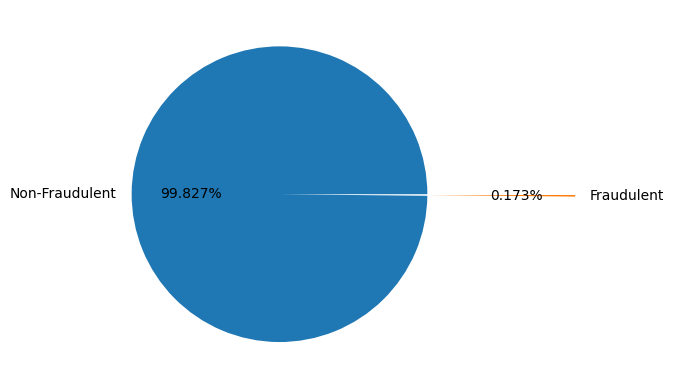

In [11]:
fig, ax = plt.subplots()
explode = [0, 1]
ax.pie(data["Class"].value_counts(),  labels=['Non-Fraudulent', 'Fraudulent'], autopct="%1.3f%%", explode = explode)
plt.show()

As we can see, that data imbalance is a real huge. Only 0,173% od data is marked as 1 (Fraud)

array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

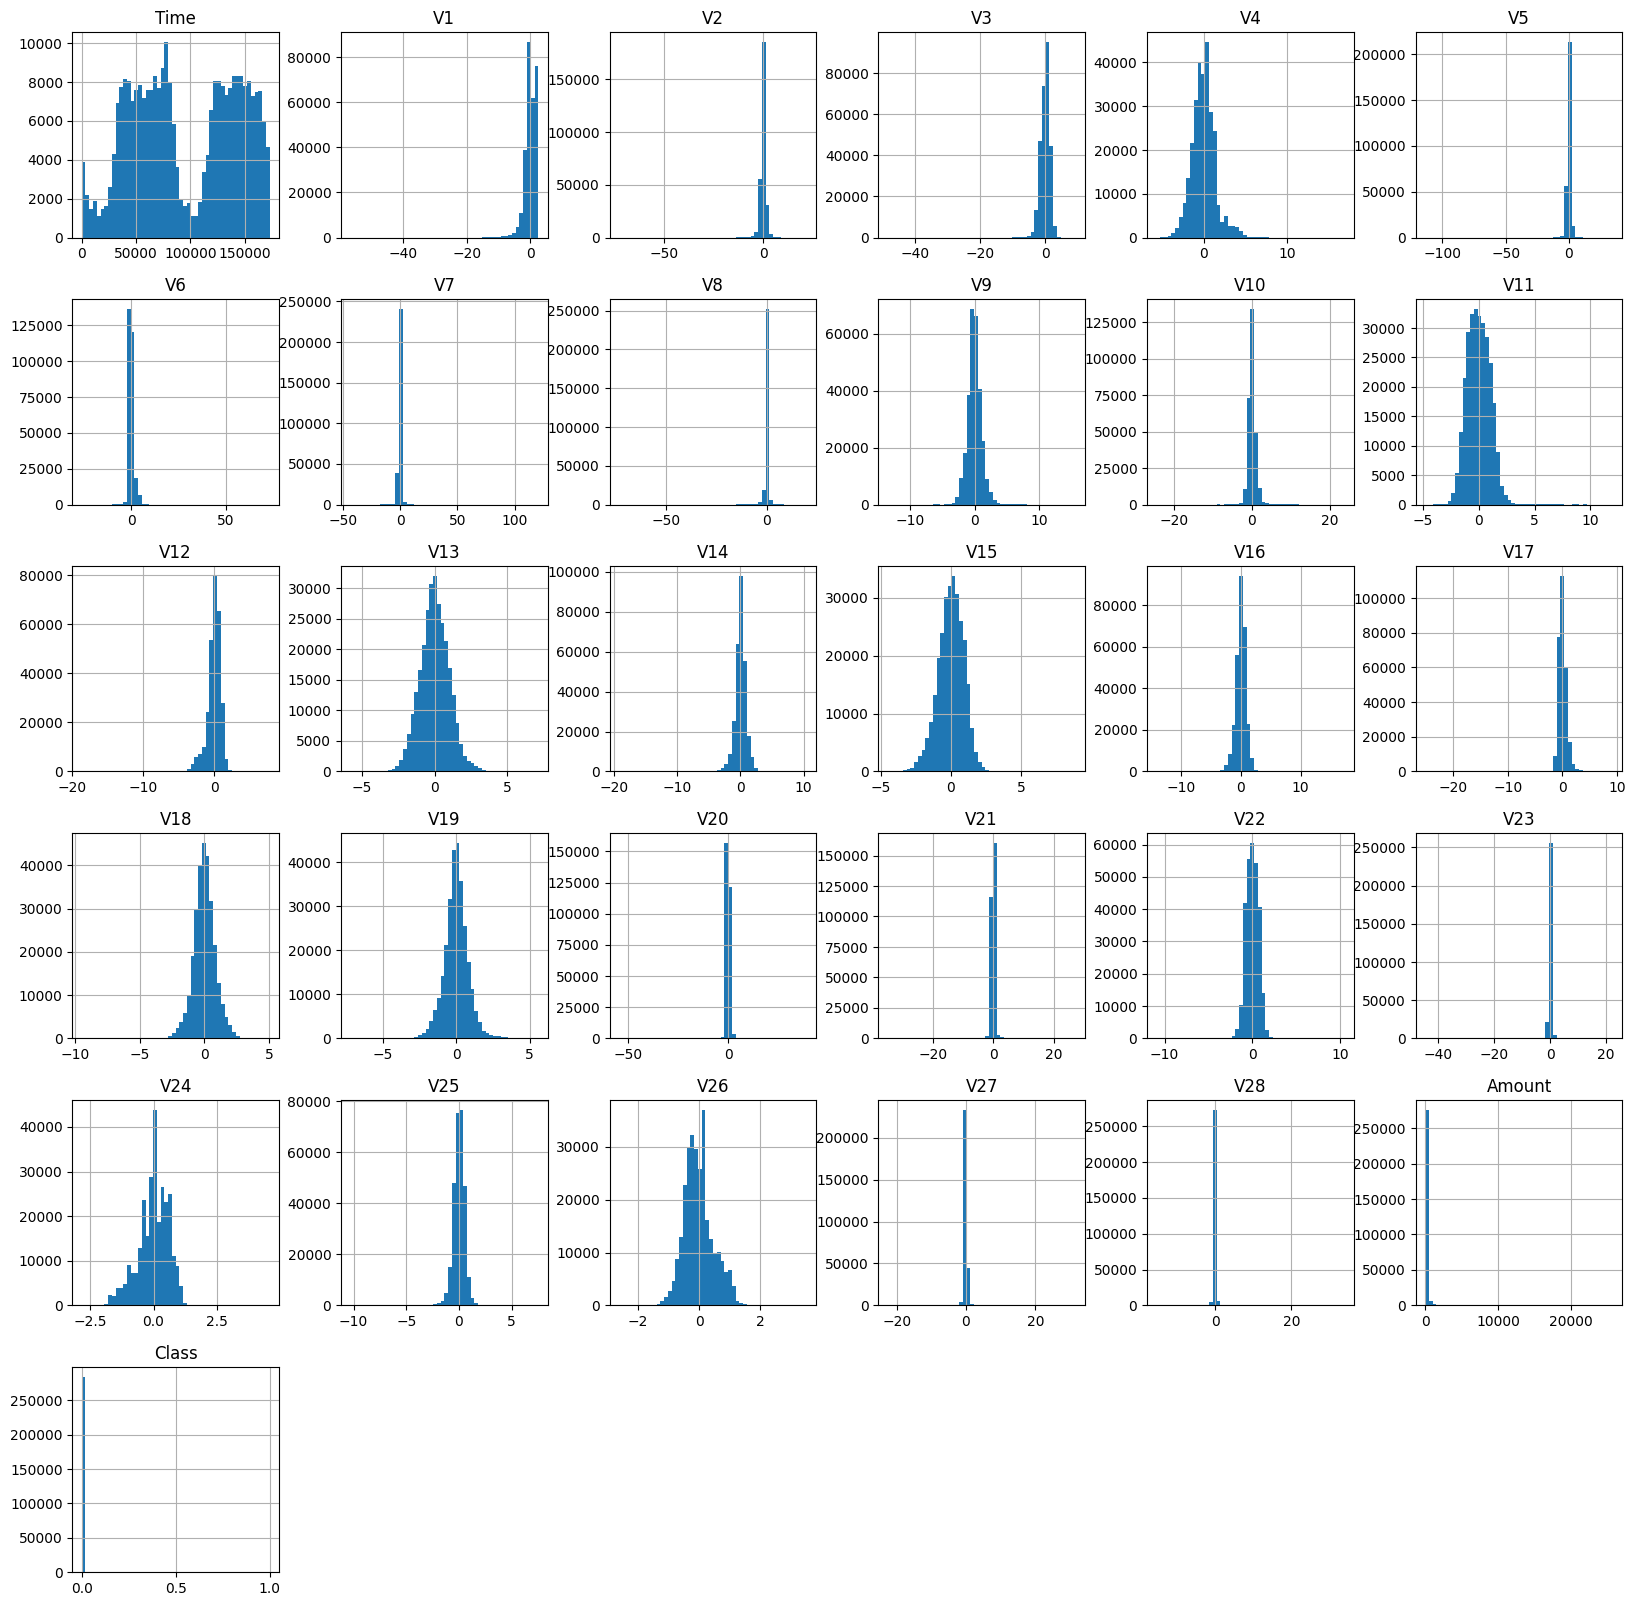

In [12]:
data.hist(figsize=(20,20), bins=50)

<Axes: xlabel='Time', ylabel='Count'>

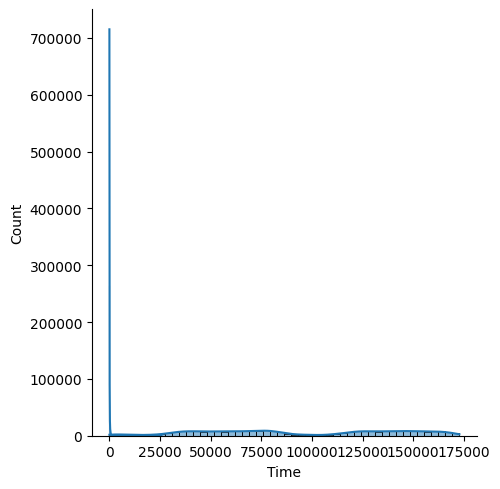

In [13]:
sns.displot(data['Time'], kde=True, bins=50)

sns.histplot(data['Amount'], kde=True, bins=100)

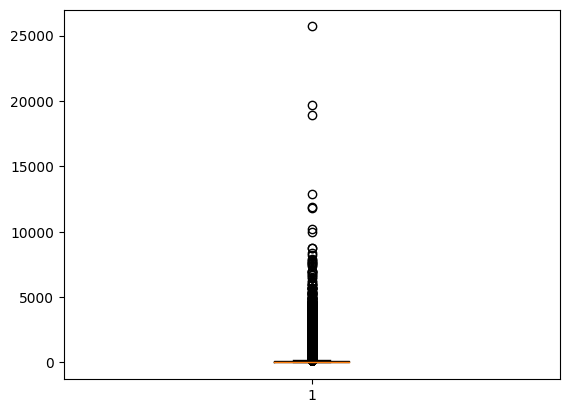

In [14]:
plt.boxplot(data["Amount"])
plt.show()

As we can see `Time` feature is not scaled at all, and `Amount` is right skewed

**Spliting Data - without over/under sampling**
Why we split data set first, before applying scaling? To prevent data leakage!
Suppose we did not do it, and we scale `Time` and `Amount` columns with `fit_transform` function to whole dataset. That gives our model unfair advantage, because it learn the distribution of **TEST** set (test set is part of whole data set in that case) 


In [15]:
y = data["Class"]
X = data.drop("Class", axis=1)

In [16]:
X.shape,y.shape


((284807, 30), (284807,))

In [17]:
X_train_orginal, X_temp_orginal, y_train_orginal, y_temp_orginal = train_test_split(X,y,test_size=0.4, stratify=y, random_state=42)

In [18]:
X_val_orginal,X_test_orginal,y_val_orginal,y_test_orginal = train_test_split(X_temp_orginal,y_temp_orginal, test_size=0.2, stratify=y_temp_orginal)

Check if data are splited with consideration of target labels

In [19]:
y_train_orginal.value_counts()

Class
0    170589
1       295
Name: count, dtype: int64

In [20]:
y_val_orginal.value_counts()

Class
0    90980
1      158
Name: count, dtype: int64

In [21]:
y_test_orginal.value_counts()

Class
0    22746
1       39
Name: count, dtype: int64

### Whitch scaler to use? 
Since there is much outliers in`Time` and `Amount` we will use RobustScaler 

In [22]:
rob_scaler = RobustScaler()
# Training set
X_train_orginal["Time"] = rob_scaler.fit_transform(X_train_orginal["Time"].values.reshape(-1,1))
X_train_orginal["Amount"] = rob_scaler.fit_transform(X_train_orginal["Amount"].values.reshape(-1, 1))

# Validation set
X_val_orginal["Time"] = rob_scaler.transform(X_val_orginal["Time"].values.reshape(-1,1))
X_val_orginal["Amount"] = rob_scaler.transform(X_val_orginal["Amount"].values.reshape(-1, 1))

# Test set
X_test_orginal["Time"] = rob_scaler.transform(X_test_orginal["Time"].values.reshape(-1, 1))
X_test_orginal["Amount"] = rob_scaler.transform(X_test_orginal["Amount"].values.reshape(-1, 1))




# 3. Training models on raw data
In this part of the notebook, we will see how a few shallow learning algorythms performs on imbalance data set


In [23]:
shallow_models = {
    "LogReg": LogisticRegression(random_state=42, max_iter=1000),
    "RF": RandomForestClassifier(random_state=42),
    "KNN":KNeighborsClassifier(),
}



def my_auc_pr(y_true, y_pred_proba):
#     probabilities = estimator.predict_proba(X)[:, 1] automatically called from in scorrer needs_proba=True
    return metrics.average_precision_score(y_true, y_pred_proba)
    


scoring = {
    #     "AUC_PR": precision_recall_curve

    "f1_macro": metrics.make_scorer(metrics.f1_score, average='macro'),
    "f1_micro": metrics.make_scorer(metrics.f1_score, average='micro'),
    "recall": metrics.make_scorer(metrics.recall_score),
    "precision": metrics.make_scorer(metrics.precision_score),
    "accuracy": metrics.make_scorer(metrics.accuracy_score),
    "AUC_PR": metrics.make_scorer(my_auc_pr, needs_proba=True) 
}



## 3.1 Choosing shallow learning model

In [24]:
def cross_val_func(models_dict, X, y, cv):
    
    cv_S = StratifiedKFold(n_splits=cv, shuffle=True,random_state=42)
    
    models_results = {}
    
    for name,model in models_dict.items():
        result = cross_validate(model, X=X, y=y, scoring=scoring, cv=cv_S)
        models_results[name] = result
        
        
    models_mean_results = {}
    for model_name, d in models_results.items():
        models_mean_results[model_name] = {}
        for key, value in d.items():
            mean = np.mean(models_results[model_name][key])
            models_mean_results[model_name][key] = mean    
    
    return models_mean_results

In [25]:
# models_results_cv = cross_val_func(shallow_models,X_train_orginal,y_train_orginal,3)


In [26]:
models_results_cv = {'LogReg': {'fit_time': 3.32098388671875,
  'score_time': 0.3877097765604655,
  'test_f1_macro': 0.8601722143136827,
  'test_f1_micro': 0.9991783914613389,
  'test_recall': 0.6178861788617885,
  'test_precision': 0.8671916433423585,
  'test_acuracy': 0.9991783914613389,
  'test_AUC_PR': 0.7572681818632944},
 'RF': {'fit_time': 161.1881671746572,
  'score_time': 1.8001182874043782,
  'test_f1_macro': 0.9316758420036063,
  'test_f1_micro': 0.9995681283704266,
  'test_recall': 0.790650406504065,
  'test_precision': 0.9513988808952837,
  'test_acuracy': 0.9995681283704266,
  'test_AUC_PR': 0.843899387303838},
 'KNN': {'fit_time': 0.10558557510375977,
  'score_time': 82.82904656728108,
  'test_f1_macro': 0.9182911060845232,
  'test_f1_micro': 0.9994873719160143,
  'test_recall': 0.7601626016260162,
  'test_precision': 0.9308558820757593,
  'test_acuracy': 0.9994873719160143,
  'test_AUC_PR': 0.8006882162021421}}

In [27]:
cv_models_df = pd.DataFrame(models_results_cv)
cv_models_df.style.highlight_max(axis=1, color="pink")


,LogReg,RF,KNN
fit_time,3.320984,161.188167,0.105586
score_time,0.387710,1.800118,82.829047
test_f1_macro,0.860172,0.931676,0.918291
test_f1_micro,0.999178,0.999568,0.999487
test_recall,0.617886,0.790650,0.760163
test_precision,0.867192,0.951399,0.930856
test_acuracy,0.999178,0.999568,0.999487
test_AUC_PR,0.757268,0.843899,0.800688


RandomForest seems as the best choice to proceed with, if the training time is not relevant.

In [28]:

def random_or_grid_search_with_validation(estimator, X_train, y_train, X_val, y_val, params, cv, scoring, random=True):
    """
    Function will do RandomizedSearchCv or GridSearchCV and Validate model 
    """
    cv_= StratifiedKFold(n_splits=cv, shuffle=True,random_state=42)
    
    results_test = {}
    results_val = {}
    
    if random:
        model = RandomizedSearchCV(estimator=estimator, param_distributions=params, scoring = scoring, random_state=42, cv=cv_, refit="AUC_PR")
    else:
        model = GridSearchCV(estimator=estimator, param_grid=params, scoring = scoring, cv=cv_, refit="AUC_PR")
        
    model.fit(X_train,y_train)
    
    best_model = model.best_estimator_
    
    y_val_preds_probability = best_model.predict_proba(X_val)[:,1]
    validation_auc_pr = my_auc_pr(y_val, y_val_preds_probability)
    
    results = {
        'best_params': model.best_params_,
        'best_score': model.best_score_,
        'validation_score': validation_auc_pr,
        'cv_results': model.cv_results_
    }
        
    
    return results
    

RandomizedSearchCV params


In [29]:
params_RF_RSCV = {
    'n_estimators': [100, 200, 300, 400, 500],  
    'max_depth': [None, 10, 20, 30, 40, 50],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'bootstrap': [True, False],  
    'criterion': ['gini', 'entropy'],  
    'class_weight': [None, 'balanced', 'balanced_subsample'],  
}


## 

## 3.2 RandomizedSearchCV and hyperparamter tuning

In [30]:
rf_simple = RandomForestClassifier(random_state=42)

# RF_RSCV_no_data_manipilation = random_or_grid_search_with_validation(estimator = rf_simple, X_train = X_train_orginal,y_train = y_train_orginal, X_val = X_val_orginal, y_val = y_val_orginal,
#                                                                     params = params_RF_RSCV,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=True)


In [31]:
 # RF_RSCV_no_data_manipilation

In [32]:
RF_RSCV_no_data_manipilation_dict = {'best_params': {'n_estimators': 500,
  'min_samples_split': 2,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'max_depth': None,
  'criterion': 'entropy',
  'class_weight': None,
  'bootstrap': False},
 'best_score': 0.8371113846971526,
 'validation_score': 0.9144695577176971,
 'cv_results': {'mean_fit_time': np.array([ 98.74822696,  90.7137092 , 153.82426484, 372.08481741,
         659.2139128 , 136.54062462, 271.67075634, 132.6115915 ,
         769.83840084, 371.4886148 ]),
  'std_fit_time': np.array([ 2.60251418,  2.36730679,  3.10479952, 15.74754438, 17.27346124,
          4.67469176,  4.032009  ,  1.12580689, 28.21086695,  7.63884679]),
  'mean_score_time': np.array([1.24082557, 1.0887231 , 1.52189724, 2.81397804, 5.6248529 ,
         1.28149239, 2.5768683 , 2.17853268, 5.66596858, 3.34468317]),
  'std_score_time': np.array([0.01768119, 0.02567685, 0.08343734, 0.06614565, 0.03923696,
         0.02722676, 0.01297156, 0.02986757, 0.11515156, 0.16662842]),
  'param_n_estimators': np.ma.masked_array(data=[100, 100, 100, 200, 500, 100, 200, 200, 400, 300],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_min_samples_split': np.ma.masked_array(data=[10, 5, 5, 2, 2, 10, 2, 2, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_min_samples_leaf': np.ma.masked_array(data=[2, 1, 4, 2, 2, 1, 2, 2, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_max_features': np.ma.masked_array(data=['log2', 'sqrt', 'log2', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                     'log2', 'auto', 'sqrt'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': np.ma.masked_array(data=[50, None, 30, 20, None, 40, 30, 20, 50, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_criterion': np.ma.masked_array(data=['gini', 'entropy', 'gini', 'gini', 'entropy',
                     'entropy', 'gini', 'entropy', 'gini', 'gini'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_class_weight': np.ma.masked_array(data=['balanced', None, None, None, None, None, None,
                     'balanced_subsample', None, 'balanced_subsample'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_bootstrap': np.ma.masked_array(data=[False, True, False, False, False, False, True, True,
                     False, False],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 100,
    'min_samples_split': 10,
    'min_samples_leaf': 2,
    'max_features': 'log2',
    'max_depth': 50,
    'criterion': 'gini',
    'class_weight': 'balanced',
    'bootstrap': False},
   {'n_estimators': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': None,
    'criterion': 'entropy',
    'class_weight': None,
    'bootstrap': True},
   {'n_estimators': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 4,
    'max_features': 'log2',
    'max_depth': 30,
    'criterion': 'gini',
    'class_weight': None,
    'bootstrap': False},
   {'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 20,
    'criterion': 'gini',
    'class_weight': None,
    'bootstrap': False},
   {'n_estimators': 500,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': None,
    'criterion': 'entropy',
    'class_weight': None,
    'bootstrap': False},
   {'n_estimators': 100,
    'min_samples_split': 10,
    'min_samples_leaf': 1,
    'max_features': 'sqrt',
    'max_depth': 40,
    'criterion': 'entropy',
    'class_weight': None,
    'bootstrap': False},
   {'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'max_depth': 30,
    'criterion': 'gini',
    'class_weight': None,
    'bootstrap': True},
   {'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
    'max_features': 'log2',
    'max_depth': 20,
    'criterion': 'entropy',
    'class_weight': 'balanced_subsample',
    'bootstrap': True},
   {'n_estimators': 400,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'auto',
    'max_depth': 50,
    'criterion': 'gini',
    'class_weight': None,
    'bootstrap': False},
   {'n_estimators': 300,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': 'sqrt',
    'max_depth': 10,
    'criterion': 'gini',
    'class_weight': 'balanced_subsample',
    'bootstrap': False}],
  'split0_test_f1_macro': np.array([0.93565309, 0.93171269, 0.93247877, 0.93810554, 0.93492715,
         0.93492715, 0.92926864, 0.92602208, 0.93247877, 0.92540882]),
  'split1_test_f1_macro': np.array([0.90609173, 0.9129028 , 0.90525154, 0.91383782, 0.91475294,
         0.91922295, 0.90525154, 0.91383782, 0.90525154, 0.89284577]),
  'split2_test_f1_macro': np.array([0.89309139, 0.90336372, 0.89269891, 0.90683608, 0.9057417 ,
         0.90683608, 0.89395941, 0.89395941, 0.89629586, 0.90306755]),
  'mean_test_f1_macro': np.array([0.91161207, 0.91599307, 0.91014307, 0.91959315, 0.91847393,
         0.92032873, 0.9094932 , 0.9112731 , 0.91134206, 0.90710738]),
  'std_test_f1_macro': np.array([0.0178088 , 0.0117779 , 0.01660431, 0.0133987 , 0.01220197,
         0.01149475, 0.01472366, 0.01321456, 0.01538661, 0.01359726]),
  'rank_test_f1_macro': np.array([ 5,  4,  8,  2,  3,  1,  9,  7,  6, 10], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.99959622, 0.99957867, 0.99957867, 0.99961378, 0.99959622,
         0.99959622, 0.99956111, 0.99954356, 0.99957867, 0.99950844]),
  'split1_test_f1_micro': np.array([0.99936799, 0.99943821, 0.99938554, 0.99943821, 0.99943821,
         0.99947332, 0.99938554, 0.99943821, 0.99938554, 0.9992451 ]),
  'split2_test_f1_micro': np.array([0.99933288, 0.99942066, 0.99936799, 0.99943821, 0.99943821,
         0.99943821, 0.99936799, 0.99936799, 0.99938554, 0.99936799]),
  'mean_test_f1_micro': np.array([0.99943236, 0.99947918, 0.99944407, 0.99949673, 0.99949088,
         0.99950259, 0.99943821, 0.99944992, 0.99944992, 0.99937384]),
  'std_test_f1_micro': np.array([1.16749496e-04, 7.07129367e-05, 9.54460104e-05, 8.27623685e-05,
         7.44865966e-05, 6.77445679e-05, 8.71958182e-05, 7.21512401e-05,
         9.10385763e-05, 1.07590523e-04]),
  'rank_test_f1_micro': np.array([ 9,  4,  7,  2,  3,  1,  8,  5,  6, 10], dtype=np.int32),
  'split0_test_recall': np.array([0.78787879, 0.76767677, 0.77777778, 0.78787879, 0.77777778,
         0.77777778, 0.76767677, 0.75757576, 0.77777778, 0.80808081]),
  'split1_test_recall': np.array([0.79591837, 0.7755102 , 0.76530612, 0.78571429, 0.79591837,
         0.79591837, 0.76530612, 0.78571429, 0.76530612, 0.80612245]),
  'split2_test_recall': np.array([0.71428571, 0.70408163, 0.67346939, 0.71428571, 0.70408163,
         0.71428571, 0.68367347, 0.68367347, 0.68367347, 0.76530612]),
  'mean_test_recall': np.array([0.76602762, 0.74908953, 0.7388511 , 0.76262626, 0.75925926,
         0.76266062, 0.73888545, 0.74232117, 0.74225246, 0.79316979]),
  'std_test_recall': np.array([0.03673398, 0.03198566, 0.04651137, 0.03419335, 0.03971312,
         0.03499875, 0.03905276, 0.04303184, 0.04173335, 0.0197188 ]),
  'rank_test_recall': np.array([ 2,  6, 10,  4,  5,  3,  9,  7,  8,  1], dtype=np.int32),
  'split0_test_precision': np.array([0.975     , 0.98701299, 0.97468354, 0.98734177, 0.98717949,
         0.98717949, 0.97435897, 0.97402597, 0.97468354, 0.8988764 ]),
  'split1_test_precision': np.array([0.82978723, 0.88372093, 0.86206897, 0.875     , 0.86666667,
         0.88636364, 0.86206897, 0.875     , 0.86206897, 0.76699029]),
  'split2_test_precision': np.array([0.875     , 0.94520548, 0.94285714, 0.94594595, 0.95833333,
         0.94594595, 0.93055556, 0.93055556, 0.94366197, 0.85227273]),
  'mean_test_precision': np.array([0.89326241, 0.93864647, 0.92653655, 0.93609591, 0.93739316,
         0.93982969, 0.92232783, 0.92652718, 0.92680483, 0.83937981]),
  'std_test_precision': np.array([0.06067302, 0.04242309, 0.047401  , 0.04638919, 0.051379  ,
         0.0413845 , 0.04620991, 0.04052741, 0.0474948 , 0.05460865]),
  'rank_test_precision': np.array([ 9,  2,  6,  4,  3,  1,  8,  7,  5, 10], dtype=np.int32),
  'split0_test_accuracy': np.array([0.99959622, 0.99957867, 0.99957867, 0.99961378, 0.99959622,
         0.99959622, 0.99956111, 0.99954356, 0.99957867, 0.99950844]),
  'split1_test_accuracy': np.array([0.99936799, 0.99943821, 0.99938554, 0.99943821, 0.99943821,
         0.99947332, 0.99938554, 0.99943821, 0.99938554, 0.9992451 ]),
  'split2_test_accuracy': np.array([0.99933288, 0.99942066, 0.99936799, 0.99943821, 0.99943821,
         0.99943821, 0.99936799, 0.99936799, 0.99938554, 0.99936799]),
  'mean_test_accuracy': np.array([0.99943236, 0.99947918, 0.99944407, 0.99949673, 0.99949088,
         0.99950259, 0.99943821, 0.99944992, 0.99944992, 0.99937384]),
  'std_test_accuracy': np.array([1.16749496e-04, 7.07129367e-05, 9.54460104e-05, 8.27623685e-05,
         7.44865966e-05, 6.77445679e-05, 8.71958182e-05, 7.21512401e-05,
         9.10385763e-05, 1.07590523e-04]),
  'rank_test_accuracy': np.array([ 9,  4,  7,  2,  3,  1,  8,  5,  6, 10], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.83997774, 0.83532858, 0.83299032, 0.8348646 , 0.84836731,
         0.83498307, 0.83369023, 0.84859382, 0.83527944, 0.83650877]),
  'split1_test_AUC_PR': np.array([0.79370939, 0.82460663, 0.8151634 , 0.81716598, 0.83031009,
         0.8254386 , 0.8192323 , 0.82147241, 0.82081733, 0.80013   ]),
  'split2_test_AUC_PR': np.array([0.8118101 , 0.81950424, 0.81484851, 0.82404775, 0.83265675,
         0.8254157 , 0.81838267, 0.82960372, 0.8190372 , 0.80248605]),
  'mean_test_AUC_PR': np.array([0.81516574, 0.82647982, 0.82100074, 0.82535945, 0.83711138,
         0.82861246, 0.8237684 , 0.83322332, 0.82504466, 0.81304161]),
  'std_test_AUC_PR': np.array([0.01903742, 0.00659464, 0.00847888, 0.00728472, 0.00801659,
         0.00450471, 0.00702436, 0.01136424, 0.00727348, 0.01662165]),
  'rank_test_AUC_PR': np.array([ 9,  4,  8,  5,  1,  3,  7,  2,  6, 10], dtype=np.int32)}}

In [33]:
# RF_RSCV_no_data_manipilation_df = pd.DataFrame(RF_RSCV_no_data_manipilation_dict)
cv_results = RF_RSCV_no_data_manipilation_dict['cv_results']
metrics_RF_RSCV_NO_manipulation = pd.DataFrame({
    'mean_fit_time': cv_results['mean_fit_time'],
    'mean_score_time': cv_results['mean_score_time'],
    'test_f1_macro': cv_results['mean_test_f1_macro'],
    'test_f1_micro': cv_results['mean_test_f1_micro'],
    'test_recall': cv_results['mean_test_recall'],
    'test_precision': cv_results['mean_test_precision'],
    'test_accuracy': cv_results['mean_test_accuracy'],
    'test_AUC_PR': cv_results['mean_test_AUC_PR'],
    'best_score': RF_RSCV_no_data_manipilation_dict['best_score'],
    'validation_score_auc_pr' : RF_RSCV_no_data_manipilation_dict['validation_score']
})
metrics_RF_RSCV_NO_manipulation = metrics_RF_RSCV_NO_manipulation.median()

In [34]:
metrics_RF_RSCV_NO_manipulation = pd.DataFrame(metrics_RF_RSCV_NO_manipulation, columns=["RF RSCV No Manipulation"])
metrics_RF_RSCV_NO_manipulation

,RF RSCV No Manipulation
mean_fit_time,212.747511
mean_score_time,2.377700
test_f1_macro,0.911477
test_f1_micro,0.999450
test_recall,0.754174
test_precision,0.926671
test_accuracy,0.999450
test_AUC_PR,0.825202
best_score,0.837111
validation_score_auc_pr,0.914470


In [35]:
best_RF_RS_NO = RF_RSCV_no_data_manipilation_dict["best_score"]
val_RF_RS_NO = RF_RSCV_no_data_manipilation_dict["validation_score"]
val_vs_best_RF_RS_NO_manipulation = pd.DataFrame([best_RF_RS_NO,val_RF_RS_NO], index=["Best Score","Validation Score"], columns=["RF RSCV NO Manipulation"])
val_vs_best_RF_RS_NO_manipulation

,RF RSCV NO Manipulation
Best Score,0.837111
Validation Score,0.914470


Question: Why model does better on validation set? Is that Over or Under fitting! We should not realy on that model to be albe to gerneralize well in the future

## 3.3 GridSearchCV and hyperparamter tuning

In [36]:
param_grid_RF = { # Doue to long training time, reducing parameters
    'n_estimators': [500],  
    'min_samples_split': [2, 5],  
    'min_samples_leaf': [1, 2],    
    'max_features': ['sqrt'], 
    'max_depth': [None],     
    'criterion': ['entropy'],         
    'class_weight': [None, 'balanced'],  
    'bootstrap': [False]             
}

rf_simple = RandomForestClassifier(random_state=42)


# RF_Grid_no_data_manipilation = random_or_grid_search_with_validation(estimator = rf_simple, X_train = X_train_orginal,y_train = y_train_orginal, X_val = X_val_orginal, y_val = y_val_orginal,
#                                                                     params = param_grid_RF,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=False)

In [37]:
RF_Grid_no_data_manipilation_dict = {'best_params': {'bootstrap': False,
  'class_weight': None,
  'criterion': 'entropy',
  'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 2,
  'n_estimators': 500},
 'best_score': 0.857486377211034,
 'validation_score': 0.8677214502018403,
 'cv_results': {'mean_fit_time': np.array([515.48084545, 510.26663613, 512.43165143, 512.62932873,
         442.05039891, 443.52495933, 441.71664333, 428.46529325]),
  'std_fit_time': np.array([27.2094469 , 29.78652748, 30.5463518 , 25.48396595, 25.86505739,
         26.1957387 , 29.44761451, 33.23406001]),
  'mean_score_time': np.array([4.50537006, 4.49357279, 4.44891357, 4.55865518, 4.29345401,
         4.2600828 , 4.33349888, 4.20547024]),
  'std_score_time': np.array([0.09056594, 0.09561657, 0.11457715, 0.11808543, 0.09384695,
         0.15033772, 0.23153513, 0.19205127]),
  'param_bootstrap': np.ma.masked_array(data=[False, False, False, False, False, False, False, False],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_class_weight': np.ma.masked_array(data=[None, None, None, None, 'balanced', 'balanced',
                     'balanced', 'balanced'],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_criterion': np.ma.masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy'],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_max_depth': np.ma.masked_array(data=[None, None, None, None, None, None, None, None],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_max_features': np.ma.masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                     'sqrt'],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_samples_leaf': np.ma.masked_array(data=[1, 1, 2, 2, 1, 1, 2, 2],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_min_samples_split': np.ma.masked_array(data=[2, 5, 2, 5, 2, 5, 2, 5],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_n_estimators': np.ma.masked_array(data=[500, 500, 500, 500, 500, 500, 500, 500],
               mask=[False, False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'bootstrap': False,
    'class_weight': None,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': None,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': None,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': None,
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': 'balanced',
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': 'balanced',
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': 'balanced',
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 2,
    'n_estimators': 500},
   {'bootstrap': False,
    'class_weight': 'balanced',
    'criterion': 'entropy',
    'max_depth': None,
    'max_features': 'sqrt',
    'min_samples_leaf': 2,
    'min_samples_split': 5,
    'n_estimators': 500}],
  'split0_test_f1_macro': np.array([0.93158409, 0.93158409, 0.92845713, 0.93158409, 0.93705736,
         0.93840156, 0.93840156, 0.94139265]),
  'split1_test_f1_macro': np.array([0.91097044, 0.91097044, 0.90869471, 0.90540609, 0.89871815,
         0.90540609, 0.90421772, 0.90201565]),
  'split2_test_f1_macro': np.array([0.93092899, 0.92763577, 0.92763577, 0.92763577, 0.91752398,
         0.91752398, 0.91752398, 0.91752398]),
  'mean_test_f1_macro': np.array([0.92449451, 0.92339677, 0.92159587, 0.92154199, 0.9177665 ,
         0.92044388, 0.92004776, 0.92031076]),
  'std_test_f1_macro': np.array([0.0095667 , 0.00893336, 0.00912866, 0.01152309, 0.01565286,
         0.01362766, 0.01406913, 0.01619591]),
  'rank_test_f1_macro': np.array([1, 2, 3, 4, 8, 5, 7, 6], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.99956111, 0.99956111, 0.99954356, 0.99956111, 0.99959622,
         0.99959622, 0.99959622, 0.99961378]),
  'split1_test_f1_micro': np.array([0.99943821, 0.99943821, 0.99942066, 0.9994031 , 0.99936799,
         0.9994031 , 0.99938554, 0.99936799]),
  'split2_test_f1_micro': np.array([0.99957866, 0.9995611 , 0.9995611 , 0.9995611 , 0.99950844,
         0.99950844, 0.99950844, 0.99950844]),
  'mean_test_f1_micro': np.array([0.99952599, 0.99952014, 0.99950844, 0.99950844, 0.99949088,
         0.99950259, 0.99949673, 0.99949673]),
  'std_test_f1_micro': np.array([6.24832482e-05, 5.79332367e-05, 6.24833059e-05, 7.44850712e-05,
         9.39989987e-05, 7.89500210e-05, 8.64058330e-05, 1.00683506e-04]),
  'rank_test_f1_micro': np.array([1, 2, 3, 4, 8, 5, 6, 7], dtype=np.int32),
  'split0_test_recall': np.array([0.7979798 , 0.7979798 , 0.78787879, 0.7979798 , 0.80808081,
         0.82828283, 0.82828283, 0.83838384]),
  'split1_test_recall': np.array([0.75510204, 0.75510204, 0.75510204, 0.74489796, 0.7244898 ,
         0.74489796, 0.75510204, 0.75510204]),
  'split2_test_recall': np.array([0.76530612, 0.75510204, 0.75510204, 0.75510204, 0.7244898 ,
         0.7244898 , 0.7244898 , 0.7244898 ]),
  'mean_test_recall': np.array([0.77279599, 0.76939463, 0.76602762, 0.76599327, 0.75235347,
         0.76589019, 0.76929156, 0.77265856]),
  'std_test_recall': np.array([0.01828841, 0.02021277, 0.01545111, 0.02299833, 0.03940518,
         0.04489806, 0.04354504, 0.04812578]),
  'rank_test_recall': np.array([1, 3, 5, 6, 8, 7, 4, 2], dtype=np.int32),
  'split0_test_precision': np.array([0.94047619, 0.94047619, 0.93975904, 0.94047619, 0.95238095,
         0.93181818, 0.93181818, 0.93258427]),
  'split1_test_precision': np.array([0.90243902, 0.90243902, 0.89156627, 0.8902439 , 0.8875    ,
         0.8902439 , 0.87058824, 0.86046512]),
  'split2_test_precision': np.array([0.98684211, 0.98666667, 0.98666667, 0.98666667, 0.98611111,
         0.98611111, 0.98611111, 0.98611111]),
  'mean_test_precision': np.array([0.94325244, 0.94319396, 0.93933066, 0.93912892, 0.94199735,
         0.93605773, 0.92950584, 0.92638683]),
  'std_test_precision': np.array([0.03451329, 0.03443945, 0.03882576, 0.03937595, 0.04092189,
         0.03925227, 0.04719035, 0.05148162]),
  'rank_test_precision': np.array([1, 2, 4, 5, 3, 6, 7, 8], dtype=np.int32),
  'split0_test_accuracy': np.array([0.99956111, 0.99956111, 0.99954356, 0.99956111, 0.99959622,
         0.99959622, 0.99959622, 0.99961378]),
  'split1_test_accuracy': np.array([0.99943821, 0.99943821, 0.99942066, 0.9994031 , 0.99936799,
         0.9994031 , 0.99938554, 0.99936799]),
  'split2_test_accuracy': np.array([0.99957866, 0.9995611 , 0.9995611 , 0.9995611 , 0.99950844,
         0.99950844, 0.99950844, 0.99950844]),
  'mean_test_accuracy': np.array([0.99952599, 0.99952014, 0.99950844, 0.99950844, 0.99949088,
         0.99950259, 0.99949673, 0.99949673]),
  'std_test_accuracy': np.array([6.24832482e-05, 5.79332367e-05, 6.24833059e-05, 7.44850712e-05,
         9.39989987e-05, 7.89500210e-05, 8.64058330e-05, 1.00683506e-04]),
  'rank_test_accuracy': np.array([1, 2, 3, 4, 8, 5, 6, 7], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.88374264, 0.88369387, 0.8827182 , 0.88542082, 0.88327853,
         0.88019309, 0.88393934, 0.88258031]),
  'split1_test_AUC_PR': np.array([0.80646701, 0.8061059 , 0.80508323, 0.80640185, 0.7952623 ,
         0.79729009, 0.79729667, 0.79442879]),
  'split2_test_AUC_PR': np.array([0.88224948, 0.88008141, 0.88202402, 0.88021665, 0.87091648,
         0.8726268 , 0.87751404, 0.87300965]),
  'mean_test_AUC_PR': np.array([0.85748638, 0.85662706, 0.85660848, 0.85734644, 0.8498191 ,
         0.85003666, 0.85291669, 0.85000625]),
  'std_test_AUC_PR': np.array([0.03608129, 0.03575428, 0.03643496, 0.03608586, 0.0389062 ,
         0.03742515, 0.03941667, 0.03949295]),
  'rank_test_AUC_PR': np.array([1, 3, 4, 2, 8, 6, 5, 7], dtype=np.int32)}}

In [38]:
cv_results_2 = RF_Grid_no_data_manipilation_dict['cv_results']
metrics_GRID_CV_NO_manipulation = pd.DataFrame({
    'mean_fit_time': cv_results_2['mean_fit_time'],
    'mean_score_time': cv_results_2['mean_score_time'],
    'test_f1_macro': cv_results_2['mean_test_f1_macro'],
    'test_f1_micro': cv_results_2['mean_test_f1_micro'],
    'test_recall': cv_results_2['mean_test_recall'],
    'test_precision': cv_results_2['mean_test_precision'],
    'test_accuracy': cv_results_2['mean_test_accuracy'],
    'test_AUC_PR': cv_results_2['mean_test_AUC_PR'],
    'best_score': RF_Grid_no_data_manipilation_dict['best_score'],
    'validation_score_auc_pr' : RF_Grid_no_data_manipilation_dict['validation_score']
})
metrics_GRID_CV_NO_manipulation = metrics_GRID_CV_NO_manipulation.median()
metrics_GRID_CV_NO_manipulation_df = pd.DataFrame(metrics_GRID_CV_NO_manipulation, columns=["RF GRID_CV No Manipulation"])
metrics_GRID_CV_NO_manipulation_df

,RF GRID_CV No Manipulation
mean_fit_time,476.895798
mean_score_time,4.391206
test_f1_macro,0.920993
test_f1_micro,0.999506
test_recall,0.767660
test_precision,0.939230
test_accuracy,0.999506
test_AUC_PR,0.854763
best_score,0.857486
validation_score_auc_pr,0.867721


In [39]:
best_RF_Grid_NO = RF_Grid_no_data_manipilation_dict["best_score"]
val_RF_Grid_NO = RF_Grid_no_data_manipilation_dict["validation_score"]
val_vs_best_RF_Grid_NO_manipulation = pd.DataFrame([best_RF_Grid_NO,val_RF_Grid_NO], index=["Best Score","Validation Score"], columns=["RF GRID_CV NO Manipulation"])
val_vs_best_RF_Grid_NO_manipulation

,RF GRID_CV NO Manipulation
Best Score,0.857486
Validation Score,0.867721


## 3.4 Final model

In [40]:
# Prepare data 
X_train_orginal, X_test_orginal, y_train_orginal, y_test_orginal = train_test_split(X,y,test_size=0.2, stratify=y)

In [41]:
# Scaling
rob_scaler = RobustScaler()
# Training set
X_train_orginal["Time"] = rob_scaler.fit_transform(X_train_orginal["Time"].values.reshape(-1,1))
X_train_orginal["Amount"] = rob_scaler.fit_transform(X_train_orginal["Amount"].values.reshape(-1, 1))

# Test set
X_test_orginal["Time"] = rob_scaler.transform(X_test_orginal["Time"].values.reshape(-1, 1))
X_test_orginal["Amount"] = rob_scaler.transform(X_test_orginal["Amount"].values.reshape(-1, 1))


In [42]:
best_params_RF_no_manipulation = RF_Grid_no_data_manipilation_dict['best_params']
final_RF_no_manipulation = RandomForestClassifier(**best_params_RF_no_manipulation, random_state=42)

In [43]:
# final_RF_no_manipulation.fit(X_train_orginal,y_train_orginal)

#### Function to evaluate shallow learning model on TEST data

In [44]:
def evaluate_model_test(model,X_test, y_test):
    
    
    y_test_preds_PROBA = model.predict_proba(X_test)[:,-1]

    y_test_pred = model.predict(X_test)
    
    metrics_results = {
        "F1 Macro": metrics.f1_score(y_test, y_test_pred, average='macro'),
        "F1 Micro": metrics.f1_score(y_test, y_test_pred, average='micro'),
        "Recall": metrics.recall_score(y_test, y_test_pred),
        "Precision": metrics.precision_score(y_test, y_test_pred),
        "Accuracy": metrics.accuracy_score(y_test, y_test_pred),
        "AUC PR": my_auc_pr(y_test, y_test_preds_PROBA)  
    }
    
    return metrics_results 


In [45]:
# RF_no_manipualtion_final_results = evaluate_model_test(final_RF_no_manipulation,X_test_orginal,y_test_orginal)

In [46]:
RF_no_manipualtion_final_results_dict = {'F1 Macro': 0.912293111200946,
 'F1 Micro': 0.9994557775359011,
 'Recall': 0.7448979591836735,
 'Precision': 0.9240506329113924,
 'Accuracy': 0.9994557775359011,
 'AUC PR': 0.8240863363101621}

In [47]:
RF_no_manipualtion_final_results_df = pd.DataFrame(RF_no_manipualtion_final_results_dict, index=["RF No Manipulation Final"]).T


### Random Forest Without Data Manipulation - Summary

In [48]:
RF_no_manipualtion_final_results_df

,RF No Manipulation Final
F1 Macro,0.912293
F1 Micro,0.999456
Recall,0.744898
Precision,0.924051
Accuracy,0.999456
AUC PR,0.824086


Final model was trained on unchanded data. 
* Recall = 0.744898. Recall measuers how many fraud transaction were actually indetified by model as fraud. It is crusial model's characteristics since our main goal is to find fradulent tranasctions. Not catching them on production and deployment may be very costly for customers and for financial instituion as well since it loesses a client's trust. It looks like model looses 25% of fradulet transactions whitch is not very good. In our case recall in more important than precsion.
* AUC PR score is not bad, but still there is a room for improvement




## 3.5 Deep Learning model
In this part i will create simple PyTorch model (non-linar) and train it on unbalance data set. Then i will compare the results wiht Shallow Learning Model

In [49]:
# In here 
X_train_orginal, X_test_orginal, y_train_orginal, y_test_orginal = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

In [50]:
y_train_orginal.value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [51]:
y_test_orginal.value_counts()

Class
0    56864
1       98
Name: count, dtype: int64

In [52]:
# Scaling
rob_scaler = RobustScaler()
# Training 
X_train_orginal["Time"] = rob_scaler.fit_transform(X_train_orginal["Time"].values.reshape(-1,1))
X_train_orginal["Amount"] = rob_scaler.fit_transform(X_train_orginal["Amount"].values.reshape(-1,1))

# Test 
X_test_orginal["Time"] = rob_scaler.transform(X_test_orginal["Time"].values.reshape(-1,1))
X_test_orginal["Amount"] = rob_scaler.transform(X_test_orginal["Amount"].values.reshape(-1,1))

In [53]:
# Convert data to tensors
X_train_orginal_tensor = torch.from_numpy(X_train_orginal.values).float()
y_train_orginal_tensor = torch.from_numpy(y_train_orginal.values).float()

X_test_orginal_tensor = torch.from_numpy(X_test_orginal.values).float()
y_test_orginal_tensor = torch.from_numpy(y_test_orginal.values).float()

In [54]:
X_train_orginal_tensor.shape , y_train_orginal_tensor.shape

(torch.Size([227845, 30]), torch.Size([227845]))

#### Reusable functions PyTorch

In [55]:
def dataset_to_loader(X_train, y_train, X_test, y_test, batch_size):

    torch.manual_seed(42)
    """
    Function will return two objects train, test DataLoaders
    needs a batch_size
    """

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
  
    train_loader = DataLoader(train_dataset,batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    
    return train_loader, test_loader


def set_device():

    device = "cuda" if torch.cuda.is_available() else "cpu"
    return device 

In [56]:
device = set_device()


# Metrics 
accuracy = Accuracy(task="binary").to(device)
f1_score = F1Score(task="binary").to(device)
precision = Precision(task="binary").to(device)
recall = Recall(task="binary").to(device)


#### Deep Learnig Model Architecture

In [57]:
class deep_model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_shape)
            
        )

    def forward(self,x):
        return self.layer_stack(x)


In [58]:
torch.manual_seed(42)

deep_model_no_manipulation = deep_model(
    input_shape=30,
    hidden_units=128,
    output_shape=1
)
deep_model_no_manipulation

deep_model(
  (layer_stack): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [59]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=deep_model_no_manipulation.parameters(), lr=0.01)

In [60]:
def train_model(model,X_train, y_train, X_test, y_test, epochs, batch_size):
    
    model.to(device)
    
    train_dataloader , test_dataloader = dataset_to_loader(X_train, y_train, X_test, y_test, batch_size)
    
    results = []
    
    for epoch in range(epochs):
        
        accuracy.reset()
        f1_score.reset()
        precision.reset()
        recall.reset()
        train_loss = 0
        
        preds_per_epoch_accumulated = [] # Probabilities
        labels_per_epoch_accumulated = []
        
        model.train()

        for X_train, y_train in train_dataloader:
            
            X_train, y_train = X_train.to(device), y_train.to(device)
            y_train = y_train.unsqueeze(1) #ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1])) to fix that
            
            predictions = model(X_train)
            
            loss = loss_function(predictions, y_train) # No sigmoid her BCEWithLogitsLoss takes care of taht
              
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            # Calcualte AUC PR 
            preds_sigmoid = torch.sigmoid(predictions).detach().cpu().numpy() # Probabilities
            labels = y_train.detach().cpu().numpy() # labels from GPU/tensor to nupy so i can use my_auc_pr function
            
            preds_per_epoch_accumulated.extend(preds_sigmoid)
            labels_per_epoch_accumulated.extend(labels)
            
            predicted_class = (preds_sigmoid >= 0.5).astype(int)
            
            # Metrics update
            train_loss += loss.item()
            accuracy.update(torch.tensor(predicted_class), y_train)
            f1_score.update(torch.tensor(predicted_class), y_train)
            precision.update(torch.tensor(predicted_class), y_train)
            recall.update(torch.tensor(predicted_class), y_train)
            
        accuracy_ = accuracy.compute().item()
        f1_score_ = f1_score.compute().item()
        precision_ = precision.compute().item()
        recall_ = recall.compute().item()
        
        # Calcualte AUC PR 

        auc_pr_ = my_auc_pr(labels_per_epoch_accumulated,preds_per_epoch_accumulated) # calculate auc_pr after each epoch
    
        epoch_results = {
            "epoch" : epoch + 1,
            "loss" : train_loss/len(train_dataloader),
            "accuracy" : accuracy_,
            "f1_score" : f1_score_,
            "precision" : precision_,
            "recall" : recall_,
            "auc pr" : auc_pr_
        }
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch + 1}, Loss: {epoch_results['loss']:.5f}, "
                  f"Accuracy: {accuracy_:.4f}, F1: {f1_score_:.4f}, "
                  f"Precision: {precision_:.4f}, Recall: {recall_:.4f}, AUC-PR: {auc_pr_:.4f}")
        
        results.append(epoch_results)
        
    return results


In [61]:
# For time sake  I will only test to 50 epochs, in the future i may decide to add earliy stopping to prevent model from overfitting

# deep_model_no_manipulation_results = train_model(deep_model_no_manipulation, X_train_orginal_tensor, y_train_orginal_tensor, X_test_orginal_tensor,y_test_orginal_tensor,50,32)

In [62]:
deep_model_no_manipulation_results = [{'epoch': 1,
  'loss': 0.008650170763267687,
  'accuracy': 0.9988632798194885,
  'f1_score': 0.6251809000968933,
  'precision': 0.7272727489471436,
  'recall': 0.5482233762741089,
  'auc pr': 0.5610358993013395},
 {'epoch': 2,
  'loss': 0.007162256167061609,
  'accuracy': 0.9991177916526794,
  'f1_score': 0.714893639087677,
  'precision': 0.8102893829345703,
  'recall': 0.6395938992500305,
  'auc pr': 0.6914474282600369},
 {'epoch': 3,
  'loss': 0.009846106538573969,
  'accuracy': 0.9991880655288696,
  'f1_score': 0.7482993006706238,
  'precision': 0.8064516186714172,
  'recall': 0.6979695558547974,
  'auc pr': 0.7160908441792004},
 {'epoch': 4,
  'loss': 0.009654708125879059,
  'accuracy': 0.9991441369056702,
  'f1_score': 0.7346938848495483,
  'precision': 0.7917888760566711,
  'recall': 0.6852791905403137,
  'auc pr': 0.6890238608002925},
 {'epoch': 5,
  'loss': 0.009085149560441316,
  'accuracy': 0.9991441369056702,
  'f1_score': 0.7249647378921509,
  'precision': 0.8158730268478394,
  'recall': 0.6522842645645142,
  'auc pr': 0.6984555428977016},
 {'epoch': 6,
  'loss': 0.007842248140045957,
  'accuracy': 0.9992626309394836,
  'f1_score': 0.7704917788505554,
  'precision': 0.834319531917572,
  'recall': 0.7157360315322876,
  'auc pr': 0.7251257374973201},
 {'epoch': 7,
  'loss': 0.010563545134979887,
  'accuracy': 0.999275803565979,
  'f1_score': 0.7742817997932434,
  'precision': 0.8397626280784607,
  'recall': 0.7182741165161133,
  'auc pr': 0.7357329882884329},
 {'epoch': 8,
  'loss': 0.007911246411267735,
  'accuracy': 0.9992626309394836,
  'f1_score': 0.7685950398445129,
  'precision': 0.8403614163398743,
  'recall': 0.7081218361854553,
  'auc pr': 0.6971082971359801},
 {'epoch': 9,
  'loss': 0.006579760410576746,
  'accuracy': 0.9992363452911377,
  'f1_score': 0.7635869383811951,
  'precision': 0.8216374516487122,
  'recall': 0.7131979465484619,
  'auc pr': 0.7139384777514117},
 {'epoch': 10,
  'loss': 0.013385920548289808,
  'accuracy': 0.9992451071739197,
  'f1_score': 0.7663043737411499,
  'precision': 0.8245614171028137,
  'recall': 0.7157360315322876,
  'auc pr': 0.6748994752606116},
 {'epoch': 11,
  'loss': 0.00903208801971456,
  'accuracy': 0.9993416666984558,
  'f1_score': 0.7972972989082336,
  'precision': 0.852601170539856,
  'recall': 0.7487309575080872,
  'auc pr': 0.7282490408513487},
 {'epoch': 12,
  'loss': 0.00833054326122703,
  'accuracy': 0.9992802143096924,
  'f1_score': 0.7795698642730713,
  'precision': 0.8285714387893677,
  'recall': 0.7360405921936035,
  'auc pr': 0.709418909694958},
 {'epoch': 13,
  'loss': 0.008658322553253862,
  'accuracy': 0.999267041683197,
  'f1_score': 0.7721691727638245,
  'precision': 0.8348082304000854,
  'recall': 0.7182741165161133,
  'auc pr': 0.6981701765347997},
 {'epoch': 14,
  'loss': 0.0128738771768366,
  'accuracy': 0.9993153214454651,
  'f1_score': 0.7891891598701477,
  'precision': 0.8439306616783142,
  'recall': 0.7411167621612549,
  'auc pr': 0.7167827517091407},
 {'epoch': 15,
  'loss': 0.013316300937039189,
  'accuracy': 0.9992451071739197,
  'f1_score': 0.7724867463111877,
  'precision': 0.8066298365592957,
  'recall': 0.7411167621612549,
  'auc pr': 0.6933615080361814},
 {'epoch': 16,
  'loss': 0.011284936502880323,
  'accuracy': 0.9993021488189697,
  'f1_score': 0.7848443984985352,
  'precision': 0.8405796885490417,
  'recall': 0.7360405921936035,
  'auc pr': 0.7122398543299804},
 {'epoch': 17,
  'loss': 0.00787942894237266,
  'accuracy': 0.9993065595626831,
  'f1_score': 0.7841529846191406,
  'precision': 0.8491124510765076,
  'recall': 0.7284263968467712,
  'auc pr': 0.7285566810442811},
 {'epoch': 18,
  'loss': 0.01029109863302174,
  'accuracy': 0.9992626309394836,
  'f1_score': 0.7692307829856873,
  'precision': 0.8383233547210693,
  'recall': 0.710659921169281,
  'auc pr': 0.7230282089864184},
 {'epoch': 19,
  'loss': 0.0108139599514703,
  'accuracy': 0.9993021488189697,
  'f1_score': 0.7860026955604553,
  'precision': 0.8366762399673462,
  'recall': 0.7411167621612549,
  'auc pr': 0.7088873220083454},
 {'epoch': 20,
  'loss': 0.006482967532617393,
  'accuracy': 0.9992846250534058,
  'f1_score': 0.7757909297943115,
  'precision': 0.8468468189239502,
  'recall': 0.7157360315322876,
  'auc pr': 0.726069588685661},
 {'epoch': 21,
  'loss': 0.009955533828738098,
  'accuracy': 0.9992889761924744,
  'f1_score': 0.7804877758026123,
  'precision': 0.8372092843055725,
  'recall': 0.7309644818305969,
  'auc pr': 0.6976308181031788},
 {'epoch': 22,
  'loss': 0.007077246543681572,
  'accuracy': 0.9993416666984558,
  'f1_score': 0.7967479825019836,
  'precision': 0.854651153087616,
  'recall': 0.7461928725242615,
  'auc pr': 0.7359249284894129},
 {'epoch': 23,
  'loss': 0.005699874193926142,
  'accuracy': 0.9993372559547424,
  'f1_score': 0.7945578098297119,
  'precision': 0.8563050031661987,
  'recall': 0.7411167621612549,
  'auc pr': 0.733064944550177},
 {'epoch': 24,
  'loss': 0.01063154767844513,
  'accuracy': 0.999275803565979,
  'f1_score': 0.7692307829856873,
  'precision': 0.8566977977752686,
  'recall': 0.6979695558547974,
  'auc pr': 0.7265652966215997},
 {'epoch': 25,
  'loss': 0.014037521634919866,
  'accuracy': 0.9993197321891785,
  'f1_score': 0.793057382106781,
  'precision': 0.8366197347640991,
  'recall': 0.7538071274757385,
  'auc pr': 0.7228356080844616},
 {'epoch': 26,
  'loss': 0.007273158299803786,
  'accuracy': 0.9992889761924744,
  'f1_score': 0.7774725556373596,
  'precision': 0.847305417060852,
  'recall': 0.7182741165161133,
  'auc pr': 0.7183350126603315},
 {'epoch': 27,
  'loss': 0.006613105093253543,
  'accuracy': 0.9992977976799011,
  'f1_score': 0.7777777910232544,
  'precision': 0.8588957190513611,
  'recall': 0.710659921169281,
  'auc pr': 0.7368466980774828},
 {'epoch': 28,
  'loss': 0.00755889650213207,
  'accuracy': 0.999275803565979,
  'f1_score': 0.7730398774147034,
  'precision': 0.8438438177108765,
  'recall': 0.7131979465484619,
  'auc pr': 0.7083864978940686},
 {'epoch': 29,
  'loss': 0.007566834197170429,
  'accuracy': 0.9993109107017517,
  'f1_score': 0.785811722278595,
  'precision': 0.8495575189590454,
  'recall': 0.7309644818305969,
  'auc pr': 0.7356041676836504},
 {'epoch': 30,
  'loss': 0.005736496206787861,
  'accuracy': 0.9993197321891785,
  'f1_score': 0.7873799800872803,
  'precision': 0.8567163944244385,
  'recall': 0.7284263968467712,
  'auc pr': 0.7248924225715032},
 {'epoch': 31,
  'loss': 0.014454846421884958,
  'accuracy': 0.9991880655288696,
  'f1_score': 0.7476125359535217,
  'precision': 0.8082596063613892,
  'recall': 0.6954314708709717,
  'auc pr': 0.6888437755776438},
 {'epoch': 32,
  'loss': 0.009432048592195099,
  'accuracy': 0.9993065595626831,
  'f1_score': 0.7829670310020447,
  'precision': 0.8532934188842773,
  'recall': 0.7233502268791199,
  'auc pr': 0.7193927635306602},
 {'epoch': 33,
  'loss': 0.005432415897583532,
  'accuracy': 0.9993240833282471,
  'f1_score': 0.7884615659713745,
  'precision': 0.8592814207077026,
  'recall': 0.7284263968467712,
  'auc pr': 0.7554598384245599},
 {'epoch': 34,
  'loss': 0.014490444097482512,
  'accuracy': 0.9992933869361877,
  'f1_score': 0.7785419821739197,
  'precision': 0.8498498201370239,
  'recall': 0.7182741165161133,
  'auc pr': 0.7453045270528644},
 {'epoch': 35,
  'loss': 0.010356501455685096,
  'accuracy': 0.9993109107017517,
  'f1_score': 0.785811722278595,
  'precision': 0.8495575189590454,
  'recall': 0.7309644818305969,
  'auc pr': 0.7362283018373663},
 {'epoch': 36,
  'loss': 0.01081256107410382,
  'accuracy': 0.9993065595626831,
  'f1_score': 0.7841529846191406,
  'precision': 0.8491124510765076,
  'recall': 0.7284263968467712,
  'auc pr': 0.7185004344410367},
 {'epoch': 37,
  'loss': 0.005948377254236893,
  'accuracy': 0.9993680119514465,
  'f1_score': 0.804347813129425,
  'precision': 0.8654970526695251,
  'recall': 0.7512690424919128,
  'auc pr': 0.7370736776478011},
 {'epoch': 38,
  'loss': 0.011460953503557985,
  'accuracy': 0.9992933869361877,
  'f1_score': 0.7821380496025085,
  'precision': 0.8376811742782593,
  'recall': 0.7335025668144226,
  'auc pr': 0.7171920439257468},
 {'epoch': 39,
  'loss': 0.0090175719875576,
  'accuracy': 0.9993372559547424,
  'f1_score': 0.7945578098297119,
  'precision': 0.8563050031661987,
  'recall': 0.7411167621612549,
  'auc pr': 0.7344314961566777},
 {'epoch': 40,
  'loss': 0.013872418355376719,
  'accuracy': 0.9993372559547424,
  'f1_score': 0.7939972877502441,
  'precision': 0.8584070801734924,
  'recall': 0.7385786771774292,
  'auc pr': 0.7156295514265815},
 {'epoch': 41,
  'loss': 0.02100883620049065,
  'accuracy': 0.9993372559547424,
  'f1_score': 0.7951153516769409,
  'precision': 0.8542274236679077,
  'recall': 0.7436548471450806,
  'auc pr': 0.7138865783509969},
 {'epoch': 42,
  'loss': 0.013171317453410969,
  'accuracy': 0.9993460178375244,
  'f1_score': 0.7950481176376343,
  'precision': 0.8678678870201111,
  'recall': 0.7335025668144226,
  'auc pr': 0.7335306037018121},
 {'epoch': 43,
  'loss': 0.005518221784830884,
  'accuracy': 0.9993460178375244,
  'f1_score': 0.7956104278564453,
  'precision': 0.8656716346740723,
  'recall': 0.7360405921936035,
  'auc pr': 0.7356456953211074},
 {'epoch': 44,
  'loss': 0.007053785490107194,
  'accuracy': 0.9993284940719604,
  'f1_score': 0.7895460724830627,
  'precision': 0.8618618845939636,
  'recall': 0.7284263968467712,
  'auc pr': 0.7029113165940566},
 {'epoch': 45,
  'loss': 0.007516534178390326,
  'accuracy': 0.9993329048156738,
  'f1_score': 0.7871148586273193,
  'precision': 0.878125011920929,
  'recall': 0.7131979465484619,
  'auc pr': 0.7158496343705585},
 {'epoch': 46,
  'loss': 0.006818451164468408,
  'accuracy': 0.9993899464607239,
  'f1_score': 0.8108843564987183,
  'precision': 0.873900294303894,
  'recall': 0.7563451528549194,
  'auc pr': 0.7477906232576156},
 {'epoch': 47,
  'loss': 0.0057489192496195315,
  'accuracy': 0.9993723630905151,
  'f1_score': 0.8022130131721497,
  'precision': 0.8814589381217957,
  'recall': 0.7360405921936035,
  'auc pr': 0.741320576007532},
 {'epoch': 48,
  'loss': 0.02491105151079044,
  'accuracy': 0.9993065595626831,
  'f1_score': 0.7859078645706177,
  'precision': 0.8430232405662537,
  'recall': 0.7360405921936035,
  'auc pr': 0.7058944708182534},
 {'epoch': 49,
  'loss': 0.00951962843705962,
  'accuracy': 0.9993591904640198,
  'f1_score': 0.8010899424552917,
  'precision': 0.8647058606147766,
  'recall': 0.7461928725242615,
  'auc pr': 0.7210856694065871},
 {'epoch': 50,
  'loss': 0.003828944958054194,
  'accuracy': 0.9993504285812378,
  'f1_score': 0.7978141903877258,
  'precision': 0.8639053106307983,
  'recall': 0.7411167621612549,
  'auc pr': 0.7345936610738575}]


In [63]:
deep_last_epoch_no_manipulation =  {'epoch': 50,
  'loss': 0.003828944958054194,
  'accuracy': 0.9993504285812378,
  'f1_score': 0.7978141903877258,
  'precision': 0.8639053106307983,
  'recall': 0.7411167621612549,
  'auc pr': 0.7345936610738575}

deep_last_epoch_no_manipulation_df = pd.DataFrame(deep_last_epoch_no_manipulation, index=["Deep no manipulation last epoch"]).T


In [64]:
def evaluate_model(model,X_train, y_train, X_test,y_test, batch_size):
    model.to(device)
    model.eval()
    
    train_dataloader , test_dataloader = dataset_to_loader(X_train, y_train, X_test, y_test, batch_size)
    
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()
    test_loss = 0
    
    accumulated_probabilities = []
    accumulated_labels = []    
    
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            y_test = y_test.unsqueeze(1)
            preds = model(X_test) #logits
            
            preds_probabilities =  torch.sigmoid(preds).detach().cpu().numpy()  #Probabilities
            labels = y_test.detach().cpu().numpy() # labels
            
            predicted_class = (preds_probabilities >= 0.5).astype(int)
            
            accuracy.update(torch.tensor(predicted_class), y_test)
            f1_score.update(torch.tensor(predicted_class), y_test)
            precision.update(torch.tensor(predicted_class), y_test)
            recall.update(torch.tensor(predicted_class), y_test)
            
            accumulated_probabilities.extend(preds_probabilities)
            accumulated_labels.extend(labels)
            
    auc_pr_ = my_auc_pr(accumulated_labels,accumulated_probabilities)
            
    accuracy_ = accuracy.compute().item()
    f1_score_ = f1_score.compute().item()
    precision_ = precision.compute().item()
    recall_ = recall.compute().item()
    
    result = {
        "accuracy": accuracy_,
        "f1_score":f1_score_,
        "precision":precision_,
        "recall" : recall_,
        "auc_pr" : auc_pr_
    }
    
    print(result)
    return result
            
            
            

In [65]:
#deep_model_no_manipulation_evaluation = evaluate_model(deep_model_no_manipulation,X_train_orginal_tensor,y_train_orginal_tensor, X_test_orginal_tensor,y_test_orginal_tensor,32)

In [66]:
deep_model_no_manipulation_evaluation_dict ={'accuracy': 0.9982795715332031,
 'f1_score': 0.019999999552965164,
 'precision': 0.5,
 'recall': 0.010204081423580647,
 'auc_pr': 0.006804930462055261}

In [67]:
deep_model_no_manipulation_evaluation_df = pd.DataFrame(deep_model_no_manipulation_evaluation_dict, index=["Deep model NO data manipulation"]).T
deep_model_no_manipulation_evaluation_df 


,Deep model NO data manipulation
accuracy,0.998280
f1_score,0.020000
precision,0.500000
recall,0.010204
auc_pr,0.006805


## 3.6 SummaryT.

In [68]:
RF_RS_Grid_results_no_manipulation = pd.concat([metrics_RF_RSCV_NO_manipulation,metrics_GRID_CV_NO_manipulation_df], axis=1)
RF_RS_Grid_results_no_manipulation.style.highlight_max(axis=1, color="pink")

,RF RSCV No Manipulation,RF GRID_CV No Manipulation
mean_fit_time,212.747511,476.895798
mean_score_time,2.377700,4.391206
test_f1_macro,0.911477,0.920993
test_f1_micro,0.999450,0.999506
test_recall,0.754174,0.767660
test_precision,0.926671,0.939230
test_accuracy,0.999450,0.999506
test_AUC_PR,0.825202,0.854763
best_score,0.837111,0.857486
validation_score_auc_pr,0.914470,0.867721


As we can see above, the model after GridSearchCV performed better in every case (except for mean fit time), and the most important metric, PR AUC, was significantly higher.

What troubles me is the validation set results.

The Random Forest with RandomizedSearchCV parameters performed worse on every metric, and its best score was also lower than the model trained with GridSearchCV parameters. However, it achieved a surprisingly high score on the validation set. This may be due to a lucky data split, overfitting, or many other reasons (such as not accounting for data imbalance at this stage).
Because of the above, I decided to proceed with the "safer" model—the one trained using the GridSearchCV parameters.

In [69]:
deep_model_no_manipulation_evaluation_df

,Deep model NO data manipulation
accuracy,0.998280
f1_score,0.020000
precision,0.500000
recall,0.010204
auc_pr,0.006805


As we can see, the Deep Learning Model, without applying any techniques to handle imbalanced datasets, performed the worst, with extremely poor results. Its performance is significantly lacking compared to other models.

In contrast, simple shallow learning algorithms like the Random Forest Classifier achieved much better outcomes, even without specialized handling for the imbalance.

* Conclusion: When dealing with imbalanced datasets without applying any balancing techniques, shallow learning models, particularly ensemble methods like Random Forest, tend to outperform deep learning models.

# Balancing techniques
There are many ways to deal with imbalance data sets. In this notebook we will cover:

 - Oversampling
 - Undersampling
 - SMOTE
 
To make our lifes easier, we will use **Imbalanced-Learn Library**


To provide a better readability of the notebook, i will repeat data-preprocessing steps.

We have to keep in mind that, any of the above techniques should be implemented to the **training** set not validation or train

# Training models using Oversampling method
Random Oversampling is a technique that randomly duplocate the examples of the **minority** class **with replacement**. 
It's weakness it significant lost of information. 

By the way that algorythm works, it may overfitting problem - since it is duplication with replacement it may copy some example multipletimes, whitch will lead to "creating" model that is accurate to some of examples but generalizes poorly.   

In [70]:
X

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00


In [71]:
X_over, X_temp, y_over, y_temp = train_test_split(X,y,test_size=0.4, stratify=y, random_state=42)

In [72]:
X_val_over,X_test_over,y_val_over,y_test_over = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp ,random_state=42)

In [73]:
y_over.value_counts(), y_val_over.value_counts(),y_test_over.value_counts()

(Class
 0    170589
 1       295
 Name: count, dtype: int64,
 Class
 0    90980
 1      158
 Name: count, dtype: int64,
 Class
 0    22746
 1       39
 Name: count, dtype: int64)

In [74]:
# Apply scaling 
rob_scaler = RobustScaler()
# Training set
X_over["Time"] = rob_scaler.fit_transform(X_over["Time"].values.reshape(-1,1))
X_over["Amount"] = rob_scaler.fit_transform(X_over["Amount"].values.reshape(-1, 1))

# Validation set
X_val_over["Time"] = rob_scaler.transform(X_val_over["Time"].values.reshape(-1,1))
X_val_over["Amount"] = rob_scaler.transform(X_val_over["Amount"].values.reshape(-1, 1))

# Test set
X_test_over["Time"] = rob_scaler.transform(X_test_over["Time"].values.reshape(-1, 1))
X_test_over["Amount"] = rob_scaler.transform(X_test_over["Amount"].values.reshape(-1, 1))



In [75]:
# Cross-validation of models with Random OverSampling and pipeline (it's easier) _ Important!!!! We apply Oversampling BEFORE each fold in cross-validation to prevent dataleackage!

# Applying Random Resample - minority will create dataset where minority and majority class has the same number of examples

def cross_valdiation_oversampling(models,X,y, splits):
    oversampler = RandomOverSampler(random_state =42, sampling_strategy="minority")
    
    results = {}
    
    for name,model in models.items():
        steps = [("over", oversampler), ("model", model)]
        pipeline = Pipeline(steps=steps)
        cv = StratifiedKFold(random_state=43,shuffle=True,n_splits=splits)
        scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        
        results[name]=scores
    return results



In [76]:
# cross_valdiation_oversampling_shallow = cross_valdiation_oversampling(shallow_models,X_over,y_over,3 )

In [77]:
cross_valdiation_oversampling_shallow = {'LogReg': {'fit_time': np.array([7.01979375, 4.621912  , 4.72737575]),
  'score_time': np.array([0.11454177, 0.11204386, 0.11742783]),
  'test_f1_macro': np.array([0.54473705, 0.55320635, 0.55645871]),
  'test_f1_micro': np.array([0.97259577, 0.97645758, 0.97861695]),
  'test_recall': np.array([0.90909091, 0.91836735, 0.87755102]),
  'test_precision': np.array([0.05481121, 0.06324666, 0.06656347]),
  'test_accuracy': np.array([0.97259577, 0.97645758, 0.97861695]),
  'test_AUC_PR': np.array([0.77048724, 0.74753625, 0.78509489])},
 'RF': {'fit_time': np.array([117.40261006, 118.80370951, 108.83276772]),
  'score_time': np.array([0.98717403, 0.99527192, 0.94208503]),
  'test_f1_macro': np.array([0.93396043, 0.91066574, 0.91464085]),
  'test_f1_micro': np.array([0.99957867, 0.99942066, 0.99947332]),
  'test_recall': np.array([0.7979798 , 0.7755102 , 0.74489796]),
  'test_precision': np.array([0.95180723, 0.87356322, 0.93589744]),
  'test_accuracy': np.array([0.99957867, 0.99942066, 0.99947332]),
  'test_AUC_PR': np.array([0.8583506 , 0.80224967, 0.84856916])},
 'KNN': {'fit_time': np.array([0.35417342, 0.28690982, 0.19357681]),
  'score_time': np.array([215.55309248, 219.27525353, 193.00750422]),
  'test_f1_macro': np.array([0.87703527, 0.83447193, 0.88295771]),
  'test_f1_micro': np.array([0.999052  , 0.99868331, 0.99912221]),
  'test_recall': np.array([0.83838384, 0.7755102 , 0.83673469]),
  'test_precision': np.array([0.68595041, 0.58914729, 0.70689655]),
  'test_accuracy': np.array([0.999052  , 0.99868331, 0.99912221]),
  'test_AUC_PR': np.array([0.73545779, 0.57975473, 0.69662731])}}

for k, v in cross_valdiation_oversampling_shallow.items():
    for key, value in v.items():
        v[key] = np.mean(value)

## 4.1 Choosing shallow learning model

In [78]:
cross_valdiation_oversampling_shallow_df = pd.DataFrame(cross_valdiation_oversampling_shallow)
cross_valdiation_oversampling_shallow_df.style.highlight_max(axis=1, color="pink")

,LogReg,RF,KNN
fit_time,5.456360,115.013029,0.278220
score_time,0.114671,0.974844,209.278617
test_f1_macro,0.551467,0.919756,0.864822
test_f1_micro,0.975890,0.999491,0.998953
test_recall,0.901670,0.772796,0.816876
test_precision,0.061540,0.920423,0.660665
test_accuracy,0.975890,0.999491,0.998953
test_AUC_PR,0.767706,0.836390,0.670613


What is suprisingly, Logiscit Regression achived very hight recall whitch in our case is desired. 
But as before ( on raw data) the  best AUC_PR has Random Forest. We will stick with that algorythm

## 4.2 RandomizedSearchCV and hyperparamter tuning4

In [79]:

def random_or_grid_search_with_validation_over_undersampling(estimator, X_train, y_train, X_val, y_val, params, cv, scoring, random=True, oversampling=True):
    """
    Function will do RandomizedSearchCv or GridSearchCV and Validate oversampled ior undersampled model.
    Data manipulation techniques are done before each cross-falidation fold whitch prevent data leakage
    """
    if oversampling:
        oversampler = RandomOverSampler(random_state =42, sampling_strategy="minority")
        steps = [("over", oversampler), ("model", estimator)]
    else:
        undersampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
        steps = [("under", undersampler), ("model", estimator)]        
        
    pipeline = Pipeline(steps=steps)
    
    cv_= StratifiedKFold(n_splits=cv, shuffle=True,random_state=42)
    
    results_test = {}
    results_val = {}
    
    if random:
        model = RandomizedSearchCV(estimator=pipeline, param_distributions=params, scoring = scoring, random_state=42, cv=cv_, refit="AUC_PR", n_jobs=-1)
    else:
        model = GridSearchCV(estimator=pipeline, param_grid=params, scoring = scoring, cv=cv_, refit="AUC_PR", n_jobs=-1)
        
    model.fit(X_train,y_train)
    
    best_model = model.best_estimator_
    
    y_val_preds_probability = best_model.predict_proba(X_val)[:,1]
    validation_auc_pr = my_auc_pr(y_val, y_val_preds_probability)
    
    results = {
        'best_params': model.best_params_,
        'best_score': model.best_score_,
        'validation_score_auc_pr': validation_auc_pr,
        'cv_results': model.cv_results_
    }
        
    
    return results
    

In [80]:
# The same params to test as ealier BUT with specific naming convention so the Pipeline will understand - with `model__...`
params_RF_RSCV = {
    'model__n_estimators': [100, 200, 300, 400, 500],  
    'model__max_depth': [None, 10, 20, 30, 40, 50],  
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],  
    'model__max_features': ['auto', 'sqrt', 'log2'],  
    'model__bootstrap': [True, False],  
    'model__criterion': ['gini', 'entropy'],  
    'model__class_weight': [None, 'balanced', 'balanced_subsample'],  
}
# rf_over = RandomForestClassifier(random_state=42)

# RF_RSCV_over = random_or_grid_search_with_validation_over_undersampling(estimator = rf_over, X_train = X_over,y_train = y_over, X_val = X_val_over, y_val = y_val_over,
#                                                                     params = params_RF_RSCV,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=True,
#                                                                     oversampling=True)


In [81]:
RF_RSCV_over_dict = {'best_params': {'model__n_estimators': 500,
  'model__min_samples_split': 2,
  'model__min_samples_leaf': 2,
  'model__max_features': 'sqrt',
  'model__max_depth': None,
  'model__criterion': 'entropy',
  'model__class_weight': None,
  'model__bootstrap': False},
 'best_score': 0.8546524010563711,
 'validation_score_auc_pr': 0.8219983959231635,
 'cv_results': {'mean_fit_time': np.array([ 87.24906818,  61.94200857,  78.50468866, 193.51651104,
         442.39552259,  89.40591327, 126.53627753, 112.86137374,
         370.38720489, 280.06199431]),
  'std_fit_time': np.array([ 2.40396515,  1.92808807,  2.39268569,  3.69513788, 12.50056021,
          1.86279814,  2.73367734,  2.32767702,  6.8200506 ,  5.07456856]),
  'mean_score_time': np.array([0.87247936, 0.84253319, 0.84744986, 1.56797806, 3.57307927,
         0.82505441, 1.49540154, 1.56200131, 2.81466468, 2.13491011]),
  'std_score_time': np.array([0.04787191, 0.0186141 , 0.00730352, 0.03315653, 0.03938337,
         0.01494149, 0.01078746, 0.02513405, 0.02931426, 0.03078825]),
  'param_model__n_estimators': np.ma.masked_array(data=[100, 100, 100, 200, 500, 100, 200, 200, 400, 300],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_split': np.ma.masked_array(data=[10, 5, 5, 2, 2, 10, 2, 2, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_leaf': np.ma.masked_array(data=[2, 1, 4, 2, 2, 1, 2, 2, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_features': np.ma.masked_array(data=['log2', 'sqrt', 'log2', 'sqrt', 'sqrt', 'sqrt', 'sqrt',
                     'log2', 'auto', 'sqrt'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[50, None, 30, 20, None, 40, 30, 20, 50, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__criterion': np.ma.masked_array(data=['gini', 'entropy', 'gini', 'gini', 'entropy',
                     'entropy', 'gini', 'entropy', 'gini', 'gini'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__class_weight': np.ma.masked_array(data=['balanced', None, None, None, None, None, None,
                     'balanced_subsample', None, 'balanced_subsample'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__bootstrap': np.ma.masked_array(data=[False, True, False, False, False, False, True, True,
                     False, False],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__n_estimators': 100,
    'model__min_samples_split': 10,
    'model__min_samples_leaf': 2,
    'model__max_features': 'log2',
    'model__max_depth': 50,
    'model__criterion': 'gini',
    'model__class_weight': 'balanced',
    'model__bootstrap': False},
   {'model__n_estimators': 100,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 1,
    'model__max_features': 'sqrt',
    'model__max_depth': None,
    'model__criterion': 'entropy',
    'model__class_weight': None,
    'model__bootstrap': True},
   {'model__n_estimators': 100,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 4,
    'model__max_features': 'log2',
    'model__max_depth': 30,
    'model__criterion': 'gini',
    'model__class_weight': None,
    'model__bootstrap': False},
   {'model__n_estimators': 200,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'sqrt',
    'model__max_depth': 20,
    'model__criterion': 'gini',
    'model__class_weight': None,
    'model__bootstrap': False},
   {'model__n_estimators': 500,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'sqrt',
    'model__max_depth': None,
    'model__criterion': 'entropy',
    'model__class_weight': None,
    'model__bootstrap': False},
   {'model__n_estimators': 100,
    'model__min_samples_split': 10,
    'model__min_samples_leaf': 1,
    'model__max_features': 'sqrt',
    'model__max_depth': 40,
    'model__criterion': 'entropy',
    'model__class_weight': None,
    'model__bootstrap': False},
   {'model__n_estimators': 200,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'sqrt',
    'model__max_depth': 30,
    'model__criterion': 'gini',
    'model__class_weight': None,
    'model__bootstrap': True},
   {'model__n_estimators': 200,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'log2',
    'model__max_depth': 20,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced_subsample',
    'model__bootstrap': True},
   {'model__n_estimators': 400,
    'model__min_samples_split': 10,
    'model__min_samples_leaf': 4,
    'model__max_features': 'auto',
    'model__max_depth': 50,
    'model__criterion': 'gini',
    'model__class_weight': None,
    'model__bootstrap': False},
   {'model__n_estimators': 300,
    'model__min_samples_split': 10,
    'model__min_samples_leaf': 4,
    'model__max_features': 'sqrt',
    'model__max_depth': 10,
    'model__criterion': 'gini',
    'model__class_weight': 'balanced_subsample',
    'model__bootstrap': False}],
  'split0_test_f1_macro': np.array([0.91653479, 0.91745054, 0.91194724, 0.91976202, 0.91976202,
         0.91559846, 0.91516427, 0.92063754, 0.91745054, 0.91436269]),
  'split1_test_f1_macro': np.array([0.926852  , 0.93158409, 0.92923353, 0.92529567, 0.93322783,
         0.93322783, 0.92923353, 0.93705736, 0.92378995, 0.91436269]),
  'split2_test_f1_macro': np.array([0.9129028 , 0.91383782, 0.90845268, 0.91607994, 0.91834638,
         0.91653479, 0.91161963, 0.91383782, 0.91161963, 0.90705822]),
  'mean_test_f1_macro': np.array([0.9187632 , 0.92095748, 0.91654448, 0.92037921, 0.92377874,
         0.92178703, 0.91867248, 0.92384424, 0.91762004, 0.91192787]),
  'std_test_f1_macro': np.array([0.00590871, 0.00765752, 0.00908522, 0.00378754, 0.00670646,
         0.0080989 , 0.00760671, 0.00974676, 0.00496996, 0.00344336]),
  'rank_test_f1_macro': np.array([ 6,  4,  9,  5,  2,  3,  7,  1,  8, 10], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.99947333, 0.99947333, 0.99943822, 0.99949089, 0.99949089,
         0.99947333, 0.99945578, 0.99949089, 0.99947333, 0.99942067]),
  'split1_test_f1_micro': np.array([0.99954355, 0.9995611 , 0.99954355, 0.99952599, 0.99957866,
         0.99957866, 0.99954355, 0.99959621, 0.99950844, 0.99942066]),
  'split2_test_f1_micro': np.array([0.99943821, 0.99943821, 0.9994031 , 0.99945577, 0.99947332,
         0.99947332, 0.99942066, 0.99943821, 0.99942066, 0.99936799]),
  'mean_test_f1_micro': np.array([0.99948503, 0.99949088, 0.99946162, 0.99949088, 0.99951429,
         0.99950844, 0.99947333, 0.99950844, 0.99946747, 0.9994031 ]),
  'std_test_f1_micro': np.array([4.37912142e-05, 5.16820397e-05, 5.96771985e-05, 2.86686185e-05,
         4.60768437e-05, 4.96533241e-05, 5.16820048e-05, 6.56872604e-05,
         3.60743871e-05, 2.48301493e-05]),
  'rank_test_f1_micro': np.array([ 6,  4,  9,  5,  1,  2,  7,  3,  8, 10], dtype=np.int32),
  'split0_test_recall': np.array([0.75757576, 0.76767677, 0.75757576, 0.76767677, 0.76767677,
         0.74747475, 0.76767677, 0.77777778, 0.76767677, 0.80808081]),
  'split1_test_recall': np.array([0.7755102 , 0.80612245, 0.80612245, 0.78571429, 0.79591837,
         0.79591837, 0.80612245, 0.81632653, 0.79591837, 0.81632653]),
  'split2_test_recall': np.array([0.7755102 , 0.78571429, 0.7755102 , 0.78571429, 0.78571429,
         0.76530612, 0.78571429, 0.78571429, 0.78571429, 0.80612245]),
  'mean_test_recall': np.array([0.76953206, 0.7865045 , 0.77973614, 0.77970178, 0.78310314,
         0.76956641, 0.7865045 , 0.79327286, 0.78310314, 0.8101766 ]),
  'std_test_recall': np.array([0.00845438, 0.01570533, 0.02004311, 0.00850297, 0.01167649,
         0.02000514, 0.01570533, 0.01662028, 0.01167649, 0.00442154]),
  'rank_test_recall': np.array([10,  3,  7,  8,  5,  9,  3,  2,  5,  1], dtype=np.int32),
  'split0_test_precision': np.array([0.92592593, 0.91566265, 0.90361446, 0.92682927, 0.92682927,
         0.93670886, 0.9047619 , 0.91666667, 0.91566265, 0.85106383]),
  'split1_test_precision': np.array([0.95      , 0.92941176, 0.91860465, 0.92771084, 0.95121951,
         0.95121951, 0.91860465, 0.94117647, 0.90697674, 0.84210526]),
  'split2_test_precision': np.array([0.88372093, 0.875     , 0.86363636, 0.88505747, 0.89534884,
         0.91463415, 0.86516854, 0.875     , 0.86516854, 0.82291667]),
  'mean_test_precision': np.array([0.91988229, 0.90669147, 0.89528516, 0.91319919, 0.92446587,
         0.93418751, 0.89617837, 0.91094771, 0.89593598, 0.83869525]),
  'std_test_precision': np.array([0.02739371, 0.02310154, 0.02320073, 0.01990246, 0.02287025,
         0.01504195, 0.0226438 , 0.02731741, 0.02204295, 0.01174129]),
  'rank_test_precision': np.array([ 3,  6,  9,  4,  2,  1,  7,  5,  8, 10], dtype=np.int32),
  'split0_test_accuracy': np.array([0.99947333, 0.99947333, 0.99943822, 0.99949089, 0.99949089,
         0.99947333, 0.99945578, 0.99949089, 0.99947333, 0.99942067]),
  'split1_test_accuracy': np.array([0.99954355, 0.9995611 , 0.99954355, 0.99952599, 0.99957866,
         0.99957866, 0.99954355, 0.99959621, 0.99950844, 0.99942066]),
  'split2_test_accuracy': np.array([0.99943821, 0.99943821, 0.9994031 , 0.99945577, 0.99947332,
         0.99947332, 0.99942066, 0.99943821, 0.99942066, 0.99936799]),
  'mean_test_accuracy': np.array([0.99948503, 0.99949088, 0.99946162, 0.99949088, 0.99951429,
         0.99950844, 0.99947333, 0.99950844, 0.99946747, 0.9994031 ]),
  'std_test_accuracy': np.array([4.37912142e-05, 5.16820397e-05, 5.96771985e-05, 2.86686185e-05,
         4.60768437e-05, 4.96533241e-05, 5.16820048e-05, 6.56872604e-05,
         3.60743871e-05, 2.48301493e-05]),
  'rank_test_accuracy': np.array([ 6,  4,  9,  5,  1,  2,  7,  3,  8, 10], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.86737628, 0.85961982, 0.86417377, 0.84731853, 0.87312897,
         0.86136402, 0.86490901, 0.86828683, 0.86076175, 0.83946067]),
  'split1_test_AUC_PR': np.array([0.86415245, 0.86572688, 0.85904545, 0.86778079, 0.87055357,
         0.86150313, 0.86722513, 0.87627177, 0.86807503, 0.86369   ]),
  'split2_test_AUC_PR': np.array([0.80971652, 0.81829945, 0.80324838, 0.81417538, 0.82027466,
         0.81295254, 0.81329213, 0.81337991, 0.81098406, 0.7957032 ]),
  'mean_test_AUC_PR': np.array([0.84708175, 0.84788205, 0.84215587, 0.84309156, 0.8546524 ,
         0.84527323, 0.84847542, 0.85264617, 0.84660695, 0.83295129]),
  'std_test_AUC_PR': np.array([0.02645397, 0.02106611, 0.02759129, 0.02208748, 0.02433146,
         0.02285425, 0.02489631, 0.02795615, 0.02536551, 0.02813456]),
  'rank_test_AUC_PR': np.array([ 5,  4,  9,  8,  1,  7,  3,  2,  6, 10], dtype=np.int32)}}

In [82]:
cv_results_over = RF_RSCV_over_dict['cv_results']
metrics_RF_RSCV_over = pd.DataFrame({
    'mean_fit_time': cv_results_over['mean_fit_time'],
    'mean_score_time': cv_results_over['mean_score_time'],
    'test_f1_macro': cv_results_over['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over['mean_test_f1_micro'],
    'test_recall': cv_results_over['mean_test_recall'],
    'test_precision': cv_results_over['mean_test_precision'],
    'test_accuracy': cv_results_over['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over['mean_test_AUC_PR'],
    'best_score': RF_RSCV_over_dict['best_score'],
    'validation_score_auc_pr' : RF_RSCV_over_dict['validation_score_auc_pr']
})
metrics_RF_RSCV_over = metrics_RF_RSCV_over.median()

metrics_RF_RSCV_over_df = pd.DataFrame(metrics_RF_RSCV_over, columns=["RF RSCV Over Sampling"])
metrics_RF_RSCV_over_df

,RF RSCV Over Sampling
mean_fit_time,119.698826
mean_score_time,1.528701
test_f1_macro,0.919571
test_f1_micro,0.999488
test_recall,0.783103
test_precision,0.908820
test_accuracy,0.999488
test_AUC_PR,0.846844
best_score,0.854652
validation_score_auc_pr,0.821998


## 4.3 GridSearchCV and hyperparamter tuning4

In [83]:
# In order to save time i have to limit my grid seach and use less parameters 
RF_GRCV_over = {'model__n_estimators': [500,600],
  'model__min_samples_split': [2],
  'model__min_samples_leaf': [2],
  'model__max_features': ['sqrt'],
  'model__max_depth': [None,10],
  'model__criterion': ['entropy'],
  'model__class_weight': [None],
  'model__bootstrap': [False]},

rf_grid_over = RandomForestClassifier(random_state=42)

In [84]:
# RF_GRCV_over = random_or_grid_search_with_validation_over_undersampling(estimator = rf_grid_over, X_train = X_over,y_train = y_over, X_val = X_val_over, y_val = y_val_over,
#                                                                     params = RF_GRCV_over,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=False,
#                                                                     oversampling=True,
#                                                                     )


In [85]:
RF_GRCV_over_dict  = {'best_params': {'model__bootstrap': False,
  'model__class_weight': None,
  'model__criterion': 'entropy',
  'model__max_depth': None,
  'model__max_features': 'sqrt',
  'model__min_samples_leaf': 2,
  'model__min_samples_split': 2,
  'model__n_estimators': 600},
 'best_score': 0.8547287150119032,
 'validation_score_auc_pr': 0.8224246702947401,
 'cv_results': {'mean_fit_time': np.array([ 894.97212394, 1066.50534407,  876.41210222,  978.5297993 ]),
  'std_fit_time':  np.array([12.37795935, 33.04278355, 17.84044877,  6.2385126 ]),
  'mean_score_time':  np.array([6.79148126, 8.15199939, 6.57971907, 6.05872615]),
  'std_score_time':  np.array([0.2384152 , 0.2894526 , 0.08468769, 1.25403663]),
  'param_model__bootstrap': np.ma.masked_array(data=[False, False, False, False],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__class_weight': np.ma.masked_array(data=[None, None, None, None],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__criterion': np.ma.masked_array(data=['entropy', 'entropy', 'entropy', 'entropy'],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[None, None, 10, 10],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_features': np.ma.masked_array(data=['sqrt', 'sqrt', 'sqrt', 'sqrt'],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_leaf': np.ma.masked_array(data=[2, 2, 2, 2],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_split': np.ma.masked_array(data=[2, 2, 2, 2],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__n_estimators': np.ma.masked_array(data=[500, 600, 500, 600],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__bootstrap': False,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': None,
    'model__max_features': 'sqrt',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 2,
    'model__n_estimators': 500},
   {'model__bootstrap': False,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': None,
    'model__max_features': 'sqrt',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 2,
    'model__n_estimators': 600},
   {'model__bootstrap': False,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 10,
    'model__max_features': 'sqrt',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 2,
    'model__n_estimators': 500},
   {'model__bootstrap': False,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 10,
    'model__max_features': 'sqrt',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 2,
    'model__n_estimators': 600}],
  'split0_test_f1_macro':  np.array([0.91976202, 0.92209914, 0.92008088, 0.92008088]),
  'split1_test_f1_macro':  np.array([0.93322783, 0.93322783, 0.92460809, 0.92768879]),
  'split2_test_f1_macro':  np.array([0.91834638, 0.91834638, 0.91607994, 0.91607994]),
  'mean_test_f1_macro':  np.array([0.92377874, 0.92455778, 0.9202563 , 0.9212832 ]),
  'std_test_f1_macro':  np.array([0.00670646, 0.00631918, 0.00348381, 0.00481495]),
  'rank_test_f1_macro':  np.array([2, 1, 4, 3], dtype=np.int32),
  'split0_test_f1_micro':  np.array([0.99949089, 0.99950844, 0.99947333, 0.99947333]),
  'split1_test_f1_micro':  np.array([0.99957866, 0.99957866, 0.99950844, 0.99952599]),
  'split2_test_f1_micro':  np.array([0.99947332, 0.99947332, 0.99945577, 0.99945577]),
  'mean_test_f1_micro':  np.array([0.99951429, 0.99952014, 0.99947918, 0.99948503]),
  'std_test_f1_micro':  np.array([4.60768437e-05, 4.37912691e-05, 2.18951955e-05, 2.98380353e-05]),
  'rank_test_f1_micro':  np.array([2, 1, 4, 3], dtype=np.int32),
  'split0_test_recall':  np.array([0.76767677, 0.76767677, 0.7979798 , 0.7979798 ]),
  'split1_test_recall':  np.array([0.79591837, 0.79591837, 0.80612245, 0.81632653]),
  'split2_test_recall':  np.array([0.78571429, 0.78571429, 0.78571429, 0.78571429]),
  'mean_test_recall':  np.array([0.78310314, 0.78310314, 0.79660551, 0.80000687]),
  'std_test_recall':  np.array([0.01167649, 0.01167649, 0.00838808, 0.01257933]),
  'rank_test_recall':  np.array([3, 3, 2, 1], dtype=np.int32),
  'split0_test_precision':  np.array([0.92682927, 0.9382716 , 0.88764045, 0.88764045]),
  'split1_test_precision':  np.array([0.95121951, 0.95121951, 0.89772727, 0.8988764 ]),
  'split2_test_precision':  np.array([0.89534884, 0.89534884, 0.88505747, 0.88505747]),
  'mean_test_precision':  np.array([0.92446587, 0.92827998, 0.89014173, 0.89052478]),
  'std_test_precision':  np.array([0.02287025, 0.02387827, 0.00546646, 0.0059989 ]),
  'rank_test_precision':  np.array([2, 1, 4, 3], dtype=np.int32),
  'split0_test_accuracy':  np.array([0.99949089, 0.99950844, 0.99947333, 0.99947333]),
  'split1_test_accuracy':  np.array([0.99957866, 0.99957866, 0.99950844, 0.99952599]),
  'split2_test_accuracy':  np.array([0.99947332, 0.99947332, 0.99945577, 0.99945577]),
  'mean_test_accuracy':  np.array([0.99951429, 0.99952014, 0.99947918, 0.99948503]),
  'std_test_accuracy':  np.array([4.60768437e-05, 4.37912691e-05, 2.18951955e-05, 2.98380353e-05]),
  'rank_test_accuracy':  np.array([2, 1, 4, 3], dtype=np.int32),
  'split0_test_AUC_PR':  np.array([0.87312897, 0.87178038, 0.83878913, 0.8377492 ]),
  'split1_test_AUC_PR':  np.array([0.87055357, 0.87090778, 0.85779748, 0.85763493]),
  'split2_test_AUC_PR':  np.array([0.82027466, 0.82149798, 0.8108665 , 0.81096639]),
  'mean_test_AUC_PR':  np.array([0.8546524 , 0.85472872, 0.8358177 , 0.83545017]),
  'std_test_AUC_PR':  np.array([0.02433146, 0.02350038, 0.01927436, 0.01912158]),
  'rank_test_AUC_PR':  np.array([2, 1, 3, 4], dtype=np.int32)}}

In [86]:
cv_results_over_grid = RF_GRCV_over_dict['cv_results']
metrics_RF_GRID_over = pd.DataFrame({
    'mean_fit_time': cv_results_over_grid['mean_fit_time'],
    'mean_score_time': cv_results_over_grid['mean_score_time'],
    'test_f1_macro': cv_results_over_grid['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over_grid['mean_test_f1_micro'],
    'test_recall': cv_results_over_grid['mean_test_recall'],
    'test_precision': cv_results_over_grid['mean_test_precision'],
    'test_accuracy': cv_results_over_grid['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over_grid['mean_test_AUC_PR'],
    'best_score': RF_GRCV_over_dict['best_score'],
    'validation_score_auc_pr' : RF_GRCV_over_dict['validation_score_auc_pr']
})
metrics_RF_GRID_over = metrics_RF_GRID_over.median()

metrics_RF_GRID_over_df = pd.DataFrame(metrics_RF_GRID_over, columns=["GridCV Over Sampling"])
metrics_RF_GRID_over_df

,GridCV Over Sampling
mean_fit_time,936.750962
mean_score_time,6.685600
test_f1_macro,0.922531
test_f1_micro,0.999500
test_recall,0.789854
test_precision,0.907495
test_accuracy,0.999500
test_AUC_PR,0.845235
best_score,0.854729
validation_score_auc_pr,0.822425


In [87]:
shallow_oversampled = pd.DataFrame(cross_valdiation_oversampling_shallow_df.iloc[:,1]).join(metrics_RF_RSCV_over_df)
shallow_oversampled = shallow_oversampled.join(metrics_RF_GRID_over_df)
shallow_oversampled = shallow_oversampled.iloc[2:,:].style.highlight_max(axis=1, color="pink")
shallow_oversampled

,RF,RF RSCV Over Sampling,GridCV Over Sampling
test_f1_macro,0.919756,0.919571,0.922531
test_f1_micro,0.999491,0.999488,0.999500
test_recall,0.772796,0.783103,0.789854
test_precision,0.920423,0.908820,0.907495
test_accuracy,0.999491,0.999488,0.999500
test_AUC_PR,0.836390,0.846844,0.845235


The most important metrics for us are Recall and AUC-PR. The AUC-PR is highest in the model trained with RandomizedSearchCV parameters, but I believe that the most important metric for us is Recall—how many fraud cases we actually detect. Because of this, we will proceed with the GridSearchCV parameters, and the model will be trained using those parameters.

## 4.4 Final model4

In [88]:
best_params_RF_over = {'bootstrap': False,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 600}

In [89]:
oversampler = RandomOverSampler(random_state =42, sampling_strategy="minority")
X_over_resampled, y_over_resampled = oversampler.fit_resample(X_over, y_over)


In [90]:
RF_oversampled_final = RandomForestClassifier(random_state=42, **best_params_RF_over)
# RF_oversampled_final.fit(X_over_resampled, y_over_resampled)

In [91]:
# RF_oversampled_final_results = evaluate_model_test(RF_oversampled_final,X_test_over, y_test_over)

In [92]:
RF_oversampled_final_results = {'F1 Macro': 0.9506273005845354,
 'F1 Micro': 0.9996927803379416,
 'Recall': 0.8205128205128205,
 'Precision': 1.0,
 'Accuracy': 0.9996927803379416,
 'AUC PR': 0.9291768087024567}

In [93]:
RF_oversampled_final_results_df = pd.DataFrame(RF_oversampled_final_results, index=["RF Oversampled Final"]).T
RF_oversampled_final_results_df

,RF Oversampled Final
F1 Macro,0.950627
F1 Micro,0.999693
Recall,0.820513
Precision,1.000000
Accuracy,0.999693
AUC PR,0.929177


## 4.5 Deep Learning model4
In this part we will be using the same model architecture as before to fairly compare results

In [94]:
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

In [95]:
# Scaling
rob_scaler = RobustScaler()
# Training 
X_train_over["Time"] = rob_scaler.fit_transform(X_train_over["Time"].values.reshape(-1,1))
X_train_over["Amount"] = rob_scaler.fit_transform(X_train_over["Amount"].values.reshape(-1,1))

# Test 
X_test_over["Time"] = rob_scaler.transform(X_test_over["Time"].values.reshape(-1,1))
X_test_over["Amount"] = rob_scaler.transform(X_test_over["Amount"].values.reshape(-1,1))




In [96]:
X_test_over

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
263020,2237.132916,-0.674466,1.408105,-1.110622,-1.328366,1.388996,-1.308439,1.885879,-0.614233,0.311652,...,0.394322,0.080084,0.810034,-0.224327,0.707899,-0.135837,0.045102,0.533837,0.291319,0.013918
11378,275.922060,-2.829816,-2.765149,2.537793,-1.074580,2.842559,-2.153536,-1.795519,-0.250020,3.073504,...,-0.515765,-0.295555,0.109305,-0.813272,0.042996,-0.027660,-0.910247,0.110802,-0.511938,-0.141267
147283,1229.004871,-3.576495,2.318422,1.306985,3.263665,1.127818,2.865246,1.444125,-0.718922,1.874046,...,2.034786,-1.060151,0.016867,-0.132058,-1.483996,-0.296011,0.062823,0.552411,0.509764,0.752540
219439,1972.331246,2.060386,-0.015382,-1.082544,0.386019,-0.024331,-1.074935,0.207792,-0.338140,0.455091,...,-0.192024,-0.281684,-0.639426,0.331818,-0.067584,-0.283675,0.203529,-0.063621,-0.060077,-0.292415
36939,538.886569,1.209965,1.384303,-1.343531,1.763636,0.662351,-2.113384,0.854039,-0.475963,-0.629658,...,0.009083,-0.164015,-0.328294,-0.154631,0.619449,0.818998,-0.330525,0.046884,0.104527,-0.285317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54199,644.495477,-0.863057,0.225429,2.458855,0.613099,0.067149,1.716173,-0.254484,0.825754,0.407484,...,-0.207556,0.183183,0.695818,0.101555,-0.683590,-0.505613,-0.343860,0.218972,0.127074,0.194433
184616,1757.661795,1.397799,-1.426153,-0.369131,0.891825,-1.164153,-0.166657,-0.320745,-0.023070,1.800818,...,0.340394,-0.058383,-0.479606,0.053303,-0.117313,-0.425722,-0.568239,0.001064,0.017812,3.836186
274532,2311.036882,-1.047727,0.685141,0.195457,-3.583402,0.082922,-0.444060,0.261275,0.457403,1.225167,...,-0.222906,-0.120079,-0.388817,-0.095996,-1.059673,-0.392663,-0.781760,0.017347,0.145133,-0.078079
269819,2279.290188,2.159972,-1.084234,-0.858819,-1.126188,-0.647032,0.234289,-1.164932,0.138244,-0.045273,...,0.024393,0.327882,0.932738,0.077597,0.119508,-0.090098,-0.101767,-0.002565,-0.056766,-0.028532


In [97]:
torch.manual_seed(42)

deep_model_over = deep_model(
    input_shape=30,
    hidden_units=128,
    output_shape=1
)
deep_model_over

deep_model(
  (layer_stack): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [98]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=deep_model_over.parameters(), lr=0.01)

In [99]:
def dataset_to_loader_over_undersampling(X_train, y_train, X_test, y_test, batch_size, oversampling = True):

    torch.manual_seed(42)
    """
    Function will apply Over or Undersamping, turn data to tensors and return two objects train and test DataLoaders
    needs a batch_size
    """
    
    if oversampling:
        oversampler = RandomOverSampler(random_state=42,sampling_strategy="minority")
        X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)
    else:
        undersampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
        X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)
    
    X_train_tensor = torch.from_numpy(X_train_resampled.values).float()
    y_train_tensor = torch.from_numpy(y_train_resampled.values).float()
    
    X_test_tensor = torch.from_numpy(X_test.values).float()
    y_test_tensor = torch.from_numpy(y_test.values).float()
        
    
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
  
    train_loader = DataLoader(train_dataset,batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=False)
    
    return train_loader, test_loader

In [100]:
def train_model_over_undersampling(model,X_train, y_train, X_test, y_test, epochs, batch_size, oversampling=True):
    
    device = set_device()

    model.to(device)
    
    train_dataloader , test_dataloader = dataset_to_loader_over_undersampling(X_train, y_train, X_test, y_test, batch_size,oversampling)
    
    results = []

    # Metrics 
    accuracy = Accuracy(task="binary").to(device)
    f1_score = F1Score(task="binary").to(device)
    precision = Precision(task="binary").to(device)
    recall = Recall(task="binary").to(device)
    
    for epoch in range(epochs):
        
        accuracy.reset()
        f1_score.reset()
        precision.reset()
        recall.reset()
        train_loss = 0
        
        preds_per_epoch_accumulated = [] # Probabilities
        labels_per_epoch_accumulated = []
        
        model.train()

        for X_train, y_train in train_dataloader:
            
            X_train, y_train = X_train.to(device), y_train.to(device)
            y_train = y_train.unsqueeze(1) #ValueError: Target size (torch.Size([32])) must be the same as input size (torch.Size([32, 1])) to fix that
            
            predictions = model(X_train)
            
            loss = loss_function(predictions, y_train) # No sigmoid here BCEWithLogitsLoss takes care of taht
              
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            # Calcualte AUC PR 
            preds_sigmoid = torch.sigmoid(predictions).detach().cpu().numpy() # Probabilities
            labels = y_train.detach().cpu().numpy() # labels from GPU/tensor to nupy so i can use my_auc_pr function
            
            preds_per_epoch_accumulated.extend(preds_sigmoid)
            labels_per_epoch_accumulated.extend(labels)
            
            predicted_class = (preds_sigmoid >= 0.5).astype(int)
            predicted_class_tensor = torch.tensor(predicted_class).float()
            predicted_class_tensor = predicted_class_tensor.to(device)
            
            # Metrics update
            train_loss += loss.item()
            accuracy.update(predicted_class_tensor, y_train)
            f1_score.update(predicted_class_tensor, y_train)
            precision.update(predicted_class_tensor, y_train)
            recall.update(predicted_class_tensor, y_train)
            
        accuracy_ = accuracy.compute().item()
        f1_score_ = f1_score.compute().item()
        precision_ = precision.compute().item()
        recall_ = recall.compute().item()
        
        # Calcualte AUC PR 

        auc_pr_ = my_auc_pr(labels_per_epoch_accumulated,preds_per_epoch_accumulated) # calculate auc_pr after each epoch
    
        epoch_results = {
            "epoch" : epoch + 1,
            "loss" : train_loss/len(train_dataloader),
            "accuracy" : accuracy_,
            "f1_score" : f1_score_,
            "precision" : precision_,
            "recall" : recall_,
            "auc pr" : auc_pr_
        }
        
        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch: {epoch + 1}, Loss: {epoch_results['loss']:.5f}, "
                  f"Accuracy: {accuracy_:.4f}, F1: {f1_score_:.4f}, "
                  f"Precision: {precision_:.4f}, Recall: {recall_:.4f}, AUC-PR: {auc_pr_:.4f}")
        
        results.append(epoch_results)
        
    return results

In [101]:

# deep_model_over_results = train_model_over_undersampling(deep_model_over, X_train_over, y_train_over, X_test_over,y_test_over,epochs=50,batch_size=32,oversampling=True)


In [102]:
deep_model_over_results = [{'epoch': 1,
  'loss': 0.023647204190883692,
  'accuracy': 0.994407594203949,
  'f1_score': 0.9944149255752563,
  'precision': 0.9931067824363708,
  'recall': 0.9957265257835388,
  'auc pr': 0.9993579220355294},
 {'epoch': 2,
  'loss': 0.015794999424630734,
  'accuracy': 0.9977643489837646,
  'f1_score': 0.9977658987045288,
  'precision': 0.9970672130584717,
  'recall': 0.9984655976295471,
  'auc pr': 0.9993775437642307},
 {'epoch': 3,
  'loss': 0.013761647311796436,
  'accuracy': 0.9982941150665283,
  'f1_score': 0.9982950687408447,
  'precision': 0.9977383017539978,
  'recall': 0.9988524913787842,
  'auc pr': 0.9993517663984686},
 {'epoch': 4,
  'loss': 0.011569175223022856,
  'accuracy': 0.9986194968223572,
  'f1_score': 0.9986200928688049,
  'precision': 0.9981727004051208,
  'recall': 0.9990679025650024,
  'auc pr': 0.9989001435209266},
 {'epoch': 5,
  'loss': 0.01182705876289022,
  'accuracy': 0.9988437294960022,
  'f1_score': 0.9988441467285156,
  'precision': 0.9984580278396606,
  'recall': 0.9992306232452393,
  'auc pr': 0.9991305577601948},
 {'epoch': 6,
  'loss': 0.00883344711405988,
  'accuracy': 0.9989338517189026,
  'f1_score': 0.998934268951416,
  'precision': 0.9985327124595642,
  'recall': 0.9993361234664917,
  'auc pr': 0.999275243195733},
 {'epoch': 7,
  'loss': 0.008867562209059869,
  'accuracy': 0.9990459680557251,
  'f1_score': 0.9990462064743042,
  'precision': 0.9987521171569824,
  'recall': 0.9993405342102051,
  'auc pr': 0.9991730594056998},
 {'epoch': 8,
  'loss': 0.008307286322433325,
  'accuracy': 0.9990701079368591,
  'f1_score': 0.999070405960083,
  'precision': 0.9987741112709045,
  'recall': 0.9993668794631958,
  'auc pr': 0.9992098425976391},
 {'epoch': 9,
  'loss': 0.008235224309500853,
  'accuracy': 0.9991514682769775,
  'f1_score': 0.9991517066955566,
  'precision': 0.9988400340080261,
  'recall': 0.9994636178016663,
  'auc pr': 0.9990480405615957},
 {'epoch': 10,
  'loss': 0.006490586992317918,
  'accuracy': 0.99925696849823,
  'f1_score': 0.9992572069168091,
  'precision': 0.9989629983901978,
  'recall': 0.99955153465271,
  'auc pr': 0.9992865226248897},
 {'epoch': 11,
  'loss': 0.009463432462519194,
  'accuracy': 0.9991976022720337,
  'f1_score': 0.9991978406906128,
  'precision': 0.9989190697669983,
  'recall': 0.9994767904281616,
  'auc pr': 0.9990328318025901},
 {'epoch': 12,
  'loss': 0.007553670807031385,
  'accuracy': 0.9992086291313171,
  'f1_score': 0.9992088079452515,
  'precision': 0.9989453554153442,
  'recall': 0.999472439289093,
  'auc pr': 0.999247220908406},
 {'epoch': 13,
  'loss': 0.006380069595908426,
  'accuracy': 0.9993053674697876,
  'f1_score': 0.9993055462837219,
  'precision': 0.999006986618042,
  'recall': 0.9996042847633362,
  'auc pr': 0.9993002183510348},
 {'epoch': 14,
  'loss': 0.009322835416726703,
  'accuracy': 0.9993427395820618,
  'f1_score': 0.9993428587913513,
  'precision': 0.9990816116333008,
  'recall': 0.9996042847633362,
  'auc pr': 0.9993061150933329},
 {'epoch': 15,
  'loss': 0.00804032191517937,
  'accuracy': 0.9993734955787659,
  'f1_score': 0.9993736147880554,
  'precision': 0.9991343021392822,
  'recall': 0.9996131062507629,
  'auc pr': 0.9992079224580561},
 {'epoch': 16,
  'loss': 0.006233894735557193,
  'accuracy': 0.9994526505470276,
  'f1_score': 0.9994527697563171,
  'precision': 0.9992046356201172,
  'recall': 0.9997010231018066,
  'auc pr': 0.9993210302329529},
 {'epoch': 17,
  'loss': 0.008071431618585211,
  'accuracy': 0.9993910789489746,
  'f1_score': 0.9993911981582642,
  'precision': 0.9991738200187683,
  'recall': 0.9996086955070496,
  'auc pr': 0.9992530760460826},
 {'epoch': 18,
  'loss': 0.007164323623891012,
  'accuracy': 0.9993537068367004,
  'f1_score': 0.9993538856506348,
  'precision': 0.9990553259849548,
  'recall': 0.9996526837348938,
  'auc pr': 0.9993252263043307},
 {'epoch': 19,
  'loss': 0.008694098641790661,
  'accuracy': 0.9994745850563049,
  'f1_score': 0.9994747638702393,
  'precision': 0.9992090463638306,
  'recall': 0.9997406005859375,
  'auc pr': 0.9993831731599492},
 {'epoch': 20,
  'loss': 0.007739642561463604,
  'accuracy': 0.9994328618049622,
  'f1_score': 0.9994329810142517,
  'precision': 0.9991607069969177,
  'recall': 0.99970543384552,
  'auc pr': 0.9993456072040434},
 {'epoch': 21,
  'loss': 0.008426549624090429,
  'accuracy': 0.9993779063224792,
  'f1_score': 0.9993780851364136,
  'precision': 0.9990860223770142,
  'recall': 0.9996702671051025,
  'auc pr': 0.9992441818142446},
 {'epoch': 22,
  'loss': 0.006787997771225717,
  'accuracy': 0.9994416236877441,
  'f1_score': 0.9994417428970337,
  'precision': 0.9992133975028992,
  'recall': 0.9996702671051025,
  'auc pr': 0.9994584123413277},
 {'epoch': 23,
  'loss': 0.008412154223924799,
  'accuracy': 0.9994548559188843,
  'f1_score': 0.9994549751281738,
  'precision': 0.9991739392280579,
  'recall': 0.9997361898422241,
  'auc pr': 0.9993366236057016},
 {'epoch': 24,
  'loss': 0.0055668020359347994,
  'accuracy': 0.9994900226593018,
  'f1_score': 0.9994901418685913,
  'precision': 0.9992309808731079,
  'recall': 0.9997494220733643,
  'auc pr': 0.9993942218320541},
 {'epoch': 25,
  'loss': 0.005936608372928226,
  'accuracy': 0.9994394183158875,
  'f1_score': 0.9994395971298218,
  'precision': 0.9991344213485718,
  'recall': 0.9997450113296509,
  'auc pr': 0.9994302080260303},
 {'epoch': 26,
  'loss': 0.02911105676475113,
  'accuracy': 0.9994064569473267,
  'f1_score': 0.999406635761261,
  'precision': 0.999151885509491,
  'recall': 0.9996614456176758,
  'auc pr': 0.9992856105983894},
 {'epoch': 27,
  'loss': 0.006517286011039502,
  'accuracy': 0.9994878172874451,
  'f1_score': 0.9994879364967346,
  'precision': 0.9992398023605347,
  'recall': 0.9997361898422241,
  'auc pr': 0.9993332467374715},
 {'epoch': 28,
  'loss': 0.004973007539561272,
  'accuracy': 0.9994856119155884,
  'f1_score': 0.9994857311248779,
  'precision': 0.999204695224762,
  'recall': 0.999767005443573,
  'auc pr': 0.9992368239262691},
 {'epoch': 29,
  'loss': 0.0058423915074038105,
  'accuracy': 0.9995031952857971,
  'f1_score': 0.9995033144950867,
  'precision': 0.999244213104248,
  'recall': 0.9997625946998596,
  'auc pr': 0.999388484447465},
 {'epoch': 30,
  'loss': 0.005355055032560231,
  'accuracy': 0.9994636178016663,
  'f1_score': 0.9994637370109558,
  'precision': 0.9992309808731079,
  'recall': 0.9996966123580933,
  'auc pr': 0.9993984262148157},
 {'epoch': 31,
  'loss': 0.007815171345526254,
  'accuracy': 0.9994856119155884,
  'f1_score': 0.9994857311248779,
  'precision': 0.9992309808731079,
  'recall': 0.9997406005859375,
  'auc pr': 0.999359430945218},
 {'epoch': 32,
  'loss': 0.005403696464284119,
  'accuracy': 0.9995559453964233,
  'f1_score': 0.9995560646057129,
  'precision': 0.9993232488632202,
  'recall': 0.9997889399528503,
  'auc pr': 0.9993090985396104},
 {'epoch': 33,
  'loss': 0.005335826687542195,
  'accuracy': 0.9995735287666321,
  'f1_score': 0.9995736479759216,
  'precision': 0.9993495941162109,
  'recall': 0.9997977614402771,
  'auc pr': 0.9994630497142378},
 {'epoch': 34,
  'loss': 0.005117730626869245,
  'accuracy': 0.9995647668838501,
  'f1_score': 0.9995648264884949,
  'precision': 0.9993232488632202,
  'recall': 0.9998065233230591,
  'auc pr': 0.9993471076548719},
 {'epoch': 35,
  'loss': 0.004102962154535741,
  'accuracy': 0.9995273947715759,
  'f1_score': 0.9995275139808655,
  'precision': 0.9992617964744568,
  'recall': 0.9997933506965637,
  'auc pr': 0.9994186610671074},
 {'epoch': 36,
  'loss': 0.004421548442989029,
  'accuracy': 0.9996109008789062,
  'f1_score': 0.9996110200881958,
  'precision': 0.9993715882301331,
  'recall': 0.9998505115509033,
  'auc pr': 0.9993999382152537},
 {'epoch': 37,
  'loss': 0.0055144546254705116,
  'accuracy': 0.9996131062507629,
  'f1_score': 0.9996131658554077,
  'precision': 0.9994155168533325,
  'recall': 0.9998109340667725,
  'auc pr': 0.9994608437517596},
 {'epoch': 38,
  'loss': 0.006289715800933336,
  'accuracy': 0.9995647668838501,
  'f1_score': 0.9995648264884949,
  'precision': 0.9993802905082703,
  'recall': 0.9997494220733643,
  'auc pr': 0.9994013053627157},
 {'epoch': 39,
  'loss': 0.007961360582890714,
  'accuracy': 0.9994900226593018,
  'f1_score': 0.9994901418685913,
  'precision': 0.9992573261260986,
  'recall': 0.9997230172157288,
  'auc pr': 0.9992924150605711},
 {'epoch': 40,
  'loss': 0.003346683854604401,
  'accuracy': 0.9996306896209717,
  'f1_score': 0.9996307492256165,
  'precision': 0.9994155168533325,
  'recall': 0.9998461008071899,
  'auc pr': 0.9995142743915334},
 {'epoch': 41,
  'loss': 0.005581282685717665,
  'accuracy': 0.9995339512825012,
  'f1_score': 0.9995340704917908,
  'precision': 0.9992880821228027,
  'recall': 0.9997801780700684,
  'auc pr': 0.9993527204992594},
 {'epoch': 42,
  'loss': 0.004498022221624592,
  'accuracy': 0.9995867013931274,
  'f1_score': 0.999586820602417,
  'precision': 0.999397873878479,
  'recall': 0.999775767326355,
  'auc pr': 0.9995112809596496},
 {'epoch': 43,
  'loss': 0.01025153499515412,
  'accuracy': 0.9995691180229187,
  'f1_score': 0.9995692372322083,
  'precision': 0.9993540048599243,
  'recall': 0.9997845888137817,
  'auc pr': 0.9993518429821533},
 {'epoch': 44,
  'loss': 0.004915197101995271,
  'accuracy': 0.9995845556259155,
  'f1_score': 0.9995846152305603,
  'precision': 0.9993584156036377,
  'recall': 0.9998109340667725,
  'auc pr': 0.9994240827134784},
 {'epoch': 45,
  'loss': 0.006909022311578213,
  'accuracy': 0.9995647668838501,
  'f1_score': 0.9995648264884949,
  'precision': 0.9993013143539429,
  'recall': 0.9998285174369812,
  'auc pr': 0.9992550412797384},
 {'epoch': 46,
  'loss': 0.005441672397793095,
  'accuracy': 0.9995471835136414,
  'f1_score': 0.9995472431182861,
  'precision': 0.9992924928665161,
  'recall': 0.9998021721839905,
  'auc pr': 0.9993496532491262},
 {'epoch': 47,
  'loss': 0.005403223684138157,
  'accuracy': 0.999566912651062,
  'f1_score': 0.9995670318603516,
  'precision': 0.9993320107460022,
  'recall': 0.9998021721839905,
  'auc pr': 0.9994469397678439},
 {'epoch': 48,
  'loss': 0.005782761149345589,
  'accuracy': 0.9996218681335449,
  'f1_score': 0.9996219873428345,
  'precision': 0.9994155168533325,
  'recall': 0.9998285174369812,
  'auc pr': 0.9994194238504368},
 {'epoch': 49,
  'loss': 0.005127172049206847,
  'accuracy': 0.9996460676193237,
  'f1_score': 0.9996461272239685,
  'precision': 0.9994286894798279,
  'recall': 0.9998636841773987,
  'auc pr': 0.9994137189154184},
 {'epoch': 50,
  'loss': 0.005159207958025931,
  'accuracy': 0.9995537400245667,
  'f1_score': 0.9995538592338562,
  'precision': 0.9992969036102295,
  'recall': 0.9998109340667725,
  'auc pr': 0.9993013180468631}]

In [103]:
def evaluate_model_over_undersampling(model,X_train, y_train, X_test,y_test, batch_size, oversampling=True):
    device = set_device()
    model.to(device)
    model.eval()
    
    train_dataloader , test_dataloader = dataset_to_loader_over_undersampling(X_train, y_train, X_test, y_test, batch_size,oversampling)
    
    accuracy.reset()
    f1_score.reset()
    precision.reset()
    recall.reset()
    test_loss = 0
    
    accumulated_probabilities = []
    accumulated_labels = []    
    
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            
            y_test = y_test.unsqueeze(1)
            preds = model(X_test) #logits
            
            preds_probabilities =  torch.sigmoid(preds).detach().cpu().numpy()  #Probabilities
            labels = y_test.detach().cpu().numpy() # labels
            
            predicted_class = (preds_probabilities >= 0.5).astype(int)
            predicted_class_tensor = torch.tensor(predicted_class).to(device)

            
            accuracy.update(predicted_class_tensor, y_test)
            f1_score.update(predicted_class_tensor, y_test)
            precision.update(predicted_class_tensor, y_test)
            recall.update(predicted_class_tensor, y_test)
            
            accumulated_probabilities.extend(preds_probabilities)
            accumulated_labels.extend(labels)
            
    auc_pr_ = my_auc_pr(accumulated_labels,accumulated_probabilities)
            
    accuracy_ = accuracy.compute().item()
    f1_score_ = f1_score.compute().item()
    precision_ = precision.compute().item()
    recall_ = recall.compute().item()
    
    result = {
        "accuracy": accuracy_,
        "f1_score":f1_score_,
        "precision":precision_,
        "recall" : recall_,
        "auc_pr" : auc_pr_
    }
    
    print(result)
    return result
            

In [104]:
# deep_model_over_evaluation = evaluate_model_over_undersampling(deep_model_over,X_train_over,y_train_over, X_test_over,y_test_over,32,True)


In [105]:
deep_last_epoch_over =  {'epoch': 50,
  'loss': 0.005159207958025931,
  'accuracy': 0.9995537400245667,
  'f1_score': 0.9995538592338562,
  'precision': 0.9992969036102295,
  'recall': 0.9998109340667725,
  'auc pr': 0.9993013180468631}
deep_last_epoch_over_df = pd.DataFrame(deep_last_epoch_over, index=["Deep Over last epoch"]).T


In [106]:
deep_model_over_evaluation = {
'accuracy': 0.9982970952987671,
 'f1_score': 0.020202020183205605,
 'precision': 1.0,
 'recall': 0.010204081423580647,
 'auc_pr': 0.011906971278381792}


In [107]:
deep_model_over_evaluation_df = pd.DataFrame(deep_model_over_evaluation, index=["Deep Oversampled"]).T
deep_model_over_evaluation_df

,Deep Oversampled
accuracy,0.998297
f1_score,0.020202
precision,1.000000
recall,0.010204
auc_pr,0.011907


## 4.6 Summary

In [108]:
shallow_models_results= RF_oversampled_final_results_df.join(RF_no_manipualtion_final_results_df)
shallow_models_results.style.highlight_max(axis=1, color="pink")

,RF Oversampled Final,RF No Manipulation Final
F1 Macro,0.950627,0.912293
F1 Micro,0.999693,0.999456
Recall,0.820513,0.744898
Precision,1.000000,0.924051
Accuracy,0.999693,0.999456
AUC PR,0.929177,0.824086


As we can clearly see, oversampling helped model to achive higher results in every metric



In [109]:
deep_results = deep_model_over_evaluation_df.join(deep_model_no_manipulation_evaluation_df)
deep_results.style.highlight_max(axis=1, color="pink")



,Deep Oversampled,Deep model NO data manipulation
accuracy,0.998297,0.998280
f1_score,0.020202,0.020000
precision,1.000000,0.500000
recall,0.010204,0.010204
auc_pr,0.011907,0.006805


In [110]:
deep_last_epoch_results = deep_last_epoch_over_df.join(deep_last_epoch_no_manipulation_df)
deep_last_epoch_results.style.highlight_max(axis=1, color="pink")

,Deep Over last epoch,Deep no manipulation last epoch
epoch,50.000000,50.000000
loss,0.005159,0.003829
accuracy,0.999554,0.999350
f1_score,0.999554,0.797814
precision,0.999297,0.863905
recall,0.999811,0.741117
auc pr,0.999301,0.734594


Based on the above information, we can clearly see that the deep learning models **overfit** the data significantly. Their results on the training set are extremely poor, especially in terms of generalization.

While it is true that the oversampled model performed better on both the training and test sets compared to the non-oversampled model, it still exhibits noticeable overfitting. Despite its better performance, the model struggles to generalize to unseen data, as evidenced by the poor recall and F1 score.

In conclusion, both models overfit to the majority class and fail to effectively detect the minority class - fraud

# 5. Training models using Undersample method

In [111]:
X_under, X_temp, y_under, y_temp = train_test_split(X,y,test_size=0.4, stratify=y, random_state=42)

X_val_under,X_test_under,y_val_under,y_test_under = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp ,random_state=42)

y_over.value_counts(), y_val_over.value_counts(),y_test_over.value_counts()


(Class
 0    170589
 1       295
 Name: count, dtype: int64,
 Class
 0    90980
 1      158
 Name: count, dtype: int64,
 Class
 0    56864
 1       98
 Name: count, dtype: int64)

In [112]:
# Apply scaling 
rob_scaler = RobustScaler()
# Training set
X_under["Time"] = rob_scaler.fit_transform(X_under["Time"].values.reshape(-1,1))
X_under["Amount"] = rob_scaler.fit_transform(X_under["Amount"].values.reshape(-1, 1))

# Validation set
X_val_under["Time"] = rob_scaler.transform(X_val_under["Time"].values.reshape(-1,1))
X_val_under["Amount"] = rob_scaler.transform(X_val_under["Amount"].values.reshape(-1, 1))

# Test set
X_test_under["Time"] = rob_scaler.transform(X_test_under["Time"].values.reshape(-1, 1))
X_test_under["Amount"] = rob_scaler.transform(X_test_under["Amount"].values.reshape(-1, 1))

In [113]:

def cross_valdiation_undersampling(models,X,y, splits):
    
    undersampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
    results = {}
    
    for name,model in models.items():
        steps = [("under", undersampler), ("model", model)]     
        pipeline = Pipeline(steps=steps)
        cv = StratifiedKFold(random_state=43,shuffle=True,n_splits=splits)
        scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, n_jobs=-1)
        
        results[name]=scores
    return results



## 5.1 Choosing shallow learning model

In [114]:
# cross_valdiation_undersampling_shallow = cross_valdiation_undersampling(shallow_models,X_under,y_under,3 )

In [115]:
cross_valdiation_undersampling_shallow_dict = {'LogReg': {'fit_time': np.array([0.09433413, 0.08606601, 0.08242035]),
  'score_time': np.array([0.1589613 , 0.16436291, 0.1591723 ]),
  'test_f1_macro': np.array([0.51583919, 0.51594388, 0.53751249]),
  'test_f1_micro': np.array([0.94833398, 0.94808729, 0.969049  ]),
  'test_recall': np.array([0.91919192, 0.93877551, 0.89795918]),
  'test_precision': np.array([0.0300727 , 0.03023332, 0.04780011]),
  'test_accuracy': np.array([0.94833398, 0.94808729, 0.969049  ]),
  'test_AUC_PR': np.array([0.72442844, 0.50684253, 0.68218332])},
 'RF': {'fit_time': np.array([0.39221096, 0.35775852, 0.46553063]),
  'score_time': np.array([0.77023077, 1.05555677, 1.10543156]),
  'test_f1_macro': np.array([0.53127562, 0.55000901, 0.57560226]),
  'test_f1_micro': np.array([0.96376532, 0.97535156, 0.98388371]),
  'test_recall': np.array([0.91919192, 0.90816327, 0.8877551 ]),
  'test_precision': np.array([0.04238472, 0.05997305, 0.08752515]),
  'test_accuracy': np.array([0.96376532, 0.97535156, 0.98388371]),
  'test_AUC_PR': np.array([0.77810639, 0.70464576, 0.78028313])},
 'KNN': {'fit_time': np.array([0.10432315, 0.10275626, 0.06442547]),
  'score_time': np.array([4.61450791, 4.60925603, 3.47691917]),
  'test_f1_macro': np.array([0.57431262, 0.56379137, 0.55090822]),
  'test_f1_micro': np.array([0.98340999, 0.98060076, 0.97598357]),
  'test_recall': np.array([0.88888889, 0.89795918, 0.89795918]),
  'test_precision': np.array([0.08610568, 0.07438715, 0.06085754]),
  'test_accuracy': np.array([0.98340999, 0.98060076, 0.97598357]),
  'test_AUC_PR': np.array([0.47121977, 0.27239886, 0.51306082])}}

for k, v in cross_valdiation_undersampling_shallow_dict.items():
    for key, value in v.items():
        v[key] = np.mean(value)

In [116]:
cross_valdiation_undersampling_shallow_df = pd.DataFrame(cross_valdiation_undersampling_shallow_dict)
cross_valdiation_undersampling_shallow_df.style.highlight_max(axis=1, color="pink")

,LogReg,RF,KNN
fit_time,0.087607,0.405167,0.090502
score_time,0.160832,0.977073,4.233561
test_f1_macro,0.523099,0.552296,0.563004
test_f1_micro,0.955157,0.974334,0.979998
test_recall,0.918642,0.905037,0.894936
test_precision,0.036035,0.063294,0.073783
test_accuracy,0.955157,0.974334,0.979998
test_AUC_PR,0.637818,0.754345,0.418893


This time the models results are much closer to eahc other tha in previous examples. RandomForest is no longer definitve winner. KNN did better on some metrics like f1 score and precison. But since we care more on recall and test AUC_PR was still greater in RF - we will choose that model again

## 5.2 RandomizedSearchCV and hyperparamter tuning

In [117]:
params_RF_RSCV = {
    'model__n_estimators': [100, 200, 300, 400, 500],  
    'model__max_depth': [None, 10, 20, 30, 40, 50],  
    'model__min_samples_split': [2, 5, 10],  
    'model__min_samples_leaf': [1, 2, 4],  
    'model__max_features': ['sqrt', 'log2'],  
    'model__bootstrap': [True, False],  
    'model__criterion': ['gini', 'entropy'],  
    'model__class_weight': [None, 'balanced', 'balanced_subsample'],  
}
rf_under = RandomForestClassifier(random_state=42)

# RF_RSCV_under = random_or_grid_search_with_validation_over_undersampling(estimator=rf_under, X_train = X_under, y_train = y_under, X_val = X_val_under, y_val = y_val_under,
#                                                                         params = params_RF_RSCV,
#                                                                         cv =3 ,
#                                                                         scoring = scoring,
#                                                                         random = True,
#                                                                         oversampling = False)


In [118]:
RF_RSCV_under_dict = {'best_params': {'model__n_estimators': 100,
  'model__min_samples_split': 5,
  'model__min_samples_leaf': 1,
  'model__max_features': 'log2',
  'model__max_depth': 30,
  'model__criterion': 'entropy',
  'model__class_weight': None,
  'model__bootstrap': True},
 'best_score': 0.7767462598329056,
 'validation_score_auc_pr': 0.6791102349694278,
 'cv_results': {'mean_fit_time': np.array([0.48718802, 0.46620417, 0.89927324, 0.84459289, 1.01035897,
         1.44134418, 1.78103582, 0.4575417 , 0.79993089, 2.00856272]),
  'std_fit_time': np.array([0.01985813, 0.00337974, 0.01420489, 0.01262969, 0.00428523,
         0.0240913 , 0.01586723, 0.00813291, 0.01023447, 0.10791119]),
  'mean_score_time': np.array([1.14457297, 1.19178414, 2.08923952, 2.16357923, 3.03924425,
         2.81313769, 5.03424986, 1.19025437, 1.9783264 , 4.40320841]),
  'std_score_time': np.array([0.01065616, 0.01284144, 0.02623746, 0.02442166, 0.02735103,
         0.05203882, 0.05875235, 0.0134663 , 0.01198662, 0.26434871]),
  'param_model__n_estimators': np.ma.masked_array(data=[100, 100, 200, 200, 300, 300, 500, 100, 200, 500],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_split': np.ma.masked_array(data=[5, 5, 5, 2, 5, 2, 2, 10, 2, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_leaf': np.ma.masked_array(data=[1, 4, 1, 2, 4, 4, 2, 1, 2, 2],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_features': np.ma.masked_array(data=['log2', 'log2', 'sqrt', 'log2', 'log2', 'sqrt', 'log2',
                     'log2', 'sqrt', 'sqrt'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[30, 50, 40, 30, 50, 40, 30, 30, 50, 50],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__criterion': np.ma.masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'gini',
                     'entropy', 'gini', 'entropy', 'gini', 'entropy'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__class_weight': np.ma.masked_array(data=[None, 'balanced', 'balanced', 'balanced', None,
                     'balanced_subsample', 'balanced_subsample',
                     'balanced_subsample', None, 'balanced'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__bootstrap': np.ma.masked_array(data=[True, False, False, False, False, True, False, False,
                     True, False],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__n_estimators': 100,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 1,
    'model__max_features': 'log2',
    'model__max_depth': 30,
    'model__criterion': 'entropy',
    'model__class_weight': None,
    'model__bootstrap': True},
   {'model__n_estimators': 100,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 4,
    'model__max_features': 'log2',
    'model__max_depth': 50,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced',
    'model__bootstrap': False},
   {'model__n_estimators': 200,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 1,
    'model__max_features': 'sqrt',
    'model__max_depth': 40,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced',
    'model__bootstrap': False},
   {'model__n_estimators': 200,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'log2',
    'model__max_depth': 30,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced',
    'model__bootstrap': False},
   {'model__n_estimators': 300,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 4,
    'model__max_features': 'log2',
    'model__max_depth': 50,
    'model__criterion': 'gini',
    'model__class_weight': None,
    'model__bootstrap': False},
   {'model__n_estimators': 300,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 4,
    'model__max_features': 'sqrt',
    'model__max_depth': 40,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced_subsample',
    'model__bootstrap': True},
   {'model__n_estimators': 500,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'log2',
    'model__max_depth': 30,
    'model__criterion': 'gini',
    'model__class_weight': 'balanced_subsample',
    'model__bootstrap': False},
   {'model__n_estimators': 100,
    'model__min_samples_split': 10,
    'model__min_samples_leaf': 1,
    'model__max_features': 'log2',
    'model__max_depth': 30,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced_subsample',
    'model__bootstrap': False},
   {'model__n_estimators': 200,
    'model__min_samples_split': 2,
    'model__min_samples_leaf': 2,
    'model__max_features': 'sqrt',
    'model__max_depth': 50,
    'model__criterion': 'gini',
    'model__class_weight': None,
    'model__bootstrap': True},
   {'model__n_estimators': 500,
    'model__min_samples_split': 5,
    'model__min_samples_leaf': 2,
    'model__max_features': 'sqrt',
    'model__max_depth': 50,
    'model__criterion': 'entropy',
    'model__class_weight': 'balanced',
    'model__bootstrap': False}],
  'split0_test_f1_macro': np.array([0.55314875, 0.54739967, 0.5367771 , 0.53946935, 0.52841217,
         0.55583656, 0.52775937, 0.53923632, 0.53637486, 0.53789979]),
  'split1_test_f1_macro': np.array([0.5608818 , 0.55484526, 0.54477192, 0.55016964, 0.55340967,
         0.56904099, 0.54473794, 0.5466841 , 0.55146856, 0.54402589]),
  'split2_test_f1_macro': np.array([0.56233379, 0.56005391, 0.54023941, 0.55180167, 0.55544355,
         0.56069791, 0.53975021, 0.55033314, 0.54712759, 0.54396454]),
  'mean_test_f1_macro': np.array([0.55878812, 0.55409961, 0.54059614, 0.54714689, 0.54575513,
         0.56185849, 0.53741584, 0.54541785, 0.54499033, 0.54196341]),
  'std_test_f1_macro': np.array([0.00403145, 0.00519291, 0.00327361, 0.00546957, 0.0122914 ,
         0.00545279, 0.0071253 , 0.00461789, 0.0063446 , 0.00287352]),
  'rank_test_f1_macro': np.array([ 2,  3,  9,  4,  5,  1, 10,  6,  7,  8], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.97596643, 0.97340332, 0.96739932, 0.96882132, 0.96078087,
         0.9768091 , 0.95988554, 0.96896176, 0.96683754, 0.96783821]),
  'split1_test_f1_micro': np.array([0.97926652, 0.97733537, 0.9723495 , 0.97542178, 0.97677358,
         0.9818999 , 0.97233195, 0.9738242 , 0.97573779, 0.97222661]),
  'split2_test_f1_micro': np.array([0.98077632, 0.97984586, 0.97126104, 0.97659802, 0.97824828,
         0.9802672 , 0.97098014, 0.97622935, 0.97480732, 0.97299907]),
  'mean_test_f1_micro': np.array([0.97866976, 0.97686152, 0.97033662, 0.97361371, 0.97193424,
         0.97965873, 0.96773254, 0.9730051 , 0.97246088, 0.9710213 ]),
  'std_test_f1_micro': np.array([0.00200846, 0.00265141, 0.00212399, 0.00342258, 0.00790957,
         0.00212238, 0.00557605, 0.00302298, 0.00399441, 0.00227277]),
  'rank_test_f1_micro': np.array([ 2,  3,  9,  4,  7,  1, 10,  5,  6,  8], dtype=np.int32),
  'split0_test_recall': np.array([0.92929293, 0.92929293, 0.92929293, 0.93939394, 0.93939394,
         0.93939394, 0.94949495, 0.92929293, 0.93939394, 0.93939394]),
  'split1_test_recall': np.array([0.91836735, 0.90816327, 0.92857143, 0.90816327, 0.90816327,
         0.90816327, 0.92857143, 0.90816327, 0.91836735, 0.91836735]),
  'split2_test_recall': np.array([0.86734694, 0.87755102, 0.87755102, 0.8877551 , 0.87755102,
         0.86734694, 0.87755102, 0.87755102, 0.87755102, 0.8877551 ]),
  'mean_test_recall': np.array([0.90500241, 0.90500241, 0.91180513, 0.91177077, 0.90836941,
         0.90496805, 0.91853913, 0.90500241, 0.91177077, 0.91517213]),
  'std_test_recall': np.array([0.02699744, 0.02124146, 0.0242231 , 0.02123524, 0.02524769,
         0.02949971, 0.03021553, 0.02124146, 0.02567454, 0.02120219]),
  'rank_test_recall': np.array([ 7,  7,  3,  4,  6, 10,  1,  7,  5,  2], dtype=np.int32),
  'split0_test_precision': np.array([0.06327373, 0.0575    , 0.04737384, 0.04991948, 0.04006894,
         0.06605114, 0.03959562, 0.04964922, 0.04706478, 0.04846274]),
  'split1_test_precision': np.array([0.07125891, 0.06491612, 0.05485232, 0.06013514, 0.0634355 ,
         0.08010801, 0.05481928, 0.05665181, 0.06147541, 0.05408654]),
  'split2_test_precision': np.array([0.07283633, 0.07037643, 0.050263  , 0.06174592, 0.06549886,
         0.07107023, 0.04979734, 0.06022409, 0.05699139, 0.05390335]),
  'mean_test_precision': np.array([0.06912299, 0.06426418, 0.05082972, 0.05726685, 0.05633443,
         0.07240979, 0.04807074, 0.05550837, 0.05517719, 0.05215088]),
  'std_test_precision': np.array([0.00418589, 0.00527696, 0.00307926, 0.00523682, 0.01153225,
         0.00581634, 0.00633381, 0.00439223, 0.00602135, 0.00260898]),
  'rank_test_precision': np.array([ 2,  3,  9,  4,  5,  1, 10,  6,  7,  8], dtype=np.int32),
  'split0_test_accuracy': np.array([0.97596643, 0.97340332, 0.96739932, 0.96882132, 0.96078087,
         0.9768091 , 0.95988554, 0.96896176, 0.96683754, 0.96783821]),
  'split1_test_accuracy': np.array([0.97926652, 0.97733537, 0.9723495 , 0.97542178, 0.97677358,
         0.9818999 , 0.97233195, 0.9738242 , 0.97573779, 0.97222661]),
  'split2_test_accuracy': np.array([0.98077632, 0.97984586, 0.97126104, 0.97659802, 0.97824828,
         0.9802672 , 0.97098014, 0.97622935, 0.97480732, 0.97299907]),
  'mean_test_accuracy': np.array([0.97866976, 0.97686152, 0.97033662, 0.97361371, 0.97193424,
         0.97965873, 0.96773254, 0.9730051 , 0.97246088, 0.9710213 ]),
  'std_test_accuracy': np.array([0.00200846, 0.00265141, 0.00212399, 0.00342258, 0.00790957,
         0.00212238, 0.00557605, 0.00302298, 0.00399441, 0.00227277]),
  'rank_test_accuracy': np.array([ 2,  3,  9,  4,  7,  1, 10,  5,  6,  8], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.75905799, 0.74309275, 0.73512296, 0.73283557, 0.72776062,
         0.752091  , 0.73661653, 0.73049491, 0.74770953, 0.73915441]),
  'split1_test_AUC_PR': np.array([0.80819607, 0.79965413, 0.78974689, 0.80948732, 0.80607589,
         0.79971043, 0.81022965, 0.79804852, 0.80043091, 0.80462126]),
  'split2_test_AUC_PR': np.array([0.76298471, 0.78111123, 0.76454803, 0.78376451, 0.74538745,
         0.76345222, 0.77048083, 0.78495726, 0.76830923, 0.77207039]),
  'mean_test_AUC_PR': np.array([0.77674626, 0.77461937, 0.76313929, 0.77536247, 0.75974132,
         0.77175122, 0.77244234, 0.7711669 , 0.77214989, 0.77194868]),
  'std_test_AUC_PR': np.array([0.02229608, 0.02354295, 0.02232236, 0.03185193, 0.03354445,
         0.02030694, 0.03008442, 0.02925182, 0.02169407, 0.02672687]),
  'rank_test_AUC_PR': np.array([ 1,  3,  9,  2, 10,  7,  4,  8,  5,  6], dtype=np.int32)}} 

In [119]:
cv_results_over = RF_RSCV_under_dict['cv_results']
metrics_RF_RSCV_under = pd.DataFrame({
    'mean_fit_time': cv_results_over['mean_fit_time'],
    'mean_score_time': cv_results_over['mean_score_time'],
    'test_f1_macro': cv_results_over['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over['mean_test_f1_micro'],
    'test_recall': cv_results_over['mean_test_recall'],
    'test_precision': cv_results_over['mean_test_precision'],
    'test_accuracy': cv_results_over['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over['mean_test_AUC_PR'],
    'best_score': RF_RSCV_under_dict['best_score'],
    'validation_score_auc_pr' : RF_RSCV_under_dict['validation_score_auc_pr']
})
metrics_RF_RSCV_under = metrics_RF_RSCV_under.median()

metrics_RF_RSCV_under_df = pd.DataFrame(metrics_RF_RSCV_under, columns=["RF RSCV Under Sampling"])
metrics_RF_RSCV_under_df

,RF RSCV Under Sampling
mean_fit_time,0.871933
mean_score_time,2.126409
test_f1_macro,0.545586
test_f1_micro,0.972733
test_recall,0.910070
test_precision,0.055921
test_accuracy,0.972733
test_AUC_PR,0.772049
best_score,0.776746
validation_score_auc_pr,0.679110


## 5.3 GridSearchCV and hyperparamter tuning

In [120]:
RF_GRID_under = {'model__n_estimators': [100,300,500],
  'model__min_samples_split': [5,10],
  'model__min_samples_leaf': [1,2],
  'model__max_features': ['log2'],
  'model__max_depth': [20,30,40],
  'model__criterion': ['entropy'],
  'model__class_weight': [None],
  'model__bootstrap': [True]},

rf_grid_under  =  RandomForestClassifier(random_state=42)

In [121]:
# RF_GRCV_over = random_or_grid_search_with_validation_over_undersampling(estimator = rf_grid_under, X_train = X_under, y_train = y_under, X_val = X_val_under, y_val = y_val_under,
#                                                                     params = RF_GRID_under,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=False,
#                                                                     oversampling=False,
#                                                                     )

In [122]:
RF_GRCV_over_dict = {'best_params': {'model__bootstrap': True,
  'model__class_weight': None,
  'model__criterion': 'entropy',
  'model__max_depth': 20,
  'model__max_features': 'log2',
  'model__min_samples_leaf': 1,
  'model__min_samples_split': 5,
  'model__n_estimators': 100},
 'best_score': 0.7767462598329056,
 'validation_score_auc_pr': 0.6791102349694278,
 'cv_results': {'mean_fit_time': np.array([0.46911335, 1.18234754, 1.91006676, 0.44585029, 1.16172814,
         2.30296365, 0.52853362, 1.14806096, 1.88005527, 0.45672353,
         1.16190616, 1.8530643 , 0.44599112, 1.15989272, 1.91213369,
         0.4468116 , 1.51237766, 1.90581663, 0.44125946, 1.19490965,
         1.89652054, 0.45647287, 1.18420601, 1.87930218, 0.44126924,
         1.18990811, 2.15054893, 0.48584255, 1.17416787, 1.87733436,
         0.45511357, 1.16316334, 1.88069622, 0.43774843, 1.14693069,
         1.87706343]),
  'std_fit_time': np.array([0.00310378, 0.00585288, 0.00851514, 0.00568649, 0.01653753,
         0.18609032, 0.12213574, 0.00885348, 0.0376943 , 0.01551579,
         0.01160798, 0.01547386, 0.0088098 , 0.00411011, 0.00767953,
         0.00203312, 0.12393021, 0.01183005, 0.00039079, 0.02008112,
         0.00396517, 0.01216356, 0.01208501, 0.01010419, 0.00428972,
         0.0126233 , 0.25926004, 0.05733783, 0.01657859, 0.03773499,
         0.00944476, 0.02441175, 0.02429467, 0.00298057, 0.00876971,
         0.01503829]),
  'mean_score_time': np.array([1.10341048, 2.83067338, 4.50281366, 1.11230977, 2.93600965,
         4.45782026, 1.12393395, 2.80431883, 4.50206971, 1.09719133,
         2.76219861, 4.43179607, 1.12465572, 2.83957609, 4.77787662,
         1.16618919, 3.02234189, 4.46876923, 1.12465247, 2.83678468,
         4.57393845, 1.09038997, 2.79187187, 4.38691401, 1.09659187,
         2.85749014, 4.78815587, 1.22856553, 2.79630041, 4.41717466,
         1.10034617, 2.8279593 , 4.48270313, 1.08554761, 2.76293619,
         3.78595384]),
  'std_score_time': np.array([0.00154003, 0.06473878, 0.12183787, 0.00924719, 0.13426125,
         0.08674845, 0.04035137, 0.03578179, 0.10002672, 0.03460655,
         0.0471488 , 0.03319045, 0.02875151, 0.02240028, 0.15228675,
         0.0933612 , 0.29056661, 0.04619489, 0.01192558, 0.03952563,
         0.05294231, 0.03513828, 0.05580857, 0.06248887, 0.01216636,
         0.06197441, 0.32735185, 0.16173156, 0.04498982, 0.05394589,
         0.01592715, 0.09258417, 0.0623903 , 0.02216815, 0.0207337 ,
         0.44700255]),
  'param_model__bootstrap': np.ma.masked_array(data=[True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True,
                     True, True, True, True, True, True, True, True, True],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__class_weight': np.ma.masked_array(data=[None, None, None, None, None, None, None, None, None,
                     None, None, None, None, None, None, None, None, None,
                     None, None, None, None, None, None, None, None, None,
                     None, None, None, None, None, None, None, None, None],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__criterion': np.ma.masked_array(data=['entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy', 'entropy', 'entropy', 'entropy', 'entropy',
                     'entropy'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 30, 30,
                     30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 40, 40, 40, 40,
                     40, 40, 40, 40, 40, 40, 40, 40],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_features': np.ma.masked_array(data=['log2', 'log2', 'log2', 'log2', 'log2', 'log2', 'log2',
                     'log2', 'log2', 'log2', 'log2', 'log2', 'log2', 'log2',
                     'log2', 'log2', 'log2', 'log2', 'log2', 'log2', 'log2',
                     'log2', 'log2', 'log2', 'log2', 'log2', 'log2', 'log2',
                     'log2', 'log2', 'log2', 'log2', 'log2', 'log2', 'log2',
                     'log2'],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_leaf': np.ma.masked_array(data=[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
                     2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_samples_split': np.ma.masked_array(data=[5, 5, 5, 10, 10, 10, 5, 5, 5, 10, 10, 10, 5, 5, 5, 10,
                     10, 10, 5, 5, 5, 10, 10, 10, 5, 5, 5, 10, 10, 10, 5, 5,
                     5, 10, 10, 10],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__n_estimators': np.ma.masked_array(data=[100, 300, 500, 100, 300, 500, 100, 300, 500, 100, 300,
                     500, 100, 300, 500, 100, 300, 500, 100, 300, 500, 100,
                     300, 500, 100, 300, 500, 100, 300, 500, 100, 300, 500,
                     100, 300, 500],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 20,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 30,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 5,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 1,
    'model__min_samples_split': 10,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 5,
    'model__n_estimators': 500},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 100},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 300},
   {'model__bootstrap': True,
    'model__class_weight': None,
    'model__criterion': 'entropy',
    'model__max_depth': 40,
    'model__max_features': 'log2',
    'model__min_samples_leaf': 2,
    'model__min_samples_split': 10,
    'model__n_estimators': 500}],
  'split0_test_f1_macro': np.array([0.55314875, 0.55201479, 0.55303435, 0.55557685, 0.54934461,
         0.5516271 , 0.55589935, 0.55653905, 0.55879759, 0.55943536,
         0.55352376, 0.5561314 , 0.55314875, 0.55201479, 0.55303435,
         0.55557685, 0.54934461, 0.5516271 , 0.55589935, 0.55653905,
         0.55879759, 0.55943536, 0.55352376, 0.5561314 , 0.55314875,
         0.55201479, 0.55303435, 0.55557685, 0.54934461, 0.5516271 ,
         0.55589935, 0.55653905, 0.55879759, 0.55943536, 0.55352376,
         0.5561314 ]),
  'split1_test_f1_macro': np.array([0.5608818 , 0.56291282, 0.55874488, 0.56296921, 0.56458089,
         0.56008566, 0.55925511, 0.56625892, 0.56370951, 0.56158288,
         0.56832801, 0.56348027, 0.5608818 , 0.56291282, 0.55874488,
         0.56296921, 0.56458089, 0.56008566, 0.55925511, 0.56625892,
         0.56370951, 0.56158288, 0.56832801, 0.56348027, 0.5608818 ,
         0.56291282, 0.55874488, 0.56296921, 0.56458089, 0.56008566,
         0.55925511, 0.56625892, 0.56370951, 0.56158288, 0.56832801,
         0.56348027]),
  'split2_test_f1_macro': np.array([0.56233379, 0.56164859, 0.55741635, 0.56025843, 0.55870593,
         0.55568195, 0.56170524, 0.56422103, 0.5606427 , 0.56501383,
         0.56332526, 0.55907497, 0.56233379, 0.56164859, 0.55741635,
         0.56025843, 0.55870593, 0.55568195, 0.56170524, 0.56422103,
         0.5606427 , 0.56501383, 0.56332526, 0.55907497, 0.56233379,
         0.56164859, 0.55741635, 0.56025843, 0.55870593, 0.55568195,
         0.56170524, 0.56422103, 0.5606427 , 0.56501383, 0.56332526,
         0.55907497]),
  'mean_test_f1_macro': np.array([0.55878812, 0.55885873, 0.55639853, 0.5596015 , 0.55754381,
         0.55579823, 0.55895323, 0.56233967, 0.56104993, 0.56201069,
         0.56172568, 0.55956221, 0.55878812, 0.55885873, 0.55639853,
         0.5596015 , 0.55754381, 0.55579823, 0.55895323, 0.56233967,
         0.56104993, 0.56201069, 0.56172568, 0.55956221, 0.55878812,
         0.55885873, 0.55639853, 0.5596015 , 0.55754381, 0.55579823,
         0.55895323, 0.56233967, 0.56104993, 0.56201069, 0.56172568,
         0.55956221]),
  'std_test_f1_macro': np.array([0.00403145, 0.00486684, 0.00243988, 0.00305346, 0.00627423,
         0.00345417, 0.00237984, 0.00418518, 0.00202585, 0.0022974 ,
         0.00614874, 0.00301988, 0.00403145, 0.00486684, 0.00243988,
         0.00305346, 0.00627423, 0.00345417, 0.00237984, 0.00418518,
         0.00202585, 0.0022974 , 0.00614874, 0.00301988, 0.00403145,
         0.00486684, 0.00243988, 0.00305346, 0.00627423, 0.00345417,
         0.00237984, 0.00418518, 0.00202585, 0.0022974 , 0.00614874,
         0.00301988]),
  'rank_test_f1_macro': np.array([25, 22, 31, 13, 28, 34, 19,  1, 10,  4,  7, 16, 25, 22, 31, 13, 28,
         34, 19,  1, 10,  4,  7, 16, 25, 22, 31, 13, 28, 34, 19,  1, 10,  4,
          7, 16], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.97596643, 0.97549243, 0.97568554, 0.97716021, 0.97407043,
         0.97508866, 0.9772831 , 0.97730066, 0.97812577, 0.97856466,
         0.97635266, 0.97737088, 0.97596643, 0.97549243, 0.97568554,
         0.97716021, 0.97407043, 0.97508866, 0.9772831 , 0.97730066,
         0.97812577, 0.97856466, 0.97635266, 0.97737088, 0.97596643,
         0.97549243, 0.97568554, 0.97716021, 0.97407043, 0.97508866,
         0.9772831 , 0.97730066, 0.97812577, 0.97856466, 0.97635266,
         0.97737088]),
  'split1_test_f1_micro': np.array([0.97926652, 0.98012675, 0.9787574 , 0.98014431, 0.98063587,
         0.97921385, 0.97893295, 0.98112744, 0.98037254, 0.97970541,
         0.98170678, 0.98030231, 0.97926652, 0.98012675, 0.9787574 ,
         0.98014431, 0.98063587, 0.97921385, 0.97893295, 0.98112744,
         0.98037254, 0.97970541, 0.98170678, 0.98030231, 0.97926652,
         0.98012675, 0.9787574 , 0.98014431, 0.98063587, 0.97921385,
         0.97893295, 0.98112744, 0.98037254, 0.97970541, 0.98170678,
         0.98030231]),
  'split2_test_f1_micro': np.array([0.98077632, 0.98056565, 0.97917874, 0.98012675, 0.97961763,
         0.97856428, 0.98058321, 0.98133811, 0.98024964, 0.98156633,
         0.98107477, 0.97974052, 0.98077632, 0.98056565, 0.97917874,
         0.98012675, 0.97961763, 0.97856428, 0.98058321, 0.98133811,
         0.98024964, 0.98156633, 0.98107477, 0.97974052, 0.98077632,
         0.98056565, 0.97917874, 0.98012675, 0.97961763, 0.97856428,
         0.98058321, 0.98133811, 0.98024964, 0.98156633, 0.98107477,
         0.97974052]),
  'mean_test_f1_micro': np.array([0.97866976, 0.97872828, 0.97787389, 0.97914376, 0.97810798,
         0.97762226, 0.97893309, 0.97992207, 0.97958265, 0.97994547,
         0.9797114 , 0.97913791, 0.97866976, 0.97872828, 0.97787389,
         0.97914376, 0.97810798, 0.97762226, 0.97893309, 0.97992207,
         0.97958265, 0.97994547, 0.9797114 , 0.97913791, 0.97866976,
         0.97872828, 0.97787389, 0.97914376, 0.97810798, 0.97762226,
         0.97893309, 0.97992207, 0.97958265, 0.97994547, 0.9797114 ,
         0.97913791]),
  'std_test_f1_micro': np.array([0.00200846, 0.00229509, 0.00155693, 0.0014026 , 0.00288508,
         0.00181105, 0.00134726, 0.00185561, 0.00103139, 0.00123713,
         0.00238897, 0.00127035, 0.00200846, 0.00229509, 0.00155693,
         0.0014026 , 0.00288508, 0.00181105, 0.00134726, 0.00185561,
         0.00103139, 0.00123713, 0.00238897, 0.00127035, 0.00200846,
         0.00229509, 0.00155693, 0.0014026 , 0.00288508, 0.00181105,
         0.00134726, 0.00185561, 0.00103139, 0.00123713, 0.00238897,
         0.00127035]),
  'rank_test_f1_micro': np.array([25, 22, 31, 13, 28, 34, 19,  4, 10,  1,  7, 16, 25, 22, 31, 13, 28,
         34, 19,  4, 10,  1,  7, 16, 25, 22, 31, 13, 28, 34, 19,  4, 10,  1,
          7, 16], dtype=np.int32),
  'split0_test_recall': np.array([0.92929293, 0.92929293, 0.93939394, 0.91919192, 0.93939394,
         0.93939394, 0.91919192, 0.92929293, 0.92929293, 0.91919192,
         0.91919192, 0.91919192, 0.92929293, 0.92929293, 0.93939394,
         0.91919192, 0.93939394, 0.93939394, 0.91919192, 0.92929293,
         0.92929293, 0.91919192, 0.91919192, 0.91919192, 0.92929293,
         0.92929293, 0.93939394, 0.91919192, 0.93939394, 0.93939394,
         0.91919192, 0.92929293, 0.92929293, 0.91919192, 0.91919192,
         0.91919192]),
  'split1_test_recall': np.array([0.91836735, 0.90816327, 0.90816327, 0.90816327, 0.90816327,
         0.90816327, 0.90816327, 0.90816327, 0.90816327, 0.90816327,
         0.90816327, 0.90816327, 0.91836735, 0.90816327, 0.90816327,
         0.90816327, 0.90816327, 0.90816327, 0.90816327, 0.90816327,
         0.90816327, 0.90816327, 0.90816327, 0.90816327, 0.91836735,
         0.90816327, 0.90816327, 0.90816327, 0.90816327, 0.90816327,
         0.90816327, 0.90816327, 0.90816327, 0.90816327, 0.90816327,
         0.90816327]),
  'split2_test_recall': np.array([0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694, 0.86734694, 0.86734694, 0.86734694, 0.86734694,
         0.86734694]),
  'mean_test_recall': np.array([0.90500241, 0.90160104, 0.90496805, 0.89823404, 0.90496805,
         0.90496805, 0.89823404, 0.90160104, 0.90160104, 0.89823404,
         0.89823404, 0.89823404, 0.90500241, 0.90160104, 0.90496805,
         0.89823404, 0.90496805, 0.90496805, 0.89823404, 0.90160104,
         0.90160104, 0.89823404, 0.89823404, 0.89823404, 0.90500241,
         0.90160104, 0.90496805, 0.89823404, 0.90496805, 0.90496805,
         0.89823404, 0.90160104, 0.90160104, 0.89823404, 0.89823404,
         0.89823404]),
  'std_test_recall': np.array([0.02699744, 0.02571152, 0.02949971, 0.02229974, 0.02949971,
         0.02949971, 0.02229974, 0.02571152, 0.02571152, 0.02229974,
         0.02229974, 0.02229974, 0.02699744, 0.02571152, 0.02949971,
         0.02229974, 0.02949971, 0.02949971, 0.02229974, 0.02571152,
         0.02571152, 0.02229974, 0.02229974, 0.02229974, 0.02699744,
         0.02571152, 0.02949971, 0.02229974, 0.02949971, 0.02949971,
         0.02229974, 0.02571152, 0.02571152, 0.02229974, 0.02229974,
         0.02229974]),
  'rank_test_recall': np.array([ 1, 13,  4, 22,  4,  4, 22, 13, 13, 22, 22, 22,  1, 13,  4, 22,  4,
          4, 22, 13, 13, 22, 22, 22,  1, 13,  4, 22,  4,  4, 22, 13, 13, 22,
         22, 22], dtype=np.int32),
  'split0_test_precision': np.array([0.06327373, 0.06212019, 0.06317935, 0.06575145, 0.05946292,
         0.06175299, 0.06608569, 0.06676343, 0.06912096, 0.06978528,
         0.06363636, 0.06632653, 0.06327373, 0.06212019, 0.06317935,
         0.06575145, 0.05946292, 0.06175299, 0.06608569, 0.06676343,
         0.06912096, 0.06978528, 0.06363636, 0.06632653, 0.06327373,
         0.06212019, 0.06317935, 0.06575145, 0.05946292, 0.06175299,
         0.06608569, 0.06676343, 0.06912096, 0.06978528, 0.06363636,
         0.06632653]),
  'split1_test_precision': np.array([0.07125891, 0.07343234, 0.06899225, 0.07349298, 0.07523246,
         0.07041139, 0.06953125, 0.07705628, 0.07429048, 0.07200647,
         0.07932264, 0.07404326, 0.07125891, 0.07343234, 0.06899225,
         0.07349298, 0.07523246, 0.07041139, 0.06953125, 0.07705628,
         0.07429048, 0.07200647, 0.07932264, 0.07404326, 0.07125891,
         0.07343234, 0.06899225, 0.07349298, 0.07523246, 0.07041139,
         0.06953125, 0.07705628, 0.07429048, 0.07200647, 0.07932264,
         0.07404326]),
  'split2_test_precision': np.array([0.07283633, 0.072095  , 0.06756757, 0.07059801, 0.06893755,
         0.06573859, 0.0721562 , 0.07488987, 0.07101086, 0.07575758,
         0.07391304, 0.06933116, 0.07283633, 0.072095  , 0.06756757,
         0.07059801, 0.06893755, 0.06573859, 0.0721562 , 0.07488987,
         0.07101086, 0.07575758, 0.07391304, 0.06933116, 0.07283633,
         0.072095  , 0.06756757, 0.07059801, 0.06893755, 0.06573859,
         0.0721562 , 0.07488987, 0.07101086, 0.07575758, 0.07391304,
         0.06933116]),
  'mean_test_precision': np.array([0.06912299, 0.06921584, 0.06657972, 0.06994748, 0.06787764,
         0.06596766, 0.06925771, 0.07290319, 0.0714741 , 0.07251644,
         0.07229068, 0.06990032, 0.06912299, 0.06921584, 0.06657972,
         0.06994748, 0.06787764, 0.06596766, 0.06925771, 0.07290319,
         0.0714741 , 0.07251644, 0.07229068, 0.06990032, 0.06912299,
         0.06921584, 0.06657972, 0.06994748, 0.06787764, 0.06596766,
         0.06925771, 0.07290319, 0.0714741 , 0.07251644, 0.07229068,
         0.06990032]),
  'std_test_precision': np.array([0.00418589, 0.005047  , 0.00247377, 0.00319377, 0.00648137,
         0.00353849, 0.00248581, 0.00443064, 0.00213572, 0.0024647 ,
         0.00650584, 0.00317594, 0.00418589, 0.005047  , 0.00247377,
         0.00319377, 0.00648137, 0.00353849, 0.00248581, 0.00443064,
         0.00213572, 0.0024647 , 0.00650584, 0.00317594, 0.00418589,
         0.005047  , 0.00247377, 0.00319377, 0.00648137, 0.00353849,
         0.00248581, 0.00443064, 0.00213572, 0.0024647 , 0.00650584,
         0.00317594]),
  'rank_test_precision': np.array([25, 22, 31, 13, 28, 34, 19,  1, 10,  4,  7, 16, 25, 22, 31, 13, 28,
         34, 19,  1, 10,  4,  7, 16, 25, 22, 31, 13, 28, 34, 19,  1, 10,  4,
          7, 16], dtype=np.int32),
  'split0_test_accuracy': np.array([0.97596643, 0.97549243, 0.97568554, 0.97716021, 0.97407043,
         0.97508866, 0.9772831 , 0.97730066, 0.97812577, 0.97856466,
         0.97635266, 0.97737088, 0.97596643, 0.97549243, 0.97568554,
         0.97716021, 0.97407043, 0.97508866, 0.9772831 , 0.97730066,
         0.97812577, 0.97856466, 0.97635266, 0.97737088, 0.97596643,
         0.97549243, 0.97568554, 0.97716021, 0.97407043, 0.97508866,
         0.9772831 , 0.97730066, 0.97812577, 0.97856466, 0.97635266,
         0.97737088]),
  'split1_test_accuracy': np.array([0.97926652, 0.98012675, 0.9787574 , 0.98014431, 0.98063587,
         0.97921385, 0.97893295, 0.98112744, 0.98037254, 0.97970541,
         0.98170678, 0.98030231, 0.97926652, 0.98012675, 0.9787574 ,
         0.98014431, 0.98063587, 0.97921385, 0.97893295, 0.98112744,
         0.98037254, 0.97970541, 0.98170678, 0.98030231, 0.97926652,
         0.98012675, 0.9787574 , 0.98014431, 0.98063587, 0.97921385,
         0.97893295, 0.98112744, 0.98037254, 0.97970541, 0.98170678,
         0.98030231]),
  'split2_test_accuracy': np.array([0.98077632, 0.98056565, 0.97917874, 0.98012675, 0.97961763,
         0.97856428, 0.98058321, 0.98133811, 0.98024964, 0.98156633,
         0.98107477, 0.97974052, 0.98077632, 0.98056565, 0.97917874,
         0.98012675, 0.97961763, 0.97856428, 0.98058321, 0.98133811,
         0.98024964, 0.98156633, 0.98107477, 0.97974052, 0.98077632,
         0.98056565, 0.97917874, 0.98012675, 0.97961763, 0.97856428,
         0.98058321, 0.98133811, 0.98024964, 0.98156633, 0.98107477,
         0.97974052]),
  'mean_test_accuracy': np.array([0.97866976, 0.97872828, 0.97787389, 0.97914376, 0.97810798,
         0.97762226, 0.97893309, 0.97992207, 0.97958265, 0.97994547,
         0.9797114 , 0.97913791, 0.97866976, 0.97872828, 0.97787389,
         0.97914376, 0.97810798, 0.97762226, 0.97893309, 0.97992207,
         0.97958265, 0.97994547, 0.9797114 , 0.97913791, 0.97866976,
         0.97872828, 0.97787389, 0.97914376, 0.97810798, 0.97762226,
         0.97893309, 0.97992207, 0.97958265, 0.97994547, 0.9797114 ,
         0.97913791]),
  'std_test_accuracy': np.array([0.00200846, 0.00229509, 0.00155693, 0.0014026 , 0.00288508,
         0.00181105, 0.00134726, 0.00185561, 0.00103139, 0.00123713,
         0.00238897, 0.00127035, 0.00200846, 0.00229509, 0.00155693,
         0.0014026 , 0.00288508, 0.00181105, 0.00134726, 0.00185561,
         0.00103139, 0.00123713, 0.00238897, 0.00127035, 0.00200846,
         0.00229509, 0.00155693, 0.0014026 , 0.00288508, 0.00181105,
         0.00134726, 0.00185561, 0.00103139, 0.00123713, 0.00238897,
         0.00127035]),
  'rank_test_accuracy': np.array([25, 22, 31, 13, 28, 34, 19,  4, 10,  1,  7, 16, 25, 22, 31, 13, 28,
         34, 19,  4, 10,  1,  7, 16, 25, 22, 31, 13, 28, 34, 19,  4, 10,  1,
          7, 16], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.75905799, 0.73924951, 0.73435948, 0.74830587, 0.73196398,
         0.72617414, 0.75016736, 0.73473143, 0.73334409, 0.74461059,
         0.73146175, 0.72138027, 0.75905799, 0.73924951, 0.73435948,
         0.74830587, 0.73196398, 0.72617414, 0.75016736, 0.73473143,
         0.73334409, 0.74461059, 0.73146175, 0.72138027, 0.75905799,
         0.73924951, 0.73435948, 0.74830587, 0.73196398, 0.72617414,
         0.75016736, 0.73473143, 0.73334409, 0.74461059, 0.73146175,
         0.72138027]),
  'split1_test_AUC_PR': np.array([0.80819607, 0.81092761, 0.80565852, 0.7978595 , 0.80357241,
         0.7982471 , 0.80430144, 0.80565425, 0.80487813, 0.80046711,
         0.80457473, 0.79824652, 0.80819607, 0.81092761, 0.80565852,
         0.7978595 , 0.80357241, 0.7982471 , 0.80430144, 0.80565425,
         0.80487813, 0.80046711, 0.80457473, 0.79824652, 0.80819607,
         0.81092761, 0.80565852, 0.7978595 , 0.80357241, 0.7982471 ,
         0.80430144, 0.80565425, 0.80487813, 0.80046711, 0.80457473,
         0.79824652]),
  'split2_test_AUC_PR': np.array([0.76298471, 0.77214231, 0.77579981, 0.72748116, 0.71832418,
         0.76380338, 0.74546095, 0.75313354, 0.77725478, 0.72490753,
         0.72146387, 0.75617598, 0.76298471, 0.77214231, 0.77579981,
         0.72748116, 0.71832418, 0.76380338, 0.74546095, 0.75313354,
         0.77725478, 0.72490753, 0.72146387, 0.75617598, 0.76298471,
         0.77214231, 0.77579981, 0.72748116, 0.71832418, 0.76380338,
         0.74546095, 0.75313354, 0.77725478, 0.72490753, 0.72146387,
         0.75617598]),
  'mean_test_AUC_PR': np.array([0.77674626, 0.77410648, 0.77193927, 0.75788218, 0.75128686,
         0.76274154, 0.76664325, 0.76450641, 0.77182567, 0.75666174,
         0.75250012, 0.75860093, 0.77674626, 0.77410648, 0.77193927,
         0.75788218, 0.75128686, 0.76274154, 0.76664325, 0.76450641,
         0.77182567, 0.75666174, 0.75250012, 0.75860093, 0.77674626,
         0.77410648, 0.77193927, 0.75788218, 0.75128686, 0.76274154,
         0.76664325, 0.76450641, 0.77182567, 0.75666174, 0.75250012,
         0.75860093]),
  'std_test_AUC_PR': np.array([0.02229608, 0.0292954 , 0.02923544, 0.029519  , 0.03738846,
         0.02943324, 0.02669759, 0.03005016, 0.02945489, 0.03200245,
         0.03704784, 0.03142733, 0.02229608, 0.0292954 , 0.02923544,
         0.029519  , 0.03738846, 0.02943324, 0.02669759, 0.03005016,
         0.02945489, 0.03200245, 0.03704784, 0.03142733, 0.02229608,
         0.0292954 , 0.02923544, 0.029519  , 0.03738846, 0.02943324,
         0.02669759, 0.03005016, 0.02945489, 0.03200245, 0.03704784,
         0.03142733]),
  'rank_test_AUC_PR': np.array([ 1,  4,  7, 25, 34, 19, 13, 16, 10, 28, 31, 22,  1,  4,  7, 25, 34,
         19, 13, 16, 10, 28, 31, 22,  1,  4,  7, 25, 34, 19, 13, 16, 10, 28,
         31, 22], dtype=np.int32)}}

In [123]:
cv_results_under = RF_GRCV_over_dict['cv_results']
metrics_RF_GRID_under = pd.DataFrame({
    'mean_fit_time': cv_results_under['mean_fit_time'],
    'mean_score_time': cv_results_under['mean_score_time'],
    'test_f1_macro': cv_results_under['mean_test_f1_macro'],
    'test_f1_micro': cv_results_under['mean_test_f1_micro'],
    'test_recall': cv_results_under['mean_test_recall'],
    'test_precision': cv_results_under['mean_test_precision'],
    'test_accuracy': cv_results_under['mean_test_accuracy'],
    'test_AUC_PR': cv_results_under['mean_test_AUC_PR'],
    'best_score': RF_GRCV_over_dict['best_score'],
    'validation_score_auc_pr' : RF_GRCV_over_dict['validation_score_auc_pr']
})
metrics_RF_GRID_under = metrics_RF_GRID_under.median()

metrics_RF_GRID_under_df = pd.DataFrame(metrics_RF_GRID_under, columns=["RF GRID Under Sampling"])
metrics_RF_GRID_under_df

,RF GRID Under Sampling
mean_fit_time,1.168666
mean_score_time,2.829316
test_f1_macro,0.559258
test_f1_micro,0.979035
test_recall,0.901601
test_precision,0.069579
test_accuracy,0.979035
test_AUC_PR,0.763624
best_score,0.776746
validation_score_auc_pr,0.679110


In [124]:
shallow_model_under = cross_valdiation_undersampling_shallow_df.iloc[2:,1:2]
shallow_model_under = shallow_model_under.join(metrics_RF_RSCV_under_df)
shallow_model_under = shallow_model_under.join(metrics_RF_GRID_under_df)
shallow_model_under.style.highlight_max(axis=1, color="pink")

,RF,RF RSCV Under Sampling,RF GRID Under Sampling
test_f1_macro,0.552296,0.545586,0.559258
test_f1_micro,0.974334,0.972733,0.979035
test_recall,0.905037,0.910070,0.901601
test_precision,0.063294,0.055921,0.069579
test_accuracy,0.974334,0.972733,0.979035
test_AUC_PR,0.754345,0.772049,0.763624


Every model in undersampling seems to achive simmilar results. BUT for us the mose important metrics is AUC_PR, thats why we wiill choose models params with RandomizedSearchCV

## 5.4 Final model

In [125]:
best_params_under = {
    'n_estimators': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'max_depth': 30,
    'criterion': 'entropy',
    'class_weight': None,
    'bootstrap': True
}

In [126]:
y_under.value_counts()

Class
0    170589
1       295
Name: count, dtype: int64

In [127]:
undersampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
X_under, y_under = undersampler.fit_resample(X_under, y_under)

In [128]:
y_under.value_counts()

Class
0    295
1    295
Name: count, dtype: int64

In [129]:
RF_final_undersample = RandomForestClassifier(random_state=42, **best_params_under)
# RF_final_undersample.fit(X_under, y_under)

In [130]:
# RF_undersampled_final_results = evaluate_model_test(RF_final_undersample,X_test_under, y_test_under)

In [131]:
RF_undersampled_final_results_dict = {'F1 Macro': 0.56390039300323,
 'F1 Micro': 0.9797235023041475,
 'Recall': 0.9487179487179487,
 'Precision': 0.0744466800804829,
 'Accuracy': 0.9797235023041475,
 'AUC PR': 0.7070432919249215}

In [132]:
RF_undersampled_final_results_df = pd.DataFrame(RF_undersampled_final_results_dict, index=["RF Undersampled Final"]).T
RF_undersampled_final_results_df

,RF Undersampled Final
F1 Macro,0.563900
F1 Micro,0.979724
Recall,0.948718
Precision,0.074447
Accuracy,0.979724
AUC PR,0.707043


In [133]:
shallow_models_results = shallow_models_results.join(RF_undersampled_final_results_df)


## 5.5 Deep Learning model

In [134]:
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X,y,test_size=0.2, stratify=y, random_state=42)

In [135]:
# Scaling
rob_scaler = RobustScaler()
# Training 
X_train_over["Time"] = rob_scaler.fit_transform(X_train_over["Time"].values.reshape(-1,1))
X_train_over["Amount"] = rob_scaler.fit_transform(X_train_over["Amount"].values.reshape(-1,1))

# Test 
X_test_over["Time"] = rob_scaler.transform(X_test_over["Time"].values.reshape(-1,1))
X_test_over["Amount"] = rob_scaler.transform(X_test_over["Amount"].values.reshape(-1,1))

In [136]:
X_train_under

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
265518,161919.0,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,...,-0.134435,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32
180305,124477.0,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,...,-0.227279,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99
42664,41191.0,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,...,1.280856,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10
198723,132624.0,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,...,-0.490642,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10
82325,59359.0,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,...,-0.275297,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,147710.0,1.993864,-0.516866,-0.620118,0.129845,-0.285128,0.395044,-0.822358,0.231591,0.995898,...,-0.174051,0.262526,0.884510,0.099141,0.275689,-0.195404,0.623598,-0.032455,-0.058552,5.99
85418,60764.0,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,0.452745,...,-0.225079,-0.072452,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,36.99
29062,35301.0,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,0.319684,...,-0.149402,-0.061991,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,45.42
13766,24413.0,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,1.111187,...,-0.093783,-0.409934,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0.89


In [137]:
torch.manual_seed(42)

deep_model_under = deep_model(
    input_shape=30,
    hidden_units=128,
    output_shape=1
)
deep_model_under

deep_model(
  (layer_stack): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [138]:
loss_function = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(params=deep_model_over.parameters(), lr=0.01)

In [139]:
deep_model_under_results = train_model_over_undersampling(deep_model_under, X_train_under, y_train_under, X_test_under,y_test_under,epochs=50,batch_size=32,oversampling=False)

Epoch: 1, Loss: 1303.80359, Accuracy: 0.5000, F1: 0.6667, Precision: 0.5000, Recall: 1.0000, AUC-PR: 0.5000
Epoch: 11, Loss: 1308.51345, Accuracy: 0.5000, F1: 0.6667, Precision: 0.5000, Recall: 1.0000, AUC-PR: 0.5000
Epoch: 21, Loss: 1305.19932, Accuracy: 0.5000, F1: 0.6667, Precision: 0.5000, Recall: 1.0000, AUC-PR: 0.5000
Epoch: 31, Loss: 1308.60607, Accuracy: 0.5000, F1: 0.6667, Precision: 0.5000, Recall: 1.0000, AUC-PR: 0.5000
Epoch: 41, Loss: 1314.42871, Accuracy: 0.5000, F1: 0.6667, Precision: 0.5000, Recall: 1.0000, AUC-PR: 0.5000
Epoch: 50, Loss: 1299.19244, Accuracy: 0.5000, F1: 0.6667, Precision: 0.5000, Recall: 1.0000, AUC-PR: 0.5000


In [140]:
deep_model_under_results = [{'epoch': 1,
  'loss': 1303.8035888671875,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 2,
  'loss': 1314.9670190429688,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 3,
  'loss': 1312.4779272460937,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 4,
  'loss': 1306.0429443359376,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 5,
  'loss': 1310.5001293945313,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 6,
  'loss': 1303.4104931640625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 7,
  'loss': 1303.1700219726563,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 8,
  'loss': 1312.6462329101562,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 9,
  'loss': 1309.946826171875,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 10,
  'loss': 1309.0123754882814,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 11,
  'loss': 1308.5134521484374,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 12,
  'loss': 1313.0535400390625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 13,
  'loss': 1310.5943969726563,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 14,
  'loss': 1315.6039404296876,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 15,
  'loss': 1315.4632690429687,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 16,
  'loss': 1312.7331640625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 17,
  'loss': 1304.9548962402343,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 18,
  'loss': 1319.3735498046874,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 19,
  'loss': 1312.395927734375,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 20,
  'loss': 1312.2051684570313,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 21,
  'loss': 1305.19931640625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 22,
  'loss': 1311.99400390625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 23,
  'loss': 1311.690302734375,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 24,
  'loss': 1305.5669482421874,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 25,
  'loss': 1316.0795434570311,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 26,
  'loss': 1309.2348999023438,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 27,
  'loss': 1313.388994140625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 28,
  'loss': 1312.3460400390625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 29,
  'loss': 1305.2627001953124,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 30,
  'loss': 1306.0947387695312,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 31,
  'loss': 1308.6060668945313,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 32,
  'loss': 1316.0078930664063,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 33,
  'loss': 1317.9517895507813,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 34,
  'loss': 1299.1255200195312,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 35,
  'loss': 1315.2519848632812,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 36,
  'loss': 1308.5596313476562,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 37,
  'loss': 1314.7749169921874,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 38,
  'loss': 1310.305693359375,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 39,
  'loss': 1304.790576171875,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 40,
  'loss': 1301.7147387695313,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 41,
  'loss': 1314.4287109375,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 42,
  'loss': 1313.92494140625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 43,
  'loss': 1306.9722802734375,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 44,
  'loss': 1307.9107836914063,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 45,
  'loss': 1309.4864038085936,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 46,
  'loss': 1305.8708276367188,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 47,
  'loss': 1318.3038891601564,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 48,
  'loss': 1304.61064453125,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 49,
  'loss': 1305.8917749023437,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5},
 {'epoch': 50,
  'loss': 1299.19244140625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5}]

In [141]:
depp_last_epoch_under = {'epoch': 50,
  'loss': 1299.19244140625,
  'accuracy': 0.5,
  'f1_score': 0.6666666865348816,
  'precision': 0.5,
  'recall': 1.0,
  'auc pr': 0.5}

depp_last_epoch_under_df = pd.DataFrame(depp_last_epoch_under, index=["Deep Under last epoch"]).T


In [142]:
deep_model_under_evaluation = evaluate_model_over_undersampling(deep_model_under,X_train_under ,y_train_under, X_test_under,y_test_under,32,False)

{'accuracy': 0.001720445230603218, 'f1_score': 0.0034349807538092136, 'precision': 0.001720445230603218, 'recall': 1.0, 'auc_pr': 0.0017075505157880054}


In [143]:
deep_model_under_evaluation_dict = {'accuracy': 0.001720445230603218,
 'f1_score': 0.0034349807538092136,
 'precision': 0.001720445230603218,
 'recall': 1.0,
 'auc_pr': 0.0017075505157880054}

In [144]:
deep_model_under_evaluation_df = pd.DataFrame(deep_model_under_evaluation_dict, index=["Deep Undersampled"]).T
deep_model_under_evaluation_df

,Deep Undersampled
accuracy,0.001720
f1_score,0.003435
precision,0.001720
recall,1.000000
auc_pr,0.001708


## 5.6 Summary

In [145]:
under_final_results = RF_undersampled_final_results_df.join(RF_no_manipualtion_final_results_df)
under_final_results.style.highlight_max(axis=1, color="pink")

,RF Undersampled Final,RF No Manipulation Final
F1 Macro,0.563900,0.912293
F1 Micro,0.979724,0.999456
Recall,0.948718,0.744898
Precision,0.074447,0.924051
Accuracy,0.979724,0.999456
AUC PR,0.707043,0.824086


As we cann see, model traind on Undersampled data to turn out to achive lower scores in metris

In [146]:
deep_model_under_evaluation_df.join(deep_model_no_manipulation_evaluation_df).style.highlight_max(axis=1, color="pink")

,Deep Undersampled,Deep model NO data manipulation
accuracy,0.001720,0.998280
f1_score,0.003435,0.020000
precision,0.001720,0.500000
recall,1.000000,0.010204
auc_pr,0.001708,0.006805


Again, also this time Deep Learning models teained on undersampled dataset proved to perform worst than models trained on raw data

In [147]:
deep_results = deep_results.join(deep_model_under_evaluation_df)

In [148]:
depp_last_epoch_under_df.join(deep_last_epoch_no_manipulation_df).style.highlight_max(axis=1, color="pink")

,Deep Under last epoch,Deep no manipulation last epoch
epoch,50.000000,50.000000
loss,1299.192441,0.003829
accuracy,0.500000,0.999350
f1_score,0.666667,0.797814
precision,0.500000,0.863905
recall,1.000000,0.741117
auc pr,0.500000,0.734594


In the last epoch of training deep learning model we can see that, undersampled model works just like a  random classifier. 
It has recall = 1 whitch is great, but we also know it creates a bunch of false positives - we calssify almost all as frauds

In [149]:
deep_last_epoch_results = deep_last_epoch_results.join(depp_last_epoch_under_df)

# 6. XGBoost model

## 6.1 Oversampled data

In [150]:
X_train_xgb, X_temp, y_train_xgb, y_temp = train_test_split(X,y,test_size=0.4, stratify=y, random_state=42)

X_val_xgb,X_test_xgb,y_val_xgb,y_test_xgb = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp ,random_state=42)



# Apply scaling 
rob_scaler = RobustScaler()
# Training set
X_train_xgb["Time"] = rob_scaler.fit_transform(X_train_xgb["Time"].values.reshape(-1,1))
X_train_xgb["Amount"] = rob_scaler.fit_transform(X_train_xgb["Amount"].values.reshape(-1, 1))

# Validation set
X_val_xgb["Time"] = rob_scaler.transform(X_val_xgb["Time"].values.reshape(-1,1))
X_val_xgb["Amount"] = rob_scaler.transform(X_val_xgb["Amount"].values.reshape(-1, 1))

# Test set
X_test_xgb["Time"] = rob_scaler.transform(X_test_xgb["Time"].values.reshape(-1, 1))
X_test_xgb["Amount"] = rob_scaler.transform(X_test_xgb["Amount"].values.reshape(-1, 1))

In [151]:
y_train_xgb.value_counts(), y_val_xgb.value_counts(),y_test_xgb.value_counts()

(Class
 0    170589
 1       295
 Name: count, dtype: int64,
 Class
 0    90980
 1      158
 Name: count, dtype: int64,
 Class
 0    22746
 1       39
 Name: count, dtype: int64)

In [152]:
oversampler = RandomOverSampler(random_state =42, sampling_strategy="minority")

X_xgb_resampled_train, y_xgb_resampled_train = oversampler.fit_resample(X_train_xgb, y_train_xgb)


In [153]:
xgb_over = XGBClassifier(random_state=42)
# xgb_over.fit(X_xgb_resampled_train, y_xgb_resampled_train)

In [154]:
# xgb_over = evaluate_model_test(xgb_over,X_test_xgb, y_test_xgb)

In [155]:
xgb_over_dict = {'F1 Macro': 0.9248681028797539,
 'F1 Micro': 0.9994733377221856,
 'Recall': 0.8717948717948718,
 'Precision': 0.8292682926829268,
 'Accuracy': 0.9994733377221856,
 'AUC PR': 0.921629930835434}

xgb_over_df = pd.DataFrame(xgb_over_dict, index=["XGB Over simple_model"]).T

In [156]:
xgb_over_df


,XGB Over simple_model
F1 Macro,0.924868
F1 Micro,0.999473
Recall,0.871795
Precision,0.829268
Accuracy,0.999473
AUC PR,0.921630


In [157]:
params_xgb_RSCV = {
"model__n_estimators": [50, 100, 200, 300, 500],
"model__learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "model__max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "model__min_child_weight" : [ 1, 3, 5, 7 ],
 "model__gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "model__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [158]:
xgb_over = XGBClassifier(random_state=42)

# xbg_RSCV_over = random_or_grid_search_with_validation_over_undersampling(estimator = xgb_over, X_train = X_train_xgb ,y_train = y_train_xgb, X_val = X_val_xgb, y_val = y_val_xgb,
#                                                                     params = params_xgb_RSCV,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=True,
#                                                                     oversampling=True)

In [159]:
xbg_RSCV_over_dict = {'best_params': {'model__n_estimators': 500,
  'model__min_child_weight': 1,
  'model__max_depth': 12,
  'model__learning_rate': 0.15,
  'model__gamma': 0.2,
  'model__colsample_bytree': 0.5},
 'best_score': 0.8577791206591338,
 'validation_score_auc_pr': 0.8189539198814992,
 'cv_results': {'mean_fit_time': np.array([ 7.23919551,  7.21142658,  7.45933429, 27.57874759, 27.0970784 ,
          6.37703856,  6.39015547, 11.15219275, 23.77841934, 17.69015026]),
  'std_fit_time': np.array([0.09370096, 0.19313066, 0.44058835, 0.21881562, 0.4424105 ,
         0.22979921, 0.04623299, 0.34508755, 0.3864625 , 0.79884096]),
  'mean_score_time': np.array([0.5653398 , 0.54697188, 0.58889826, 1.0548768 , 0.86995093,
         0.38682095, 0.42207948, 0.7782046 , 0.99045277, 0.51130668]),
  'std_score_time': np.array([0.04937057, 0.08650484, 0.04246423, 0.01594868, 0.01995001,
         0.02897759, 0.00668702, 0.03104785, 0.23769063, 0.15807888]),
  'param_model__n_estimators': np.ma.masked_array(data=[50, 50, 50, 500, 500, 50, 50, 100, 300, 300],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_child_weight': np.ma.masked_array(data=[7, 1, 5, 1, 1, 3, 5, 3, 1, 1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[10, 6, 10, 12, 8, 4, 5, 10, 4, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__learning_rate': np.ma.masked_array(data=[0.15, 0.3, 0.2, 0.15, 0.25, 0.2, 0.2, 0.2, 0.05, 0.3],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__gamma': np.ma.masked_array(data=[0.1, 0.0, 0.0, 0.2, 0.1, 0.1, 0.2, 0.4, 0.0, 0.1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__colsample_bytree': np.ma.masked_array(data=[0.7, 0.3, 0.4, 0.5, 0.5, 0.4, 0.7, 0.3, 0.7, 0.5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__n_estimators': 50,
    'model__min_child_weight': 7,
    'model__max_depth': 10,
    'model__learning_rate': 0.15,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.7},
   {'model__n_estimators': 50,
    'model__min_child_weight': 1,
    'model__max_depth': 6,
    'model__learning_rate': 0.3,
    'model__gamma': 0.0,
    'model__colsample_bytree': 0.3},
   {'model__n_estimators': 50,
    'model__min_child_weight': 5,
    'model__max_depth': 10,
    'model__learning_rate': 0.2,
    'model__gamma': 0.0,
    'model__colsample_bytree': 0.4},
   {'model__n_estimators': 500,
    'model__min_child_weight': 1,
    'model__max_depth': 12,
    'model__learning_rate': 0.15,
    'model__gamma': 0.2,
    'model__colsample_bytree': 0.5},
   {'model__n_estimators': 500,
    'model__min_child_weight': 1,
    'model__max_depth': 8,
    'model__learning_rate': 0.25,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.5},
   {'model__n_estimators': 50,
    'model__min_child_weight': 3,
    'model__max_depth': 4,
    'model__learning_rate': 0.2,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.4},
   {'model__n_estimators': 50,
    'model__min_child_weight': 5,
    'model__max_depth': 5,
    'model__learning_rate': 0.2,
    'model__gamma': 0.2,
    'model__colsample_bytree': 0.7},
   {'model__n_estimators': 100,
    'model__min_child_weight': 3,
    'model__max_depth': 10,
    'model__learning_rate': 0.2,
    'model__gamma': 0.4,
    'model__colsample_bytree': 0.3},
   {'model__n_estimators': 300,
    'model__min_child_weight': 1,
    'model__max_depth': 4,
    'model__learning_rate': 0.05,
    'model__gamma': 0.0,
    'model__colsample_bytree': 0.7},
   {'model__n_estimators': 300,
    'model__min_child_weight': 1,
    'model__max_depth': 3,
    'model__learning_rate': 0.3,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.5}],
  'split0_test_f1_macro': np.array([0.92551353, 0.9367366 , 0.92771195, 0.9367366 , 0.93905233,
         0.86568038, 0.90652708, 0.93073676, 0.92065139, 0.93905233]),
  'split1_test_f1_macro': np.array([0.91569209, 0.93375253, 0.93217736, 0.93304518, 0.9360647 ,
         0.82527018, 0.89791519, 0.9360647 , 0.90458602, 0.93375253]),
  'split2_test_f1_macro': np.array([0.89881403, 0.91130886, 0.89481534, 0.90917255, 0.91346749,
         0.84302659, 0.89004604, 0.91130886, 0.89284577, 0.9029787 ]),
  'mean_test_f1_macro': np.array([0.91333989, 0.92726599, 0.91823488, 0.92631811, 0.92952817,
         0.84465905, 0.89816277, 0.92603677, 0.90602772, 0.92526118]),
  'std_test_f1_macro': np.array([0.01102619, 0.01134897, 0.01666016, 0.01221704, 0.01142193,
         0.01653773, 0.00673063, 0.01063894, 0.01139728, 0.01590396]),
  'rank_test_f1_macro': np.array([ 7,  2,  6,  3,  1, 10,  9,  4,  8,  5], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.99949089, 0.99957867, 0.99950844, 0.99957867, 0.99959622,
         0.998894  , 0.99931533, 0.99954356, 0.99943822, 0.99959622]),
  'split1_test_f1_micro': np.array([0.9994031 , 0.9995611 , 0.99954355, 0.9995611 , 0.99957866,
         0.99840242, 0.9992451 , 0.99957866, 0.99929777, 0.9995611 ]),
  'split2_test_f1_micro': np.array([0.99929777, 0.9994031 , 0.99926265, 0.99938554, 0.99942066,
         0.99871842, 0.99920999, 0.9994031 , 0.9992451 , 0.99935043]),
  'mean_test_f1_micro': np.array([0.99939725, 0.99951429, 0.99943821, 0.99950844, 0.99953185,
         0.99867161, 0.99925681, 0.99950844, 0.99932703, 0.99950259]),
  'std_test_f1_micro': np.array([7.89507521e-05, 7.89492291e-05, 1.24965226e-04, 8.71941842e-05,
         7.89491453e-05, 2.03399423e-04, 4.37973918e-05, 7.58512708e-05,
         8.15128164e-05, 1.08539675e-04]),
  'rank_test_f1_micro': np.array([ 7,  2,  6,  4,  1, 10,  9,  3,  8,  5], dtype=np.int32),
  'split0_test_recall': np.array([0.83838384, 0.83838384, 0.83838384, 0.83838384, 0.83838384,
         0.86868687, 0.85858586, 0.81818182, 0.85858586, 0.83838384]),
  'split1_test_recall': np.array([0.85714286, 0.83673469, 0.84693878, 0.82653061, 0.83673469,
         0.86734694, 0.85714286, 0.83673469, 0.86734694, 0.83673469]),
  'split2_test_recall': np.array([0.80612245, 0.80612245, 0.80612245, 0.80612245, 0.80612245,
         0.81632653, 0.81632653, 0.80612245, 0.80612245, 0.78571429]),
  'mean_test_recall': np.array([0.83388305, 0.82708033, 0.83048169, 0.82367897, 0.82708033,
         0.85078678, 0.84401842, 0.82034632, 0.84401842, 0.82027761]),
  'std_test_recall': np.array([0.02107073, 0.01483474, 0.0175751 , 0.01332412, 0.01483474,
         0.02437321, 0.01958998, 0.01259077, 0.02703414, 0.02444923]),
  'rank_test_recall': np.array([ 4,  6,  5,  8,  6,  1,  2,  9,  2, 10], dtype=np.int32),
  'split0_test_precision': np.array([0.86458333, 0.91208791, 0.87368421, 0.91208791, 0.92222222,
         0.63235294, 0.77272727, 0.91011236, 0.82524272, 0.92222222]),
  'split1_test_precision': np.array([0.80769231, 0.9010989 , 0.88297872, 0.91011236, 0.91111111,
         0.52147239, 0.74336283, 0.91111111, 0.75892857, 0.9010989 ]),
  'split2_test_precision': np.array([0.79      , 0.84042553, 0.7745098 , 0.83157895, 0.84946237,
         0.59259259, 0.74766355, 0.84042553, 0.76699029, 0.82795699]),
  'mean_test_precision': np.array([0.82075855, 0.88453745, 0.84372425, 0.88459307, 0.89426523,
         0.58213931, 0.75458455, 0.88721633, 0.78372053, 0.88375937]),
  'std_test_precision': np.array([0.03181942, 0.03151281, 0.04908887, 0.03749532, 0.03200351,
         0.04586631, 0.01294843, 0.03308861, 0.02954451, 0.04038959]),
  'rank_test_precision': np.array([ 7,  4,  6,  3,  1, 10,  9,  2,  8,  5], dtype=np.int32),
  'split0_test_accuracy': np.array([0.99949089, 0.99957867, 0.99950844, 0.99957867, 0.99959622,
         0.998894  , 0.99931533, 0.99954356, 0.99943822, 0.99959622]),
  'split1_test_accuracy': np.array([0.9994031 , 0.9995611 , 0.99954355, 0.9995611 , 0.99957866,
         0.99840242, 0.9992451 , 0.99957866, 0.99929777, 0.9995611 ]),
  'split2_test_accuracy': np.array([0.99929777, 0.9994031 , 0.99926265, 0.99938554, 0.99942066,
         0.99871842, 0.99920999, 0.9994031 , 0.9992451 , 0.99935043]),
  'mean_test_accuracy': np.array([0.99939725, 0.99951429, 0.99943821, 0.99950844, 0.99953185,
         0.99867161, 0.99925681, 0.99950844, 0.99932703, 0.99950259]),
  'std_test_accuracy': np.array([7.89507521e-05, 7.89492291e-05, 1.24965226e-04, 8.71941842e-05,
         7.89491453e-05, 2.03399423e-04, 4.37973918e-05, 7.58512708e-05,
         8.15128164e-05, 1.08539675e-04]),
  'rank_test_accuracy': np.array([ 7,  2,  6,  4,  1, 10,  9,  3,  8,  5], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.83514072, 0.88278616, 0.86928594, 0.88087575, 0.87554068,
         0.85234123, 0.8589457 , 0.87828459, 0.87016273, 0.88122787]),
  'split1_test_AUC_PR': np.array([0.86166599, 0.86201468, 0.87299863, 0.8725715 , 0.86955797,
         0.8434053 , 0.85357469, 0.87181787, 0.86580955, 0.86212745]),
  'split2_test_AUC_PR': np.array([0.79100681, 0.80652846, 0.8110739 , 0.81989011, 0.81551793,
         0.7930707 , 0.78771822, 0.8195597 , 0.80749444, 0.81899182]),
  'mean_test_AUC_PR': np.array([0.82927117, 0.8504431 , 0.85111949, 0.85777912, 0.85353886,
         0.82960574, 0.83341287, 0.85655405, 0.84782224, 0.85411571]),
  'std_test_AUC_PR': np.array([0.02914354, 0.03218939, 0.02835704, 0.02700522, 0.02699557,
         0.02609048, 0.03238531, 0.02629184, 0.02857138, 0.02603168]),
  'rank_test_AUC_PR': np.array([10,  6,  5,  1,  4,  9,  8,  2,  7,  3], dtype=np.int32)}}

In [160]:
cv_results_over = xbg_RSCV_over_dict['cv_results']
metrics_xgb_RSCV_over = pd.DataFrame({
    'mean_fit_time': cv_results_over['mean_fit_time'],
    'mean_score_time': cv_results_over['mean_score_time'],
    'test_f1_macro': cv_results_over['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over['mean_test_f1_micro'],
    'test_recall': cv_results_over['mean_test_recall'],
    'test_precision': cv_results_over['mean_test_precision'],
    'test_accuracy': cv_results_over['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over['mean_test_AUC_PR'],
    'best_score': xbg_RSCV_over_dict['best_score'],
    'validation_score_auc_pr' : xbg_RSCV_over_dict['validation_score_auc_pr']
})
metrics_xgb_RSCV_over = metrics_xgb_RSCV_over.median()


metrics_xgb_RSCV_over_df = pd.DataFrame(metrics_xgb_RSCV_over, columns=["XGB RSCV Over Sampling"])
xgb_over_models = metrics_xgb_RSCV_over_df
metrics_xgb_RSCV_over_df




,XGB RSCV Over Sampling
mean_fit_time,9.305764
mean_score_time,0.577119
test_f1_macro,0.921748
test_f1_micro,0.999470
test_recall,0.828781
test_precision,0.863742
test_accuracy,0.999470
test_AUC_PR,0.850781
best_score,0.857779
validation_score_auc_pr,0.818954


In [161]:
xbg_GRID_params = {'model__n_estimators': [400,500,600],
  'model__min_child_weight': [1,2],
  'model__max_depth': [12],
  'model__learning_rate': [0.15],
  'model__gamma': [0.2],
  'model__colsample_bytree': [0.5]},

In [162]:
# xgb_over = XGBClassifier(random_state=42)

# xbg_GRID_over = random_or_grid_search_with_validation_over_undersampling(estimator = xgb_over, X_train = X_train_xgb ,y_train = y_train_xgb, X_val = X_val_xgb, y_val = y_val_xgb,
#                                                                     params = xbg_GRID_params,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=False,
#                                                                     oversampling=True)

In [163]:
xbg_GRID_over_dict = {'best_params': {'model__colsample_bytree': 0.5,
  'model__gamma': 0.2,
  'model__learning_rate': 0.15,
  'model__max_depth': 12,
  'model__min_child_weight': 1,
  'model__n_estimators': 400},
 'best_score': 0.8577791206591338,
 'validation_score_auc_pr': 0.8189539198814992,
 'cv_results': {'mean_fit_time': np.array([22.81026761, 26.59227586, 30.31653682, 23.71770644, 27.42442703,
         28.25012779]),
  'std_fit_time': np.array([0.24224229, 0.12269902, 0.31349306, 0.08081173, 0.43156968,
         1.99368108]),
  'mean_score_time': np.array([0.96075741, 1.08038791, 1.07849312, 1.07293042, 1.06467279,
         0.87717374]),
  'std_score_time': np.array([0.00683917, 0.08798156, 0.01294575, 0.0847123 , 0.01785003,
         0.15948668]),
  'param_model__colsample_bytree':np.ma.masked_array(data=[0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__gamma': np.ma.masked_array(data=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__learning_rate': np.ma.masked_array(data=[0.15, 0.15, 0.15, 0.15, 0.15, 0.15],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[12, 12, 12, 12, 12, 12],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_child_weight': np.ma.masked_array(data=[1, 1, 1, 2, 2, 2],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__n_estimators': np.ma.masked_array(data=[400, 500, 600, 400, 500, 600],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__colsample_bytree': 0.5,
    'model__gamma': 0.2,
    'model__learning_rate': 0.15,
    'model__max_depth': 12,
    'model__min_child_weight': 1,
    'model__n_estimators': 400},
   {'model__colsample_bytree': 0.5,
    'model__gamma': 0.2,
    'model__learning_rate': 0.15,
    'model__max_depth': 12,
    'model__min_child_weight': 1,
    'model__n_estimators': 500},
   {'model__colsample_bytree': 0.5,
    'model__gamma': 0.2,
    'model__learning_rate': 0.15,
    'model__max_depth': 12,
    'model__min_child_weight': 1,
    'model__n_estimators': 600},
   {'model__colsample_bytree': 0.5,
    'model__gamma': 0.2,
    'model__learning_rate': 0.15,
    'model__max_depth': 12,
    'model__min_child_weight': 2,
    'model__n_estimators': 400},
   {'model__colsample_bytree': 0.5,
    'model__gamma': 0.2,
    'model__learning_rate': 0.15,
    'model__max_depth': 12,
    'model__min_child_weight': 2,
    'model__n_estimators': 500},
   {'model__colsample_bytree': 0.5,
    'model__gamma': 0.2,
    'model__learning_rate': 0.15,
    'model__max_depth': 12,
    'model__min_child_weight': 2,
    'model__n_estimators': 600}],
  'split0_test_f1_macro': np.array([0.9367366 , 0.9367366 , 0.9367366 , 0.93375253, 0.93375253,
         0.93375253]),
  'split1_test_f1_macro': np.array([0.93304518, 0.93304518, 0.93304518, 0.93146464, 0.93146464,
         0.93146464]),
  'split2_test_f1_macro': np.array([0.90917255, 0.90917255, 0.90917255, 0.91346749, 0.91346749,
         0.91346749]),
  'mean_test_f1_macro': np.array([0.92631811, 0.92631811, 0.92631811, 0.92622822, 0.92622822,
         0.92622822]),
  'std_test_f1_macro': np.array([0.01221704, 0.01221704, 0.01221704, 0.00907141, 0.00907141,
         0.00907141]),
  'rank_test_f1_macro': np.array([1, 1, 1, 4, 4, 4], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.99957867, 0.99957867, 0.99957867, 0.99956111, 0.99956111,
         0.99956111]),
  'split1_test_f1_micro': np.array([0.9995611 , 0.9995611 , 0.9995611 , 0.99954355, 0.99954355,
         0.99954355]),
  'split2_test_f1_micro': np.array([0.99938554, 0.99938554, 0.99938554, 0.99942066, 0.99942066,
         0.99942066]),
  'mean_test_f1_micro': np.array([0.99950844, 0.99950844, 0.99950844, 0.99950844, 0.99950844,
         0.99950844]),
  'std_test_f1_micro': np.array([8.71941842e-05, 8.71941842e-05, 8.71941842e-05, 6.24839698e-05,
         6.24839698e-05, 6.24839698e-05]),
  'rank_test_f1_micro': np.array([4, 4, 4, 1, 1, 1], dtype=np.int32),
  'split0_test_recall': np.array([0.83838384, 0.83838384, 0.83838384, 0.82828283, 0.82828283,
         0.82828283]),
  'split1_test_recall': np.array([0.82653061, 0.82653061, 0.82653061, 0.83673469, 0.83673469,
         0.83673469]),
  'split2_test_recall': np.array([0.80612245, 0.80612245, 0.80612245, 0.80612245, 0.80612245,
         0.80612245]),
  'mean_test_recall': np.array([0.82367897, 0.82367897, 0.82367897, 0.82371332, 0.82371332,
         0.82371332]),
  'std_test_recall': np.array([0.01332412, 0.01332412, 0.01332412, 0.01290833, 0.01290833,
         0.01290833]),
  'rank_test_recall': np.array([4, 4, 4, 1, 1, 1], dtype=np.int32),
  'split0_test_precision': np.array([0.91208791, 0.91208791, 0.91208791, 0.91111111, 0.91111111,
         0.91111111]),
  'split1_test_precision': np.array([0.91011236, 0.91011236, 0.91011236, 0.89130435, 0.89130435,
         0.89130435]),
  'split2_test_precision': np.array([0.83157895, 0.83157895, 0.83157895, 0.84946237, 0.84946237,
         0.84946237]),
  'mean_test_precision': np.array([0.88459307, 0.88459307, 0.88459307, 0.88395927, 0.88395927,
         0.88395927]),
  'std_test_precision': np.array([0.03749532, 0.03749532, 0.03749532, 0.02569831, 0.02569831,
         0.02569831]),
  'rank_test_precision': np.array([1, 1, 1, 4, 4, 4], dtype=np.int32),
  'split0_test_accuracy': np.array([0.99957867, 0.99957867, 0.99957867, 0.99956111, 0.99956111,
         0.99956111]),
  'split1_test_accuracy': np.array([0.9995611 , 0.9995611 , 0.9995611 , 0.99954355, 0.99954355,
         0.99954355]),
  'split2_test_accuracy': np.array([0.99938554, 0.99938554, 0.99938554, 0.99942066, 0.99942066,
         0.99942066]),
  'mean_test_accuracy': np.array([0.99950844, 0.99950844, 0.99950844, 0.99950844, 0.99950844,
         0.99950844]),
  'std_test_accuracy': np.array([8.71941842e-05, 8.71941842e-05, 8.71941842e-05, 6.24839698e-05,
         6.24839698e-05, 6.24839698e-05]),
  'rank_test_accuracy': np.array([4, 4, 4, 1, 1, 1], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.88087575, 0.88087575, 0.88087575, 0.87511672, 0.87511672,
         0.87511672]),
  'split1_test_AUC_PR': np.array([0.8725715 , 0.8725715 , 0.8725715 , 0.86790038, 0.86790038,
         0.86790038]),
  'split2_test_AUC_PR': np.array([0.81989011, 0.81989011, 0.81989011, 0.82168037, 0.82168037,
         0.82168037]),
  'mean_test_AUC_PR': np.array([0.85777912, 0.85777912, 0.85777912, 0.85489916, 0.85489916,
         0.85489916]),
  'std_test_AUC_PR': np.array([0.02700522, 0.02700522, 0.02700522, 0.02367326, 0.02367326,
         0.02367326]),
  'rank_test_AUC_PR': np.array([1, 1, 1, 4, 4, 4], dtype=np.int32)}}

In [164]:
cv_results_over = xbg_GRID_over_dict['cv_results']
metrics_xgb_GRID_over = pd.DataFrame({
    'mean_fit_time': cv_results_over['mean_fit_time'],
    'mean_score_time': cv_results_over['mean_score_time'],
    'test_f1_macro': cv_results_over['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over['mean_test_f1_micro'],
    'test_recall': cv_results_over['mean_test_recall'],
    'test_precision': cv_results_over['mean_test_precision'],
    'test_accuracy': cv_results_over['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over['mean_test_AUC_PR'],
    'best_score': xbg_GRID_over_dict['best_score'],
    'validation_score_auc_pr' : xbg_GRID_over_dict['validation_score_auc_pr']
})
metrics_xgb_GRID_over = metrics_xgb_GRID_over.median()

metrics_xgb_GRID_over_df = pd.DataFrame(metrics_xgb_RSCV_over, columns=["XGB GRID Over Sampling"])
xgb_over_models = xgb_over_models.join(metrics_xgb_GRID_over_df)
metrics_xgb_GRID_over_df

,XGB GRID Over Sampling
mean_fit_time,9.305764
mean_score_time,0.577119
test_f1_macro,0.921748
test_f1_micro,0.999470
test_recall,0.828781
test_precision,0.863742
test_accuracy,0.999470
test_AUC_PR,0.850781
best_score,0.857779
validation_score_auc_pr,0.818954


In [165]:
xgb_over_models

,XGB RSCV Over Sampling,XGB GRID Over Sampling
mean_fit_time,9.305764,9.305764
mean_score_time,0.577119,0.577119
test_f1_macro,0.921748,0.921748
test_f1_micro,0.999470,0.999470
test_recall,0.828781,0.828781
test_precision,0.863742,0.863742
test_accuracy,0.999470,0.999470
test_AUC_PR,0.850781,0.850781
best_score,0.857779,0.857779
validation_score_auc_pr,0.818954,0.818954


In [166]:
xgb_over_df

,XGB Over simple_model
F1 Macro,0.924868
F1 Micro,0.999473
Recall,0.871795
Precision,0.829268
Accuracy,0.999473
AUC PR,0.921630


Since the result of RandomizedSearchCV and GrdiSeachCV are basicly the same, we will choose RandomizedSearchCV best params.

In [167]:
best_xgb_over_params = {'n_estimators': 500,
  'min_child_weight': 1,
  'max_depth': 12,
  'learning_rate': 0.15,
  'gamma': 0.2,
  'colsample_bytree': 0.5}

In [168]:
oversampler = RandomOverSampler(random_state=42, sampling_strategy="minority")

X_xgb_resampled_train, y_xgb_resampled_train = oversampler.fit_resample(X_train_xgb, y_train_xgb)

In [169]:
y_xgb_resampled_train.value_counts()

Class
0    170589
1    170589
Name: count, dtype: int64

In [170]:
xgb_over_final = XGBClassifier(**best_xgb_over_params,random_state=42)
# xgb_over_final.fit(X_xgb_resampled_train,y_xgb_resampled_train)

In [171]:
# xgb_over_final_results = evaluate_model_test(xgb_over_final,X_test_xgb,y_test_xgb)

In [172]:
xgb_over_final_results = {'F1 Macro': 0.9414595252416456,
 'F1 Micro': 0.9996050032916393,
 'Recall': 0.8717948717948718,
 'Precision': 0.8947368421052632,
 'Accuracy': 0.9996050032916393,
 'AUC PR': 0.9171004291440725}

In [173]:
xgb_over_final_results_df = pd.DataFrame(xgb_over_final_results, index=["XGB Final Over"]).T
xgb_final = xgb_over_final_results_df
xgb_over_final_results_df

,XGB Final Over
F1 Macro,0.941460
F1 Micro,0.999605
Recall,0.871795
Precision,0.894737
Accuracy,0.999605
AUC PR,0.917100


In [174]:
xgb_over_final_results_df.join(xgb_over_df).style.highlight_max(axis=1, color="pink")

,XGB Final Over,XGB Over simple_model
F1 Macro,0.941460,0.924868
F1 Micro,0.999605,0.999473
Recall,0.871795,0.871795
Precision,0.894737,0.829268
Accuracy,0.999605,0.999473
AUC PR,0.917100,0.921630


###  6.1.1 Summary
The boosting model performed exceptionally well on oversampled data, even without hyperparameter tuning. While the model without hyperparameter tuning has a slightly higher AUC PR score, the difference is not substantial.

## 6.2  Undersampled data

In [175]:
X_train_under_xgb, X_temp, y_train_under_xgb, y_temp = train_test_split(X,y,test_size=0.4, stratify=y, random_state=42)

X_val_under_xgb,X_test_under_xgb,y_val_under_xgb,y_test_under_xgb = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp ,random_state=42)



# Apply scaling 
rob_scaler = RobustScaler()
# Training set
X_train_under_xgb["Time"] = rob_scaler.fit_transform(X_train_under_xgb["Time"].values.reshape(-1,1))
X_train_under_xgb["Amount"] = rob_scaler.fit_transform(X_train_under_xgb["Amount"].values.reshape(-1, 1))

# Validation set
X_val_under_xgb["Time"] = rob_scaler.transform(X_val_under_xgb["Time"].values.reshape(-1,1))
X_val_under_xgb["Amount"] = rob_scaler.transform(X_val_under_xgb["Amount"].values.reshape(-1, 1))

# Test set
X_test_under_xgb["Time"] = rob_scaler.transform(X_test_under_xgb["Time"].values.reshape(-1, 1))
X_test_under_xgb["Amount"] = rob_scaler.transform(X_test_under_xgb["Amount"].values.reshape(-1, 1))

In [176]:
undesampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
X_train_under_xgb,y_train_under_xgb = undersampler.fit_resample(X_train_under_xgb,y_train_under_xgb)

In [177]:
xgb_under = XGBClassifier(random_state=42)
# xgb_under.fit(X_train_under_xgb,y_train_under_xgb )

In [178]:
# xgb_under_simple = evaluate_model_test(xgb_under,X_test_under_xgb,y_test_under_xgb)

In [179]:
xgb_under_simple_dict = {'F1 Macro': 0.5355441883219662,
 'F1 Micro': 0.9656791748957647,
 'Recall': 0.9743589743589743,
 'Precision': 0.0463980463980464,
 'Accuracy': 0.9656791748957647,
 'AUC PR': 0.7957988492330391}

In [180]:
xgb_under_simple_df = pd.DataFrame(xgb_under_simple_dict, index = ["XGB Under simple"]).T
xgb_under_simple_df

,XGB Under simple
F1 Macro,0.535544
F1 Micro,0.965679
Recall,0.974359
Precision,0.046398
Accuracy,0.965679
AUC PR,0.795799


In [181]:
# Same params as in Oversampled Models
params_xgb_RSCV = {
"model__n_estimators": [50, 100, 200, 300, 500],
"model__learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "model__max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "model__min_child_weight" : [ 1, 3, 5, 7 ],
 "model__gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "model__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
}



In [182]:
xgb_under = XGBClassifier(random_state=42)

# xbg_RSCV_under = random_or_grid_search_with_validation_over_undersampling(estimator = xgb_under, X_train = X_train_under_xgb ,y_train = y_train_under_xgb, X_val = X_val_under_xgb, y_val = y_val_under_xgb,
#                                                                     params = params_xgb_RSCV,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=True,
#                                                                     oversampling=False)

In [183]:
xbg_RSCV_under_dict = {'best_params': {'model__n_estimators': 50,
  'model__min_child_weight': 5,
  'model__max_depth': 5,
  'model__learning_rate': 0.2,
  'model__gamma': 0.2,
  'model__colsample_bytree': 0.7},
 'best_score': 0.9850082661083674,
 'validation_score_auc_pr': 0.6944048958266207,
 'cv_results': {'mean_fit_time': np.array([0.09125304, 0.15154243, 0.10642958, 0.44676733, 0.43461013,
         0.10542297, 0.11457443, 0.11997318, 0.61228832, 0.20485735]),
  'std_fit_time': np.array([0.0096748 , 0.04517747, 0.02383876, 0.04994948, 0.09902528,
         0.03668692, 0.0280874 , 0.01789061, 0.0800418 , 0.03350916]),
  'mean_score_time': np.array([0.05024743, 0.0354077 , 0.05549105, 0.03107889, 0.04006465,
         0.05050111, 0.03136007, 0.04467169, 0.02861102, 0.0263346 ]),
  'std_score_time': np.array([0.01301734, 0.00627368, 0.01389001, 0.00181149, 0.00886629,
         0.01478238, 0.00180763, 0.01296444, 0.00549692, 0.00312749]),
  'param_model__n_estimators': np.ma.masked_array(data=[50, 50, 50, 500, 500, 50, 50, 100, 300, 300],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_child_weight': np.ma.masked_array(data=[7, 1, 5, 1, 1, 3, 5, 3, 1, 1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[10, 6, 10, 12, 8, 4, 5, 10, 4, 3],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__learning_rate': np.ma.masked_array(data=[0.15, 0.3, 0.2, 0.15, 0.25, 0.2, 0.2, 0.2, 0.05, 0.3],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__gamma': np.ma.masked_array(data=[0.1, 0.0, 0.0, 0.2, 0.1, 0.1, 0.2, 0.4, 0.0, 0.1],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'param_model__colsample_bytree': np.ma.masked_array(data=[0.7, 0.3, 0.4, 0.5, 0.5, 0.4, 0.7, 0.3, 0.7, 0.5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__n_estimators': 50,
    'model__min_child_weight': 7,
    'model__max_depth': 10,
    'model__learning_rate': 0.15,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.7},
   {'model__n_estimators': 50,
    'model__min_child_weight': 1,
    'model__max_depth': 6,
    'model__learning_rate': 0.3,
    'model__gamma': 0.0,
    'model__colsample_bytree': 0.3},
   {'model__n_estimators': 50,
    'model__min_child_weight': 5,
    'model__max_depth': 10,
    'model__learning_rate': 0.2,
    'model__gamma': 0.0,
    'model__colsample_bytree': 0.4},
   {'model__n_estimators': 500,
    'model__min_child_weight': 1,
    'model__max_depth': 12,
    'model__learning_rate': 0.15,
    'model__gamma': 0.2,
    'model__colsample_bytree': 0.5},
   {'model__n_estimators': 500,
    'model__min_child_weight': 1,
    'model__max_depth': 8,
    'model__learning_rate': 0.25,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.5},
   {'model__n_estimators': 50,
    'model__min_child_weight': 3,
    'model__max_depth': 4,
    'model__learning_rate': 0.2,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.4},
   {'model__n_estimators': 50,
    'model__min_child_weight': 5,
    'model__max_depth': 5,
    'model__learning_rate': 0.2,
    'model__gamma': 0.2,
    'model__colsample_bytree': 0.7},
   {'model__n_estimators': 100,
    'model__min_child_weight': 3,
    'model__max_depth': 10,
    'model__learning_rate': 0.2,
    'model__gamma': 0.4,
    'model__colsample_bytree': 0.3},
   {'model__n_estimators': 300,
    'model__min_child_weight': 1,
    'model__max_depth': 4,
    'model__learning_rate': 0.05,
    'model__gamma': 0.0,
    'model__colsample_bytree': 0.7},
   {'model__n_estimators': 300,
    'model__min_child_weight': 1,
    'model__max_depth': 3,
    'model__learning_rate': 0.3,
    'model__gamma': 0.1,
    'model__colsample_bytree': 0.5}],
  'split0_test_f1_macro': np.array([0.95429588, 0.94920586, 0.95938144, 0.94411059, 0.93908472,
         0.93907216, 0.96953608, 0.93907216, 0.95429588, 0.94413941]),
  'split1_test_f1_macro': np.array([0.92366116, 0.92373209, 0.92878537, 0.92366116, 0.91861186,
         0.92878537, 0.91852771, 0.91861186, 0.92878537, 0.91861186]),
  'split2_test_f1_macro': np.array([0.94895833, 0.943841  , 0.94895833, 0.95407087, 0.94895833,
         0.93363028, 0.95917942, 0.94895833, 0.94895833, 0.95917942]),
  'mean_test_f1_macro': np.array([0.94230513, 0.93892632, 0.94570838, 0.94061421, 0.93555164,
         0.93382927, 0.94908107, 0.93554745, 0.9440132 , 0.94064356]),
  'std_test_f1_macro': np.array([0.01336214, 0.01096491, 0.01270043, 0.01265849, 0.01263828,
         0.00420192, 0.02201433, 0.01263711, 0.01098597, 0.0167451 ]),
  'rank_test_f1_macro': np.array([ 4,  7,  2,  6,  8, 10,  1,  9,  3,  5], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.95431472, 0.94923858, 0.95939086, 0.94416244, 0.93908629,
         0.93908629, 0.96954315, 0.93908629, 0.95431472, 0.94416244]),
  'split1_test_f1_micro': np.array([0.92385787, 0.92385787, 0.92893401, 0.92385787, 0.91878173,
         0.92893401, 0.91878173, 0.91878173, 0.92893401, 0.91878173]),
  'split2_test_f1_micro': np.array([0.94897959, 0.94387755, 0.94897959, 0.95408163, 0.94897959,
         0.93367347, 0.95918367, 0.94897959, 0.94897959, 0.95918367]),
  'mean_test_f1_micro': np.array([0.94238406, 0.93899133, 0.94576815, 0.94070065, 0.93561587,
         0.93389792, 0.94916952, 0.93561587, 0.94407611, 0.94070928]),
  'std_test_f1_micro': np.array([0.01327983, 0.0109225 , 0.01263962, 0.01257927, 0.01257009,
         0.00414769, 0.02189967, 0.01257009, 0.01092637, 0.01667378]),
  'rank_test_f1_micro': np.array([ 4,  7,  2,  6,  8, 10,  1,  8,  3,  5], dtype=np.int32),
  'split0_test_recall': np.array([0.93877551, 0.92857143, 0.94897959, 0.91836735, 0.94897959,
         0.92857143, 0.95918367, 0.92857143, 0.93877551, 0.92857143]),
  'split1_test_recall': np.array([0.86868687, 0.87878788, 0.87878788, 0.86868687, 0.86868687,
         0.87878788, 0.85858586, 0.86868687, 0.87878788, 0.86868687]),
  'split2_test_recall': np.array([0.92857143, 0.91836735, 0.92857143, 0.93877551, 0.92857143,
         0.90816327, 0.94897959, 0.92857143, 0.92857143, 0.94897959]),
  'mean_test_recall': np.array([0.91201127, 0.90857555, 0.91877963, 0.90860991, 0.91541263,
         0.90517419, 0.92224971, 0.90860991, 0.91537827, 0.91541263]),
  'std_test_recall': np.array([0.03091692, 0.02147106, 0.02948026, 0.02943366, 0.03407439,
         0.02043365, 0.04520948, 0.02822985, 0.02620653, 0.03407439]),
  'rank_test_recall': np.array([ 6,  9,  2,  7,  3, 10,  1,  7,  5,  3], dtype=np.int32),
  'split0_test_precision': np.array([0.96842105, 0.96808511, 0.96875   , 0.96774194, 0.93      ,
         0.94791667, 0.97916667, 0.94791667, 0.96842105, 0.95789474]),
  'split1_test_precision': np.array([0.97727273, 0.96666667, 0.97752809, 0.97727273, 0.96629213,
         0.97752809, 0.97701149, 0.96629213, 0.97752809, 0.96629213]),
  'split2_test_precision': np.array([0.96808511, 0.96774194, 0.96808511, 0.96842105, 0.96808511,
         0.95698925, 0.96875   , 0.96808511, 0.96808511, 0.96875   ]),
  'mean_test_precision': np.array([0.97125963, 0.9674979 , 0.9714544 , 0.97114524, 0.95479241,
         0.96081133, 0.97497605, 0.96076464, 0.97134475, 0.96431229]),
  'std_test_precision': np.array([0.00425411, 0.00060424, 0.00430332, 0.00434165, 0.01754616,
         0.01238723, 0.00448954, 0.00911433, 0.00437443, 0.00464751]),
  'rank_test_precision': np.array([ 4,  6,  2,  5, 10,  8,  1,  9,  3,  7], dtype=np.int32),
  'split0_test_accuracy': np.array([0.95431472, 0.94923858, 0.95939086, 0.94416244, 0.93908629,
         0.93908629, 0.96954315, 0.93908629, 0.95431472, 0.94416244]),
  'split1_test_accuracy': np.array([0.92385787, 0.92385787, 0.92893401, 0.92385787, 0.91878173,
         0.92893401, 0.91878173, 0.91878173, 0.92893401, 0.91878173]),
  'split2_test_accuracy': np.array([0.94897959, 0.94387755, 0.94897959, 0.95408163, 0.94897959,
         0.93367347, 0.95918367, 0.94897959, 0.94897959, 0.95918367]),
  'mean_test_accuracy': np.array([0.94238406, 0.93899133, 0.94576815, 0.94070065, 0.93561587,
         0.93389792, 0.94916952, 0.93561587, 0.94407611, 0.94070928]),
  'std_test_accuracy': np.array([0.01327983, 0.0109225 , 0.01263962, 0.01257927, 0.01257009,
         0.00414769, 0.02189967, 0.01257009, 0.01092637, 0.01667378]),
  'rank_test_accuracy': np.array([ 4,  7,  2,  6,  8, 10,  1,  8,  3,  5], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.98766374, 0.98816375, 0.98810005, 0.9848315 , 0.98600323,
         0.98661352, 0.98837534, 0.98648162, 0.98642386, 0.98774552]),
  'split1_test_AUC_PR': np.array([0.97664037, 0.97599748, 0.97731932, 0.9788032 , 0.97600884,
         0.97659287, 0.97830642, 0.97718082, 0.97857487, 0.97398321]),
  'split2_test_AUC_PR': np.array([0.9898368 , 0.98445634, 0.98554781, 0.9856423 , 0.98638041,
         0.98589714, 0.98834304, 0.98453972, 0.98666596, 0.98910371]),
  'mean_test_AUC_PR': np.array([0.98471364, 0.98287252, 0.98365573, 0.98309233, 0.98279749,
         0.98303451, 0.98500827, 0.98273405, 0.98388823, 0.98361081]),
  'std_test_AUC_PR': np.array([0.00577718, 0.00509155, 0.00460007, 0.00305088, 0.00480277,
         0.00456431, 0.00473894, 0.00400596, 0.00375841, 0.00683028]),
  'rank_test_AUC_PR': np.array([ 2,  8,  4,  6,  9,  7,  1, 10,  3,  5], dtype=np.int32)}}

In [184]:
cv_results_over = xbg_RSCV_under_dict['cv_results']
metrics_xgb_RSCV_under = pd.DataFrame({
    'mean_fit_time': cv_results_over['mean_fit_time'],
    'mean_score_time': cv_results_over['mean_score_time'],
    'test_f1_macro': cv_results_over['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over['mean_test_f1_micro'],
    'test_recall': cv_results_over['mean_test_recall'],
    'test_precision': cv_results_over['mean_test_precision'],
    'test_accuracy': cv_results_over['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over['mean_test_AUC_PR'],
    'best_score': xbg_RSCV_under_dict['best_score'],
    'validation_score_auc_pr' : xbg_RSCV_under_dict['validation_score_auc_pr']
})
metrics_xgb_RSCV_under = metrics_xgb_RSCV_under.median()

metrics_xgb_RSCV_under_df = pd.DataFrame(metrics_xgb_RSCV_under, columns=["XGB RSCV Under Sampling"])
xgb_under_models = metrics_xgb_RSCV_under_df
metrics_xgb_RSCV_under_df

,XGB RSCV Under Sampling
mean_fit_time,0.135758
mean_score_time,0.037736
test_f1_macro,0.940629
test_f1_micro,0.940705
test_recall,0.913695
test_precision,0.969322
test_accuracy,0.940705
test_AUC_PR,0.983352
best_score,0.985008
validation_score_auc_pr,0.694405


In [185]:
params_xgb_under_grid = {'model__n_estimators': [25,50,100],
  'model__min_child_weight': [5],
  'model__max_depth': [4,5,5],
  'model__learning_rate': [0.05, 0.1,0.2],
  'model__gamma': [0.2],
  'model__colsample_bytree': [0.7]}
# Since model is overfitting we will make learning rate lower

In [186]:
xgb_under = XGBClassifier(random_state=42)
# xbg_GRID_under = random_or_grid_search_with_validation_over_undersampling(estimator = xgb_under, X_train = X_train_under_xgb ,y_train = y_train_under_xgb, X_val = X_val_under_xgb, y_val = y_val_under_xgb,
#                                                                     params = params_xgb_under_grid,
#                                                                     cv=3,
#                                                                     scoring=scoring,
#                                                                     random=False,
#                                                                     oversampling=False)

In [187]:
xbg_GRID_under_dict = {'best_params': {'model__colsample_bytree': 0.7,
  'model__gamma': 0.2,
  'model__learning_rate': 0.05,
  'model__max_depth': 5,
  'model__min_child_weight': 5,
  'model__n_estimators': 100},
 'best_score': 0.9860061397001892,
 'validation_score_auc_pr': 0.6835100797776698,
 'cv_results': {'mean_fit_time': np.array([0.09518059, 0.10666378, 0.21244049, 0.09513235, 0.15652792,
         0.17025781, 0.12366772, 0.20699994, 0.24675655, 0.10838453,
         0.15297373, 0.2104276 , 0.09619649, 0.16434034, 0.25090265,
         0.09640193, 0.11872371, 0.18546041, 0.07426588, 0.08784056,
         0.14626773, 0.11037501, 0.10700615, 0.10677226, 0.06446449,
         0.07917166, 0.09949581]),
  'std_fit_time': np.array([0.02708067, 0.00936395, 0.05546237, 0.03076982, 0.00419602,
         0.0153906 , 0.04346287, 0.0217897 , 0.07482388, 0.03253652,
         0.04211683, 0.05865378, 0.03488733, 0.04885195, 0.05269649,
         0.03159808, 0.02334002, 0.05964297, 0.00426113, 0.00725912,
         0.01114825, 0.02215754, 0.0243709 , 0.00583168, 0.00492372,
         0.00074004, 0.00284655]),
  'mean_score_time': np.array([0.04779728, 0.03612447, 0.04651999, 0.0353233 , 0.03465088,
         0.04897753, 0.03694876, 0.05104589, 0.05611157, 0.05383229,
         0.05806049, 0.05783049, 0.04313485, 0.05107355, 0.04002937,
         0.04322839, 0.03688081, 0.04096039, 0.04377   , 0.03389978,
         0.03125699, 0.03915699, 0.03056717, 0.03045034, 0.03066031,
         0.03184183, 0.02138495]),
  'std_score_time': np.array([0.01606843, 0.00904894, 0.01343634, 0.00825727, 0.00473303,
         0.02265829, 0.0108203 , 0.01553187, 0.01187854, 0.01859071,
         0.02220221, 0.02063385, 0.02098799, 0.01323947, 0.01373829,
         0.01942109, 0.00603729, 0.01510152, 0.01248053, 0.00478931,
         0.00049796, 0.00420036, 0.00084306, 0.00078804, 0.00043814,
         0.00118226, 0.00280661]),
  'param_model__colsample_bytree': np.ma.masked_array(data=[0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
                     0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7,
                     0.7, 0.7, 0.7, 0.7, 0.7],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__gamma': np.ma.masked_array(data=[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
                     0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2,
                     0.2, 0.2, 0.2, 0.2, 0.2],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__learning_rate': np.ma.masked_array(data=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
                     0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2,
                     0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__max_depth': np.ma.masked_array(data=[4, 4, 4, 5, 5, 5, 5, 5, 5, 4, 4, 4, 5, 5, 5, 5, 5, 5,
                     4, 4, 4, 5, 5, 5, 5, 5, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__min_child_weight': np.ma.masked_array(data=[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
                     5, 5, 5, 5, 5, 5, 5, 5, 5],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
              dtype=object),
  'param_model__n_estimators': np.ma.masked_array(data=[25, 50, 100, 25, 50, 100, 25, 50, 100, 25, 50, 100, 25,
                     50, 100, 25, 50, 100, 25, 50, 100, 25, 50, 100, 25, 50,
                     100],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False, False, False, False, False, False,
                     False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.05,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.1,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 4,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 100},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 25},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 50},
   {'model__colsample_bytree': 0.7,
    'model__gamma': 0.2,
    'model__learning_rate': 0.2,
    'model__max_depth': 5,
    'model__min_child_weight': 5,
    'model__n_estimators': 100}],
  'split0_test_f1_macro': np.array([0.9492268 , 0.95429588, 0.95938144, 0.9492268 , 0.95936469,
         0.95938144, 0.9492268 , 0.95936469, 0.95938144, 0.96440831,
         0.95429588, 0.95429588, 0.96440831, 0.95429588, 0.95429588,
         0.96440831, 0.95429588, 0.95429588, 0.95936469, 0.9492268 ,
         0.94923727, 0.96443401, 0.96953608, 0.95431001, 0.96443401,
         0.96953608, 0.95431001]),
  'split1_test_f1_macro': np.array([0.90834367, 0.9133842 , 0.91852771, 0.90834367, 0.9133842 ,
         0.92366116, 0.90834367, 0.9133842 , 0.92366116, 0.9133842 ,
         0.92366116, 0.92366116, 0.91852771, 0.92366116, 0.92366116,
         0.91852771, 0.92366116, 0.92366116, 0.92366116, 0.91852771,
         0.91861186, 0.92366116, 0.91852771, 0.91861186, 0.92366116,
         0.91852771, 0.91861186]),
  'split2_test_f1_macro': np.array([0.94893174, 0.943841  , 0.94893174, 0.94380587, 0.943841  ,
         0.94893174, 0.94380587, 0.943841  , 0.94893174, 0.93871808,
         0.94380587, 0.94895833, 0.93871808, 0.94893174, 0.94895833,
         0.93871808, 0.94893174, 0.94895833, 0.95917942, 0.95407087,
         0.95917942, 0.94895833, 0.95917942, 0.95408044, 0.94895833,
         0.95917942, 0.95408044]),
  'mean_test_f1_macro': np.array([0.93550074, 0.93717369, 0.9422803 , 0.93379212, 0.9388633 ,
         0.94399145, 0.93379212, 0.9388633 , 0.94399145, 0.93883686,
         0.94058764, 0.94230513, 0.94055137, 0.94229626, 0.94230513,
         0.94055137, 0.94229626, 0.94230513, 0.94740176, 0.94060846,
         0.94234285, 0.9456845 , 0.94908107, 0.9423341 , 0.9456845 ,
         0.94908107, 0.9423341 ]),
  'std_test_f1_macro': np.array([0.01920332, 0.01735475, 0.01732894, 0.01813035, 0.0190986 ,
         0.01499532, 0.01813035, 0.0190986 , 0.01499532, 0.02083068,
         0.01271192, 0.01336214, 0.01877548, 0.01335773, 0.01336214,
         0.01877548, 0.01335773, 0.01336214, 0.01678731, 0.01573819,
         0.01726425, 0.01680565, 0.02201433, 0.01677442, 0.01680565,
         0.02201433, 0.01677442]),
  'rank_test_f1_macro': np.array([25, 24, 16, 26, 21,  6, 26, 21,  6, 23, 18, 11, 19, 14, 11, 19, 14,
         11,  3, 17,  8,  4,  1,  9,  4,  1,  9], dtype=np.int32),
  'split0_test_f1_micro': np.array([0.94923858, 0.95431472, 0.95939086, 0.94923858, 0.95939086,
         0.95939086, 0.94923858, 0.95939086, 0.95939086, 0.96446701,
         0.95431472, 0.95431472, 0.96446701, 0.95431472, 0.95431472,
         0.96446701, 0.95431472, 0.95431472, 0.95939086, 0.94923858,
         0.94923858, 0.96446701, 0.96954315, 0.95431472, 0.96446701,
         0.96954315, 0.95431472]),
  'split1_test_f1_micro': np.array([0.90862944, 0.91370558, 0.91878173, 0.90862944, 0.91370558,
         0.92385787, 0.90862944, 0.91370558, 0.92385787, 0.91370558,
         0.92385787, 0.92385787, 0.91878173, 0.92385787, 0.92385787,
         0.91878173, 0.92385787, 0.92385787, 0.92385787, 0.91878173,
         0.91878173, 0.92385787, 0.91878173, 0.91878173, 0.92385787,
         0.91878173, 0.91878173]),
  'split2_test_f1_micro': np.array([0.94897959, 0.94387755, 0.94897959, 0.94387755, 0.94387755,
         0.94897959, 0.94387755, 0.94387755, 0.94897959, 0.93877551,
         0.94387755, 0.94897959, 0.93877551, 0.94897959, 0.94897959,
         0.93877551, 0.94897959, 0.94897959, 0.95918367, 0.95408163,
         0.95918367, 0.94897959, 0.95918367, 0.95408163, 0.94897959,
         0.95918367, 0.95408163]),
  'mean_test_f1_micro': np.array([0.93561587, 0.93729929, 0.94238406, 0.93391519, 0.93899133,
         0.94407611, 0.93391519, 0.93899133, 0.94407611, 0.9389827 ,
         0.94068338, 0.94238406, 0.94067475, 0.94238406, 0.94238406,
         0.94067475, 0.94238406, 0.94238406, 0.94747747, 0.94070065,
         0.94240133, 0.94576815, 0.94916952, 0.94239269, 0.94576815,
         0.94916952, 0.94239269]),
  'std_test_f1_micro': np.array([0.01908258, 0.0172188 , 0.0172221 , 0.01801318, 0.01896826,
         0.0149149 , 0.01801318, 0.01896826, 0.0149149 , 0.02072378,
         0.01263743, 0.01327983, 0.01869922, 0.01327983, 0.01327983,
         0.01869922, 0.01327983, 0.01327983, 0.01670179, 0.01562462,
         0.01718799, 0.01673341, 0.02189967, 0.01669575, 0.01673341,
         0.02189967, 0.01669575]),
  'rank_test_f1_micro': np.array([25, 24, 16, 26, 21,  6, 26, 21,  6, 23, 18, 11, 19, 11, 11, 19, 11,
         11,  3, 17,  8,  4,  1,  9,  4,  1,  9], dtype=np.int32),
  'split0_test_recall': np.array([0.93877551, 0.93877551, 0.94897959, 0.93877551, 0.93877551,
         0.94897959, 0.93877551, 0.93877551, 0.94897959, 0.92857143,
         0.93877551, 0.93877551, 0.92857143, 0.93877551, 0.93877551,
         0.92857143, 0.93877551, 0.93877551, 0.93877551, 0.93877551,
         0.94897959, 0.93877551, 0.95918367, 0.94897959, 0.93877551,
         0.95918367, 0.94897959]),
  'split1_test_recall': np.array([0.84848485, 0.84848485, 0.85858586, 0.84848485, 0.84848485,
         0.86868687, 0.84848485, 0.84848485, 0.86868687, 0.84848485,
         0.86868687, 0.86868687, 0.85858586, 0.86868687, 0.86868687,
         0.85858586, 0.86868687, 0.86868687, 0.86868687, 0.85858586,
         0.86868687, 0.86868687, 0.85858586, 0.86868687, 0.86868687,
         0.85858586, 0.86868687]),
  'split2_test_recall': np.array([0.91836735, 0.91836735, 0.91836735, 0.90816327, 0.91836735,
         0.91836735, 0.90816327, 0.91836735, 0.91836735, 0.90816327,
         0.90816327, 0.92857143, 0.90816327, 0.91836735, 0.92857143,
         0.90816327, 0.91836735, 0.92857143, 0.94897959, 0.93877551,
         0.94897959, 0.92857143, 0.94897959, 0.94897959, 0.92857143,
         0.94897959, 0.94897959]),
  'mean_test_recall': np.array([0.9018759 , 0.9018759 , 0.90864427, 0.89847454, 0.9018759 ,
         0.91201127, 0.89847454, 0.9018759 , 0.91201127, 0.89507318,
         0.90520855, 0.91201127, 0.89844018, 0.90860991, 0.91201127,
         0.89844018, 0.90860991, 0.91201127, 0.91881399, 0.91204563,
         0.92221535, 0.91201127, 0.92224971, 0.92221535, 0.91201127,
         0.92224971, 0.92221535]),
  'std_test_recall': np.array([0.03866158, 0.03866158, 0.03753807, 0.03749226, 0.03866158,
         0.03308605, 0.03749226, 0.03866158, 0.03308605, 0.03398017,
         0.02868974, 0.03091692, 0.02938706, 0.02943366, 0.03091692,
         0.02938706, 0.02943366, 0.03091692, 0.03568919, 0.03780176,
         0.03785035, 0.03091692, 0.04520948, 0.03785035, 0.03091692,
         0.04520948, 0.03785035]),
  'rank_test_recall': np.array([19, 19, 15, 23, 19,  8, 23, 19,  8, 27, 18, 10, 25, 16, 10, 25, 16,
         10,  6,  7,  3, 10,  1,  3, 10,  1,  3], dtype=np.int32),
  'split0_test_precision': np.array([0.95833333, 0.96842105, 0.96875   , 0.95833333, 0.9787234 ,
         0.96875   , 0.95833333, 0.9787234 , 0.96875   , 1.        ,
         0.96842105, 0.96842105, 1.        , 0.96842105, 0.96842105,
         1.        , 0.96842105, 0.96842105, 0.9787234 , 0.95833333,
         0.94897959, 0.98924731, 0.97916667, 0.95876289, 0.98924731,
         0.97916667, 0.95876289]),
  'split1_test_precision': np.array([0.96551724, 0.97674419, 0.97701149, 0.96551724, 0.97674419,
         0.97727273, 0.96551724, 0.97674419, 0.97727273, 0.97674419,
         0.97727273, 0.97727273, 0.97701149, 0.97727273, 0.97727273,
         0.97701149, 0.97727273, 0.97727273, 0.97727273, 0.97701149,
         0.96629213, 0.97727273, 0.97701149, 0.96629213, 0.97727273,
         0.97701149, 0.96629213]),
  'split2_test_precision': np.array([0.97826087, 0.96774194, 0.97826087, 0.97802198, 0.96774194,
         0.97826087, 0.97802198, 0.96774194, 0.97826087, 0.9673913 ,
         0.97802198, 0.96808511, 0.9673913 , 0.97826087, 0.96808511,
         0.9673913 , 0.97826087, 0.96808511, 0.96875   , 0.96842105,
         0.96875   , 0.96808511, 0.96875   , 0.95876289, 0.96808511,
         0.96875   , 0.95876289]),
  'mean_test_precision': np.array([0.96737048, 0.97096906, 0.97467412, 0.96729085, 0.97440318,
         0.9747612 , 0.96729085, 0.97440318, 0.9747612 , 0.9813785 ,
         0.97457192, 0.97125963, 0.9814676 , 0.97465155, 0.97125963,
         0.9814676 , 0.97465155, 0.97125963, 0.97491538, 0.96792196,
         0.96134058, 0.97820172, 0.97497605, 0.96127264, 0.97820172,
         0.97497605, 0.96127264]),
  'std_test_precision': np.array([0.00824025, 0.00409303, 0.00421992, 0.00813511, 0.00477901,
         0.00426966, 0.00813511, 0.00477901, 0.00426966, 0.01370984,
         0.00436006, 0.00425411, 0.01368026, 0.00442406, 0.00425411,
         0.01368026, 0.00442406, 0.00425411, 0.00439962, 0.00763349,
         0.00879794, 0.00866437, 0.00448954, 0.00354932, 0.00866437,
         0.00448954, 0.00354932]),
  'rank_test_precision': np.array([22, 20, 11, 23, 15,  9, 23, 15,  9,  3, 14, 17,  1, 12, 17,  1, 12,
         17,  8, 21, 25,  4,  6, 26,  4,  6, 26], dtype=np.int32),
  'split0_test_accuracy': np.array([0.94923858, 0.95431472, 0.95939086, 0.94923858, 0.95939086,
         0.95939086, 0.94923858, 0.95939086, 0.95939086, 0.96446701,
         0.95431472, 0.95431472, 0.96446701, 0.95431472, 0.95431472,
         0.96446701, 0.95431472, 0.95431472, 0.95939086, 0.94923858,
         0.94923858, 0.96446701, 0.96954315, 0.95431472, 0.96446701,
         0.96954315, 0.95431472]),
  'split1_test_accuracy': np.array([0.90862944, 0.91370558, 0.91878173, 0.90862944, 0.91370558,
         0.92385787, 0.90862944, 0.91370558, 0.92385787, 0.91370558,
         0.92385787, 0.92385787, 0.91878173, 0.92385787, 0.92385787,
         0.91878173, 0.92385787, 0.92385787, 0.92385787, 0.91878173,
         0.91878173, 0.92385787, 0.91878173, 0.91878173, 0.92385787,
         0.91878173, 0.91878173]),
  'split2_test_accuracy': np.array([0.94897959, 0.94387755, 0.94897959, 0.94387755, 0.94387755,
         0.94897959, 0.94387755, 0.94387755, 0.94897959, 0.93877551,
         0.94387755, 0.94897959, 0.93877551, 0.94897959, 0.94897959,
         0.93877551, 0.94897959, 0.94897959, 0.95918367, 0.95408163,
         0.95918367, 0.94897959, 0.95918367, 0.95408163, 0.94897959,
         0.95918367, 0.95408163]),
  'mean_test_accuracy': np.array([0.93561587, 0.93729929, 0.94238406, 0.93391519, 0.93899133,
         0.94407611, 0.93391519, 0.93899133, 0.94407611, 0.9389827 ,
         0.94068338, 0.94238406, 0.94067475, 0.94238406, 0.94238406,
         0.94067475, 0.94238406, 0.94238406, 0.94747747, 0.94070065,
         0.94240133, 0.94576815, 0.94916952, 0.94239269, 0.94576815,
         0.94916952, 0.94239269]),
  'std_test_accuracy': np.array([0.01908258, 0.0172188 , 0.0172221 , 0.01801318, 0.01896826,
         0.0149149 , 0.01801318, 0.01896826, 0.0149149 , 0.02072378,
         0.01263743, 0.01327983, 0.01869922, 0.01327983, 0.01327983,
         0.01869922, 0.01327983, 0.01327983, 0.01670179, 0.01562462,
         0.01718799, 0.01673341, 0.02189967, 0.01669575, 0.01673341,
         0.02189967, 0.01669575]),
  'rank_test_accuracy': np.array([25, 24, 11, 26, 21,  6, 26, 21,  6, 23, 18, 11, 19, 11, 11, 19, 11,
         11,  3, 17,  8,  4,  1,  9,  4,  1,  9], dtype=np.int32),
  'split0_test_AUC_PR': np.array([0.98872288, 0.98870296, 0.98882863, 0.98867814, 0.98857883,
         0.98880513, 0.98867814, 0.98857883, 0.98880513, 0.98764133,
         0.98815649, 0.98740256, 0.98764572, 0.98812158, 0.9870855 ,
         0.98764572, 0.98812158, 0.9870855 , 0.98827018, 0.98810581,
         0.9867301 , 0.9879661 , 0.98837534, 0.98676498, 0.9879661 ,
         0.98837534, 0.98676498]),
  'split1_test_AUC_PR': np.array([0.96948843, 0.97357228, 0.97878553, 0.96948843, 0.97382869,
         0.98029272, 0.96948843, 0.97382869, 0.98029272, 0.97296047,
         0.97990317, 0.97869393, 0.97396994, 0.9802488 , 0.98051685,
         0.97396994, 0.9802488 , 0.98051685, 0.97802474, 0.97830642,
         0.97625086, 0.97802474, 0.97830642, 0.97625086, 0.97802474,
         0.97830642, 0.97625086]),
  'split2_test_AUC_PR': np.array([0.99124748, 0.98909225, 0.98843485, 0.99118069, 0.98868944,
         0.98892057, 0.99118069, 0.98868944, 0.98892057, 0.98786267,
         0.98770498, 0.98710128, 0.98752886, 0.98828543, 0.98751575,
         0.98752886, 0.98828543, 0.98751575, 0.98755939, 0.98653207,
         0.98515284, 0.98864229, 0.98834304, 0.98772471, 0.98864229,
         0.98834304, 0.98772471]),
  'mean_test_AUC_PR': np.array([0.98315293, 0.98378916, 0.98534967, 0.98311575, 0.98369899,
         0.98600614, 0.98311575, 0.98369899, 0.98600614, 0.98282149,
         0.98525488, 0.98439926, 0.98304817, 0.98555194, 0.98503937,
         0.98304817, 0.98555194, 0.98503937, 0.9846181 , 0.98431477,
         0.98271127, 0.98487771, 0.98500827, 0.98358018, 0.98487771,
         0.98500827, 0.98358018]),
  'std_test_AUC_PR': np.array([0.00971707, 0.00722618, 0.00464433, 0.00968998, 0.0069795 ,
         0.00404027, 0.00968998, 0.0069795 , 0.00404027, 0.00697338,
         0.00378872, 0.00403615, 0.00641946, 0.00375048, 0.00320272,
         0.00641946, 0.00375048, 0.00320272, 0.00467123, 0.00429685,
         0.00461335, 0.00485364, 0.00473894, 0.0051974 , 0.00485364,
         0.00473894, 0.0051974 ]),
  'rank_test_AUC_PR': np.array([21, 16,  5, 22, 17,  1, 22, 17,  1, 26,  6, 14, 24,  3,  7, 24,  3,
          7, 13, 15, 27, 11,  9, 19, 11,  9, 19], dtype=np.int32)}}

In [188]:
cv_results_over = xbg_GRID_under_dict['cv_results']
metrics_xgb_GRID_under = pd.DataFrame({
    'mean_fit_time': cv_results_over['mean_fit_time'],
    'mean_score_time': cv_results_over['mean_score_time'],
    'test_f1_macro': cv_results_over['mean_test_f1_macro'],
    'test_f1_micro': cv_results_over['mean_test_f1_micro'],
    'test_recall': cv_results_over['mean_test_recall'],
    'test_precision': cv_results_over['mean_test_precision'],
    'test_accuracy': cv_results_over['mean_test_accuracy'],
    'test_AUC_PR': cv_results_over['mean_test_AUC_PR'],
    'best_score': xbg_GRID_under_dict['best_score'],
    'validation_score_auc_pr' : xbg_GRID_under_dict['validation_score_auc_pr']
})
metrics_xgb_GRID_under = metrics_xgb_GRID_under.median()

metrics_xgb_GRID_under_df = pd.DataFrame(metrics_xgb_GRID_under, columns=["XGB GRID Under Sampling"])
xgb_under_models = xgb_under_models.join(metrics_xgb_GRID_under_df)
metrics_xgb_GRID_under_df

,XGB GRID Under Sampling
mean_fit_time,0.110375
mean_score_time,0.040029
test_f1_macro,0.942296
test_f1_micro,0.942384
test_recall,0.912011
test_precision,0.974572
test_accuracy,0.942384
test_AUC_PR,0.984399
best_score,0.986006
validation_score_auc_pr,0.683510


In [189]:
xgb_under_models.style.highlight_max(axis=1, color="pink")

,XGB RSCV Under Sampling,XGB GRID Under Sampling
mean_fit_time,0.135758,0.110375
mean_score_time,0.037736,0.040029
test_f1_macro,0.940629,0.942296
test_f1_micro,0.940705,0.942384
test_recall,0.913695,0.912011
test_precision,0.969322,0.974572
test_accuracy,0.940705,0.942384
test_AUC_PR,0.983352,0.984399
best_score,0.985008,0.986006
validation_score_auc_pr,0.694405,0.683510


Model traind on RandomSearchCv params has the best most important metrics in our calse - recall and AUC_PR. We will proceed with that one 

In [190]:
xgb_under_params_best = {'n_estimators': 50,
  'min_child_weight': 5,
  'max_depth': 5,
  'learning_rate': 0.2,
  'gamma': 0.2,
  'colsample_bytree': 0.7}

In [191]:
undesampler = RandomUnderSampler(random_state=42, sampling_strategy="majority")
# X_train_under_xgb,y_train_under_xgb = undersampler.fit_resample(X_train_under_xgb,y_train_under_xgb)

In [192]:
xgb_under_final = XGBClassifier(**xgb_under_params_best,random_state=42)
# xgb_under_final.fit(X_train_under_xgb,y_train_under_xgb )

In [193]:
# xgb_under_final_results = evaluate_model_test(xgb_under_final,X_test_xgb, y_test_xgb)

In [194]:
xgb_under_final_results_dict ={'F1 Macro': 0.5369197961840008,
 'F1 Micro': 0.9673469387755103,
 'Recall': 0.9487179487179487,
 'Precision': 0.04749679075738126,
 'Accuracy': 0.9673469387755103,
 'AUC PR': 0.7946233930955944}
xgb_under_final_results_df = pd.DataFrame(xgb_under_final_results_dict, index=["XGB Final Undersample"]).T


In [195]:
xgb_final = xgb_final.join(xgb_under_final_results_df)
xgb_under_final_results_df

,XGB Final Undersample
F1 Macro,0.536920
F1 Micro,0.967347
Recall,0.948718
Precision,0.047497
Accuracy,0.967347
AUC PR,0.794623


In [196]:
xgb_under_simple_df.join(xgb_under_final_results_df).style.highlight_max(axis=1, color="pink")

,XGB Under simple,XGB Final Undersample
F1 Macro,0.535544,0.536920
F1 Micro,0.965679,0.967347
Recall,0.974359,0.948718
Precision,0.046398,0.047497
Accuracy,0.965679,0.967347
AUC PR,0.795799,0.794623


### 6.2.1 Summary
As we can see, the results of undersampling are disappointing compared to oversampling. Even the hyperparameter-tuned model performed poorly on the most important metrics.

# 7. SMOTE
SMOTE is Synthetic Minority Oversampling Technique. It is simmilar to RandomOverSampling - where we randomly duplicating examples from the minority class BUT this way we do not get any new information. SMOTE in the atherhand synthesize new examples from the minority class. 

In this notebook to prevent it from beeing to long, we will just cover training Random Forest Classifer and XGBoost Calssifier without hyperparameter-tuning on SMOTE'ed dataset and to make the results comperable we will not use validaion set at all 

In [197]:
# Data 
X_train_smote, X_temp, y_train_smote, y_temp = train_test_split(X,y,test_size=0.4, stratify=y, random_state=42)

X_val ,X_test_smote,y_val, y_test_smote = train_test_split(X_temp, y_temp, test_size=0.2, stratify=y_temp ,random_state=42)



# Apply scaling 
rob_scaler = RobustScaler()
# Training set
X_train_smote["Time"] = rob_scaler.fit_transform(X_train_smote["Time"].values.reshape(-1,1))
X_train_smote["Amount"] = rob_scaler.fit_transform(X_train_smote["Amount"].values.reshape(-1, 1))



# Test set
X_test_smote["Time"] = rob_scaler.transform(X_test_smote["Time"].values.reshape(-1, 1))
X_test_smote["Amount"] = rob_scaler.transform(X_test_smote["Amount"].values.reshape(-1, 1))


In [198]:
y_train_smote.value_counts()

Class
0    170589
1       295
Name: count, dtype: int64

## 7.1 Random Forest

In [199]:
rf_smote = RandomForestClassifier(random_state=42)

In [200]:
smote = SMOTE(random_state =42,n_jobs=-1,sampling_strategy="minority")
X_train_smote, y_train_smote = smote.fit_resample(X_train_smote,y_train_smote)

In [201]:
# rf_smote.fit(X_train_smote, y_train_smote)

In [202]:
# rf_smote_results = evaluate_model_test(rf_smote,X_test_smote,y_test_smote)

In [203]:
rf_smote_results_dict=  {'F1 Macro': 0.9341006217129848,
 'F1 Micro': 0.9995611147684881,
 'Recall': 0.8461538461538461,
 'Precision': 0.8918918918918919,
 'Accuracy': 0.9995611147684881,
 'AUC PR': 0.9105494449817843}
rf_smote_results_df = pd.DataFrame(rf_smote_results_dict, index = ["RF SMOTE"]).T

In [204]:
rf_smote_results_df

,RF SMOTE
F1 Macro,0.934101
F1 Micro,0.999561
Recall,0.846154
Precision,0.891892
Accuracy,0.999561
AUC PR,0.910549


## 7.1 XGBoost 

In [205]:
xgb_smote = XGBClassifier(random_state=42)
# xgb_smote.fit(X_train_smote,y_train_smote)

In [206]:
# xgb_smote_results = evaluate_model_test(xgb_smote,X_test_smote,y_test_smote)

In [207]:
xgb_smote_results_dict ={'F1 Macro': 0.9094736719428111,
 'F1 Micro': 0.9993416721527321,
 'Recall': 0.8717948717948718,
 'Precision': 0.7727272727272727,
 'Accuracy': 0.9993416721527321,
 'AUC PR': 0.9064356388743117}
xgb_smote_results_df = pd.DataFrame(xgb_smote_results_dict, index=["XGB SMOTE"]).T


In [208]:
xgb_smote_results_df

,XGB SMOTE
F1 Macro,0.909474
F1 Micro,0.999342
Recall,0.871795
Precision,0.772727
Accuracy,0.999342
AUC PR,0.906436


In [209]:
smote_results=rf_smote_results_df.join(xgb_smote_results_df)

## 7.3 Summary

In [210]:
smote_results.style.highlight_max(axis=1, color="pink")

,RF SMOTE,XGB SMOTE
F1 Macro,0.934101,0.909474
F1 Micro,0.999561,0.999342
Recall,0.846154,0.871795
Precision,0.891892,0.772727
Accuracy,0.999561,0.999342
AUC PR,0.910549,0.906436


The results of both models are very good, expecailly if we keep in mint that there was NO hyperparameter-tuning.

**NOTE**
Keep in mind that there are many SMOTE versions like: 
- Borderline-SMOTE
- Borderline-SMOTE SVM
- Adaptive Synthetic Sampling (ADASYN)

Whitch may lead to even better results

# 8. Dimensionality Reduction with PCA
In this part we will check how our data is distributed after some data manipualtion technique. The goal of this is to understand why some techniques are better for our probllem than others

In [211]:
def plot_pca(X,y,title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], label='Minority Class', alpha=0.6)
    plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], label='Majority Class', alpha=0.6)
    plt.title(title)
    plt.legend()

## 8.1 Orginal data

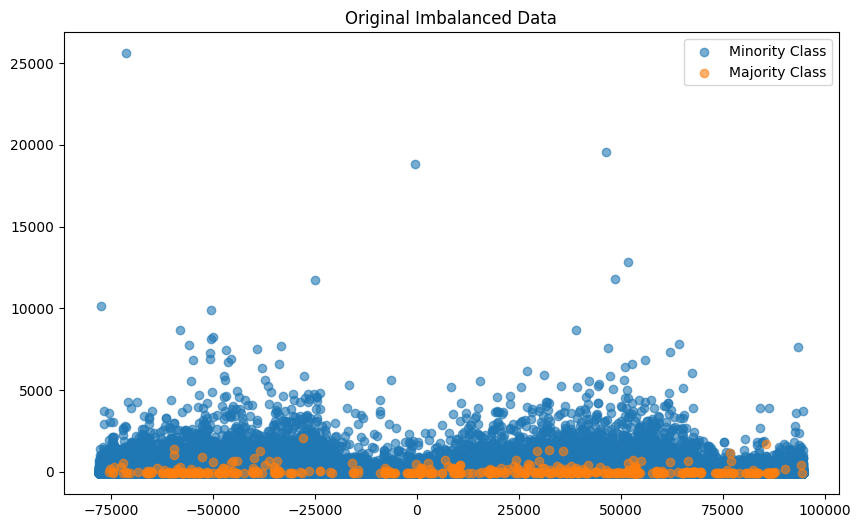

In [212]:
plt.figure(figsize=(10, 6))
plot_pca(X, y, "Original Imbalanced Data")

## 8.2 Random OverSampling

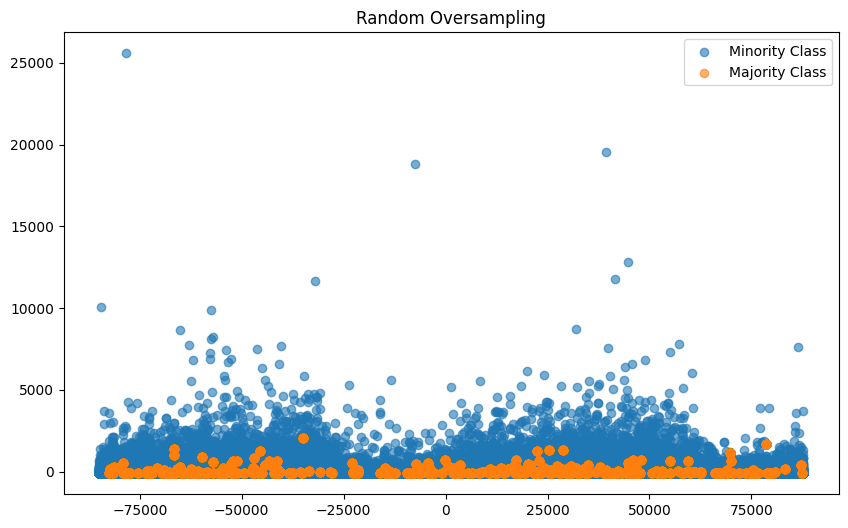

In [213]:
oversampler = RandomOverSampler(random_state=42)
plt.figure(figsize=(10, 6))
X_over, y_over = oversampler.fit_resample(X, y)
plot_pca(X_over, y_over, "Random Oversampling")

## 8.3 Random UnderSampling


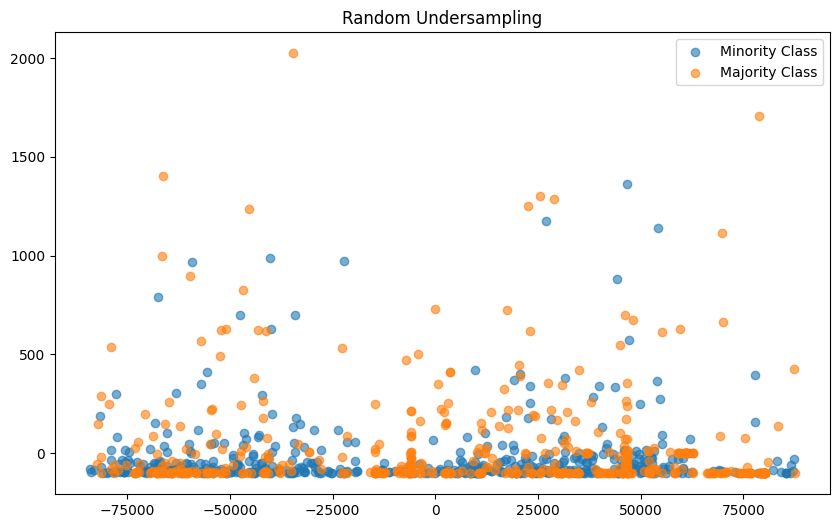

In [214]:
under = RandomUnderSampler(random_state=42)
plt.figure(figsize=(10, 6))
X_under, y_under = under.fit_resample(X, y)
plot_pca(X_under, y_under, "Random Undersampling")

## 8.4 SMOTE

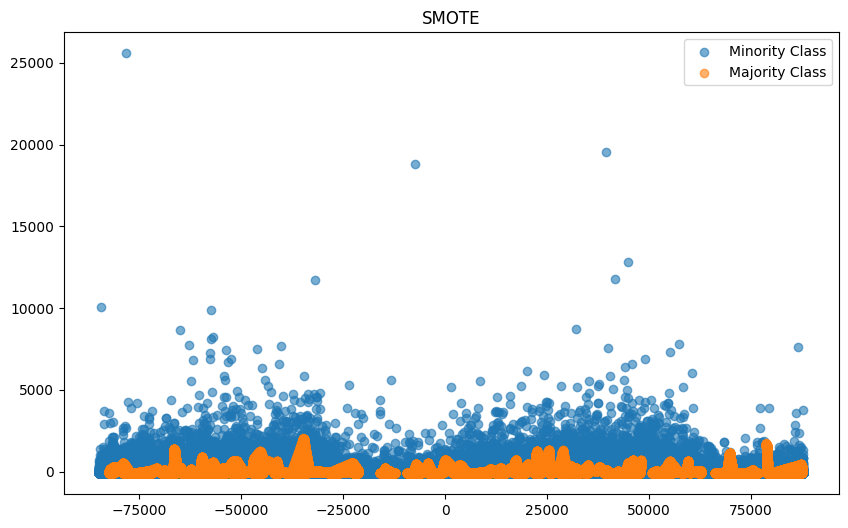

In [215]:
smote = SMOTE(random_state=42)
plt.figure(figsize=(10, 6))
X_smote, y_smote = smote.fit_resample(X, y)
plot_pca(X_smote, y_smote, "SMOTE")

## 8.5 Summary
- Original Data: Imbalanced, with the majority class dominating. This could lead to biased models.
- Random Oversampling: Helps balance the data but risks overfitting due to repeated samples. Good for situations where you're not worried about overfitting.
- Random Undersampling: Creates balance by removing data, which can lead to loss of information. Useful when the dataset is very large and reducing it won’t significantly harm the model’s performance.
- SMOTE: Adds diversity by creating new synthetic samples, reducing overfitting, and potentially improving generalization. It’s often a better choice compared to random oversampling if you want to retain more realistic class distributions

# 9. Summary 

The primary objective of this notebook was to evaluate the performance of various machine learning algorithms on imbalanced datasets and to demonstrate effective techniques to address this challenge. Imbalanced datasets are difficult to work with because most models struggle to learn from and make accurate predictions on them.

## 9.1 Shallow algorythms

In [216]:
# models results on raw data
cv_models_df.style.highlight_max(axis=1, color="pink")

,LogReg,RF,KNN
fit_time,3.320984,161.188167,0.105586
score_time,0.387710,1.800118,82.829047
test_f1_macro,0.860172,0.931676,0.918291
test_f1_micro,0.999178,0.999568,0.999487
test_recall,0.617886,0.790650,0.760163
test_precision,0.867192,0.951399,0.930856
test_acuracy,0.999178,0.999568,0.999487
test_AUC_PR,0.757268,0.843899,0.800688


Three models—Logistic Regression, Random Forest, and KNN—were tested on the raw dataset. The results showed that Random Forest outperformed the others in terms of precision, recall, and overall accuracy.

In [217]:
# Models results on Oversampled dataset
cross_valdiation_oversampling_shallow_df.style.highlight_max(axis=1, color="pink")


,LogReg,RF,KNN
fit_time,5.456360,115.013029,0.278220
score_time,0.114671,0.974844,209.278617
test_f1_macro,0.551467,0.919756,0.864822
test_f1_micro,0.975890,0.999491,0.998953
test_recall,0.901670,0.772796,0.816876
test_precision,0.061540,0.920423,0.660665
test_accuracy,0.975890,0.999491,0.998953
test_AUC_PR,0.767706,0.836390,0.670613


Random Forest showing the best performance across most metrics. However, the fit times and score times were higher compared to the raw data.

In [218]:
# Models results on Undersampled dataset
cross_valdiation_undersampling_shallow_df.style.highlight_max(axis=1, color="pink")

,LogReg,RF,KNN
fit_time,0.087607,0.405167,0.090502
score_time,0.160832,0.977073,4.233561
test_f1_macro,0.523099,0.552296,0.563004
test_f1_micro,0.955157,0.974334,0.979998
test_recall,0.918642,0.905037,0.894936
test_precision,0.036035,0.063294,0.073783
test_accuracy,0.955157,0.974334,0.979998
test_AUC_PR,0.637818,0.754345,0.418893


Undersampling led to a decrease in performance for all models, especially for Random Forest. This technique, while effective in balancing the dataset, results in a loss of information, which negatively impacts the model's ability to learn.The best model to deal with imbalance data set was Random Forest. Ensemble algorithms are particulate good in this kind of tasks since there are building multiple decision trees and aggregate their results. The performance was better when we applied Oversampling but much worst when it coms down to applying Undersampling - that is because of it's nature. Undersampnig allows to balance data set but in the same time we loose a lot of inforamtion so models has less data to learn from. Random Forest did also well on raw data

In [219]:
# Final shallow models results - after RandomizesSearchCv and GridSearchCV
shallow_models_results.style.highlight_max(axis=1, color="pink")

,RF Oversampled Final,RF No Manipulation Final,RF Undersampled Final
F1 Macro,0.950627,0.912293,0.563900
F1 Micro,0.999693,0.999456,0.979724
Recall,0.820513,0.744898,0.948718
Precision,1.000000,0.924051,0.074447
Accuracy,0.999693,0.999456,0.979724
AUC PR,0.929177,0.824086,0.707043


The Random Forest model trained on oversampled data consistently delivered the best performance, demonstrating the benefits of oversampling combined with proper hyperparameter tuning. The models with no data manipulation and undersampling were less effective, with undersampling leading to the most significant drop in performance.

I decided to give a shot also to XGboost , one of the best algorythm


In [220]:
# XGBoost on Oversample and Undersample data - after RandomizesSearchCv and GridSearchCV 
xgb_over_final_results_df.join(xgb_under_final_results_df).style.highlight_max(axis=1, color="pink")

,XGB Final Over,XGB Final Undersample
F1 Macro,0.941460,0.536920
F1 Micro,0.999605,0.967347
Recall,0.871795,0.948718
Precision,0.894737,0.047497
Accuracy,0.999605,0.967347
AUC PR,0.917100,0.794623


XGBoost, another robust algorithm, was also tested on both oversampled and undersampled data. Similar to Random Forest, it performed best when trained on oversampled data,

There are many different techniques ment do deal with imbalance, one of them is SMOTE

In [221]:
# SMOTE techniqe - Without RandomizesSearchCV and GridSearchCV
smote_results.style.highlight_max(axis=1, color="pink")


,RF SMOTE,XGB SMOTE
F1 Macro,0.934101,0.909474
F1 Micro,0.999561,0.999342
Recall,0.846154,0.871795
Precision,0.891892,0.772727
Accuracy,0.999561,0.999342
AUC PR,0.910549,0.906436


The SMOTE (Synthetic Minority Over-sampling Technique) method was explored without hyperparameter tuning. Even without optimization, models trained using SMOTE performed well, indicating that it may be the most effective method for handling imbalanced data.

## 9.2 Deep Learning

Contrary to some expectations, deep learning models struggled significantly with imbalanced datasets. Despite achieving almost perfect performance on training sets, they failed to generalize on test data, indicating a need for better data balancing or alternative approaches for this type of task.

In [222]:
deep_models_results =deep_model_no_manipulation_evaluation_df.join(deep_model_over_evaluation_df)
deep_models_results = deep_models_results.join(deep_model_under_evaluation_df)
deep_models_results.style.highlight_max(axis=1, color="pink")


,Deep model NO data manipulation,Deep Oversampled,Deep Undersampled
accuracy,0.998280,0.998297,0.001720
f1_score,0.020000,0.020202,0.003435
precision,0.500000,1.000000,0.001720
recall,0.010204,0.010204,1.000000
auc_pr,0.006805,0.011907,0.001708


# 10. Key takaways
1. Key Metrics in Fraud Detection:
    * Recall and AUC-PR are critical metrics for evaluating model performance, as they emphasize the ability to detect fraudulent instances effectively.


2. Ensemble Models on Imbalanced Data:
    * Ensemble models (like Random Forest and XGBoost) can handle imbalanced datasets even without data manipulation, but their performance can be significantly improved with proper techniques. There's still room for optimization.


3. Effectiveness of Oversampling:
    * Oversampling methods proved more effective than undersampling, as they help retain data information, leading to better model performance.


4. Potential of SMOTE:
    * SMOTE (Synthetic Minority Over-sampling Technique) is a promising approach for dealing with imbalanced data, showing solid results even without hyperparameter tuning.


5. Role of Dimensionality Reduction:
    * Techniques like PCA (Principal Component Analysis) can be useful for understanding which data manipulation strategies yield the best results, as they help identify patterns and reduce noise.


# 11. Future advices 
1. Adjust Data Splits for Imbalanced Datasets:
    * For imbalanced datasets, consider a smaller split for validation and test sets (e.g., 80% Training - 10% Validation - 10% Testing). This allows the model to learn from more data, improving performance.


2. Cross-Validation Best Practices:
    * Use a 5-fold cross-validation (cv=5) for a more robust evaluation of model performance. Increase this if time permits for even more reliable results.


3. Efficient Parameter Tuning:
    * If hyperparameter tuning is time-consuming, consider using HalvingRandomSearchCV or HalvingGridSearchCV. These methods can provide faster optimization by gradually reducing the search space.


4. Final Model Training:
    * When training the final model, use a simpler data split: Training and Testing only (no Validation set). This will maximize the data available for training, helping the model learn better.


5. Prevent Overfitting in Deep Learning:
    * Implement early stopping when training deep learning models to avoid overfitting and ensure the model generalizes well to new data.

# Thank you 
To everyone who takes the time to review this notebook. Your feedback, insights, and support are greatly appreciated. I hope this work provides useful insights into handling imbalanced datasets and inspires further exploration in this field. Feel free to share your thoughts, suggestions, or questions—your input helps improve and refine future projects.

